In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import copy

from scipy.special import expit
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid

from sklearn.metrics import r2_score

from torch.utils.data import TensorDataset, DataLoader
import time as time

from torchvision import datasets
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
import random

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Fashion MNIST


In [4]:
fashion_MNIST_train = datasets.FashionMNIST('./fashion_mnist',
                                            train=True,
                                            download=True,
                                            transform=transforms.ToTensor())

fashion_MNIST_test = datasets.FashionMNIST('./fashion_mnist',
                                           train=False,
                                           download=True,
                                           transform=transforms.ToTensor())

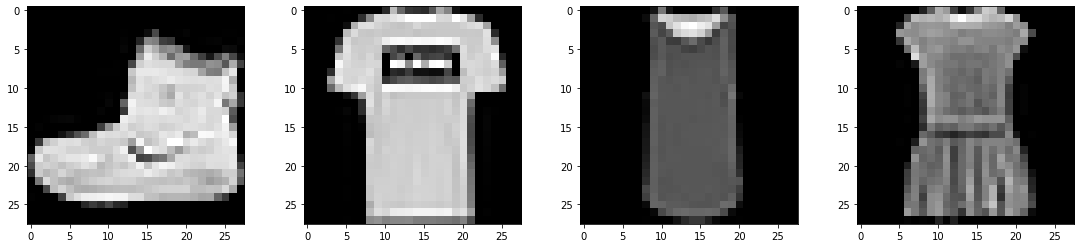

In [5]:
fig, gs = plt.figure(figsize=(19, 4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(fashion_MNIST_train[i][0][0]), 'gray')

plt.show()

# Functions and classes

In [6]:
class convex_weighing_machine(torch.nn.Module):
    '''
    Builds a model that is a convex combination of models from a trained_list
    
    To get a convex combination, use softmax
    '''
    def __init__(self,
                 trained_list,
                 input_dim=784,
                 num_layers=0,
                 hidden_dim=64,
                 output_dim=1,
                 p=0.0):

        super().__init__()
        self.trained_list = trained_list
        self.conv_weights = torch.nn.Parameter(torch.ones(len(trained_list)))
        self.conv_weights.requires_grad = True

    def forward(self, x):
        outs = self.trained_list[0](x) * torch.exp(self.conv_weights[0])
        for model_id in range(1, len(self.trained_list)):
            outs += self.trained_list[model_id](x) * torch.exp(
                self.conv_weights[model_id])
        return outs / torch.exp(self.conv_weights).sum()

In [7]:
class line_weighing_machine(torch.nn.Module):
    '''
    Builds a model that is a linear combination of models from a trained_list
    
    Initial initialization by averaging
    '''
    def __init__(self,
                 trained_list,
                 input_dim=784,
                 num_layers=0,
                 hidden_dim=64,
                 output_dim=1,
                 p=0.0):

        super().__init__()
        self.trained_list = trained_list
        coefs = np.array([1 / (len(trained_list))] * len(trained_list))
        self.conv_weights = torch.nn.Parameter(torch.from_numpy(coefs))
        self.conv_weights.requires_grad = True

    def forward(self, x):
        outs = self.trained_list[0](x) * (self.conv_weights[0])
        for model_id in range(1, len(self.trained_list)):
            outs += self.trained_list[model_id](x) * (
                self.conv_weights[model_id])
        return outs

In [8]:
def make_list_of_models(num_of_models,
                        dataset,
                        loss_function,
                        epochs,
                        lr,
                        input_dim=784,
                        num_layers=0,
                        hidden_dim=20,
                        grad=True,
                        output_dim=1,
                        p=0.0):
    '''
  Builds a list of models

  Depending on the value of the parameter grad:
      *) trains and freezes the weights
      *) leaves a random initialization
  '''

    trained_list = torch.nn.ModuleList()
    for idm in range(num_of_models):
        model = Perceptron(input_dim=input_dim,
                           num_layers=num_layers,
                           hidden_dim=hidden_dim,
                           output_dim=output_dim,
                           p=p)
        if grad == False:
            model.to(device)
            _ = model.train()
            trainer(model=model,
                    dataset=dataset,
                    lr=lr,
                    loss_function=loss_function,
                    optimizer=torch.optim.Adam,
                    epochs=epochs)
            _ = model.eval()
            for par in model.parameters():
                par.requires_grad = False
        if grad == True:
            model.to(device)
            for par in model.parameters():
                par.requires_grad = True
        trained_list.append(copy.deepcopy(model))
    return trained_list

In [9]:
def classic_star_models(num_of_models,
                        dataset,
                        loss_function,
                        epochs,
                        lr,
                        warmup=False,
                        prop_warmup=0.0,
                        input_dim=784,
                        num_layers=0,
                        hidden_dim=20,
                        grad=False,
                        output_dim=1,
                        p=0.0):
    '''
  Builds a models based on star procedure: Classic Star (no wrmp) and Classic Star (new wrmp) 
  
  Depending on the value of warmup:
      *) builds only Classic Star (no wrmp)
      *) builds both models
  '''

    # Let's make list of trained models
    start_time = time.time()
    trained_list = make_list_of_models(num_of_models=num_of_models,
                                       dataset=dataset,
                                       loss_function=loss_function,
                                       epochs=epochs,
                                       lr=lr,
                                       input_dim=input_dim,
                                       num_layers=num_layers,
                                       hidden_dim=hidden_dim,
                                       grad=False,
                                       output_dim=output_dim,
                                       p=p)
    trained_list_time = round(time.time() - start_time)
    trained_list_forwrmp = copy.deepcopy(trained_list)

    # Let's append new not trained model
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)

    trained_list.append(copy.deepcopy(model))

    # Let's do convex weighing
    star_nowrmp = convex_weighing_machine(trained_list=trained_list,
                                          input_dim=input_dim,
                                          num_layers=num_layers,
                                          hidden_dim=hidden_dim,
                                          output_dim=output_dim,
                                          p=p)
    star_nowrmp.to(device)
    _ = star_nowrmp.train()
    start_time = time.time()
    trainer(model=star_nowrmp,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=epochs)
    _ = star_nowrmp.eval()
    star_nowrmp_time = round(time.time() - start_time) + trained_list_time
    if warmup:
        start_time = time.time()
        model = Perceptron(input_dim=input_dim,
                           num_layers=num_layers,
                           hidden_dim=hidden_dim,
                           output_dim=output_dim,
                           p=p)
        model.to(device)
        _ = model.train()
        trainer(model=model,
                dataset=dataset,
                lr=lr,
                loss_function=loss_function,
                optimizer=torch.optim.Adam,
                epochs=int(epochs * prop_warmup))
        _ = model.eval()
        trained_list_forwrmp.append(model)
        star_newwrmp = convex_weighing_machine(
            trained_list=trained_list_forwrmp,
            input_dim=input_dim,
            num_layers=num_layers,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            p=p)
        star_newwrmp.to(device)
        _ = star_newwrmp.train()
        start_time = time.time()
        trainer(model=star_newwrmp,
                dataset=dataset,
                lr=lr,
                loss_function=loss_function,
                optimizer=torch.optim.Adam,
                epochs=int(epochs * (1 - prop_warmup)))
        _ = star_newwrmp.eval()
        star_newwrmp_time = round(time.time() - start_time) + trained_list_time
    else:
        star_newwrmp, star_newwrmp_time = None, None

    return star_nowrmp, star_newwrmp, star_nowrmp_time, star_newwrmp_time

In [10]:
def snapshot_list(num_of_models,
                  dataset,
                  loss_function,
                  budget,
                  lr,
                  input_dim=784,
                  num_layers=0,
                  hidden_dim=20,
                  grad=True,
                  output_dim=1,
                  p=0.0):
    '''
  Builds a list of models based on the snapshot technique

  The latest model is inserted into the list twice
  Number of epochs per model train is budget//num_cycles
  Doing num_of_model-1 cycles (we leave the last cycle for the possibility of choosing the aggregation process)
  '''
    num_cycles = num_of_models
    epochs = budget // num_cycles
    trained_list = torch.nn.ModuleList()
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)
    for idm in range(num_cycles - 1):
        model.to(device)
        _ = model.train()
        cycle_trainer(model=model,
                      dataset=dataset,
                      lr=lr,
                      loss_function=loss_function,
                      optimizer=torch.optim.Adam,
                      epochs=epochs)
        _ = model.eval()
        copy_model = copy.deepcopy(model)
        for par in copy_model.parameters():
            par.requires_grad = False
        trained_list.append(copy_model)
    trained_list.append(copy.deepcopy(model))
    return trained_list

In [11]:
def snap_models(num_of_models,
                dataset,
                loss_function,
                budget,
                lr,
                input_dim=784,
                num_layers=0,
                hidden_dim=20,
                grad=False,
                output_dim=1,
                p=0.0,
                warmup=True,
                prop_warmup=0.4):
    '''
  Builds based on the one list of models from the snapshot technique Snap Star (shot wrmp), Snap Ensemble and Snap Star (new wrmp)
  
  Along with the models returns the training time                                   
  '''
    # Let's make list of trained models by snapshot technique
    start_time = time.time()
    trained_list = snapshot_list(num_of_models=num_of_models,
                                 dataset=dataset,
                                 loss_function=loss_function,
                                 budget=budget,
                                 lr=lr,
                                 input_dim=input_dim,
                                 num_layers=num_layers,
                                 hidden_dim=hidden_dim,
                                 grad=False,
                                 output_dim=output_dim,
                                 p=p)

    snapstar_shotwrmp_list = copy.deepcopy(trained_list)
    snapstar_newwrmp_list = copy.deepcopy(trained_list)
    snapensemble_trained_list = copy.deepcopy(trained_list)

    # Let's do Snap Ensemble
    training_list_time = round(time.time() - start_time)
    model = snapensemble_trained_list[-1]
    model.to(device)
    _ = model.train()
    start_time = time.time()
    cycle_trainer(model=model,
                  dataset=dataset,
                  lr=lr,
                  loss_function=loss_function,
                  optimizer=torch.optim.Adam,
                  epochs=budget // num_of_models)
    _ = model.eval()
    snapensemble_trained_list[-1] = model
    last_model_ensemble = round(time.time() - start_time)
    snapensemble_time = training_list_time + last_model_ensemble
    print("Training time: Snap Ensemble", snapensemble_time, "seconds")

    # Let's do Snap Star (shot wrmp)
    snapstar_shotwrmp = convex_weighing_machine(
        trained_list=snapstar_shotwrmp_list,
        input_dim=input_dim,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        p=p)
    snapstar_shotwrmp.to(device)
    start_time = time.time()
    _ = snapstar_shotwrmp.train()
    cycle_trainer(model=snapstar_shotwrmp,
                  dataset=dataset,
                  lr=lr,
                  loss_function=loss_function,
                  optimizer=torch.optim.Adam,
                  epochs=budget // num_of_models)
    _ = snapstar_shotwrmp.eval()
    last_model_snapstar_shotwrmp = round(time.time() - start_time)
    snapstar_shotwrmp_time = training_list_time + last_model_snapstar_shotwrmp
    print("Training time: Snap Star (shot wrmp)", snapstar_shotwrmp_time,
          "seconds")

    #Let's train Snap Star (new wrmp)
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)
    model.to(device)
    _ = model.train()
    start_time = time.time()
    trainer(model=model,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=int((prop_warmup) * budget // num_of_models))
    _ = model.eval()
    warmup_time = round(time.time() - start_time)
    snapstar_newwrmp_list[-1] = model
    snapstar_newwrmp = convex_weighing_machine(
        trained_list=snapstar_newwrmp_list,
        input_dim=input_dim,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        p=p)
    snapstar_newwrmp.to(device)
    start_time = time.time()
    _ = snapstar_newwrmp.train()
    trainer(model=snapstar_newwrmp,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=int((1 - prop_warmup) * budget // num_of_models))
    _ = snapstar_newwrmp.eval()
    last_model_time = round(time.time() - start_time) + warmup_time
    snapstar_newwrmp_time = training_list_time + last_model_time
    print("Training time: Snap Star (new wrmp)", snapstar_newwrmp_time,
          "seconds")

    return snapstar_shotwrmp, snapensemble_trained_list, snapstar_newwrmp,\
           snapstar_shotwrmp_time, snapensemble_time, snapstar_newwrmp_time

In [12]:
def ensemble(num_of_models,
             dataset,
             loss_function,
             epochs,
             lr,
             input_dim=784,
             num_layers=0,
             hidden_dim=20,
             grad=False,
             output_dim=1,
             p=0.0):
    '''
  Building a model Ensemble
  
  Returns a list of models to average
  '''

    # Let's make list of not trained models
    trained_list = make_list_of_models(num_of_models=num_of_models,
                                       dataset=dataset,
                                       loss_function=loss_function,
                                       epochs=epochs,
                                       lr=lr,
                                       input_dim=input_dim,
                                       num_layers=num_layers,
                                       hidden_dim=hidden_dim,
                                       grad=False,
                                       output_dim=output_dim,
                                       p=p)
    # Let's append new trained model
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)
    model.to(device)
    _ = model.train()
    trainer(model=model,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=epochs)
    _ = model.eval()
    trained_list.append(copy.deepcopy(_))
    return trained_list

In [13]:
def big_nn(num_of_models,
           dataset,
           loss_function,
           epochs,
           lr,
           input_dim=784,
           num_layers=0,
           hidden_dim=20,
           grad=False,
           output_dim=1,
           p=0.0):
    '''
  Building a model Big NN
  '''

    # Let's make list of not trained models
    trained_list = make_list_of_models(num_of_models=num_of_models,
                                       dataset=dataset,
                                       loss_function=loss_function,
                                       epochs=epochs,
                                       lr=lr,
                                       input_dim=input_dim,
                                       num_layers=num_layers,
                                       hidden_dim=hidden_dim,
                                       grad=True,
                                       output_dim=output_dim,
                                       p=p)
    # Let's append new not trained model
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)
    trained_list.append(copy.deepcopy(model))
    # Let's do linear weighing
    final_model = line_weighing_machine(trained_list=trained_list,
                                        input_dim=input_dim,
                                        num_layers=num_layers,
                                        hidden_dim=hidden_dim,
                                        output_dim=output_dim,
                                        p=p)
    final_model.to(device)
    _ = final_model.train()
    trainer(model=final_model,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=epochs)
    _ = final_model.eval()

    return _

In [14]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self,
                 input_dim=784,
                 num_layers=0,
                 hidden_dim=15,
                 output_dim=10,
                 p=0.0):
        super(Perceptron, self).__init__()

        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv2d(1,
                                                        1 * 6,
                                                        kernel_size=5))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size=2))
        self.layers.add_module('conv2',
                               torch.nn.Conv2d(1 * 6, 1 * 16, kernel_size=5))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size=2))
        self.layers.add_module('flatten', torch.nn.Flatten())
        self.layers.add_module('linear1', torch.nn.Linear(16 * 4 * 4, 120))
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('linear2', torch.nn.Linear(120, 84))
        self.layers.add_module('relu4', torch.nn.ReLU())
        self.layers.add_module('linear3', torch.nn.Linear(84, 10))

    def forward(self, input):
        return self.layers(input)

# Train-functions

In [15]:
def trainer(epochs,
            dataset,
            model,
            loss_function,
            optimizer,
            batch_size=64,
            lr=0.01,
            callback=None):
    start_time = time.time()
    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(epochs), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True),
                               leave=False)

        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})
        acc, report = testing(model, fashion_MNIST_test)
        entropy = loss(model.eval(),
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('epoch num: ', it, 'loss: ', entropy, '\n', report)
    training_time = round(time.time() - start_time)
    print("Training time:", training_time, "seconds")

In [16]:
def cycle_trainer(epochs,
                  dataset,
                  model,
                  loss_function,
                  optimizer,
                  batch_size=64,
                  lr=0.01,
                  callback=None):
    '''
    Learning with cyclic change of lr by cosine formula from snapshot ensemble
    Cycle length is epochs
    '''
    start_time = time.time()
    iterations = tqdm(range(epochs), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True),
                               leave=False)
        # lets calculate lr_
        lr_ = (lr / 2) * (np.cos(np.pi * (it / epochs)) + 1)
        optima = optimizer(model.parameters(), lr=lr_)

        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})
        acc, report = testing(model, fashion_MNIST_test)
        entropy = loss(model.eval(),
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('epoch num: ', it, 'lr:', lr_, ' loss: ', entropy, '\n', report)
    training_time = round(time.time() - start_time)
    print("Training time:", training_time, "seconds")

In [17]:
def train_epoch(train_generator,
                model,
                loss_function,
                optimizer,
                callback=None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device),
                                    batch_of_y.to(device), optimizer,
                                    loss_function)

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss * len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss / total

In [18]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    x = x_batch
    y = y_batch
    output = model(x)
    loss_ = loss_function(output, y)
    loss_.backward()
    optimizer.step()
    return loss_.cpu().item()

In [19]:
def loss(model, dataset, loss_function, seed=0):
    test_losses = []
    train_losses = []
    generator = torch.utils.data.DataLoader(dataset,
                                            batch_size=dataset.__len__(),
                                            shuffle=True,
                                            drop_last=True)
    with torch.no_grad():
        for x, y in tqdm(generator, leave=False):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = loss_function(output, y)

    return loss.cpu().item()

In [20]:
def ensemble_loss(trained_list, dataset, loss_function, seed=0):
    test_losses = []
    train_losses = []
    generator = torch.utils.data.DataLoader(dataset,
                                            batch_size=dataset.__len__(),
                                            shuffle=True,
                                            drop_last=True)
    with torch.no_grad():
        for x, y in tqdm(generator, leave=False):
            x = x.to('cpu')
            y = y.to('cpu')
            target_ = y.detach().numpy()
            output = trained_list[0].to('cpu')(x)
            func = torch.nn.Softmax(dim=1)
            # calculate the result of the first model
            output = func(output)
            input_ = output.detach().numpy()
            ensemble_input = input_

            # calculate and aggregate the results of the other models
            for num_mod in range(1, len(trained_list)):
                output = trained_list[num_mod].to('cpu')(x)
                output = func(output)
                input_ = output.detach().numpy()
                ensemble_input += input_
            ensemble_input = ensemble_input / len(trained_list)

            # calculate sum entropy-loss
            loss = 0
            for i in range(input_.shape[0]):
                loss -= np.log(ensemble_input[i][target_[i]])
    return loss / x.shape[0]

In [21]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    pred = []
    real = []
    for x, y in generator:
        x = x.to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())
    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred, digits = 4)

In [22]:
def ensemble_testing(trained_list, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    pred = []
    real = []
    for x, y in generator:
        x = x.to('cpu')
        y = y.to('cpu')

        # calculate the result of the first model
        target_ = y.detach().numpy()
        output = trained_list[0].to('cpu')(x)
        func = torch.nn.Softmax(dim=1)
        output = func(output)
        input_ = output.detach().numpy()
        ensemble_input = input_

        # calculate and aggregate the results of the other models
        for num_mod in range(1, len(trained_list)):
            output = trained_list[num_mod].to('cpu')(x)
            output = func(output)
            input_ = output.detach().numpy()
            ensemble_input += input_
        ensemble_input = ensemble_input / len(trained_list)
        pred.extend(
            torch.argmax(torch.Tensor(ensemble_input),
                         dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())
    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred, digits = 4)

In [23]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    x = np.exp(x)
    return x / np.sum(x)

In [24]:
def print_params_of_model(list_of_model):
    r'''
  print params of the list of model
  '''
    idm = 0
    for model in list_of_model:
        params = [x for x in model.parameters()]
        print('params model num:', idm, params, '\n')
        idm += 1


def print_convex_params(model):
    r'''
  print convex params of model
  '''
    coefs = model.conv_weights.detach().numpy()
    convex_coefs = np.exp(coefs) / sum(np.exp(coefs))
    print('convex params of model:', convex_coefs, '\n')

# Let's run some tests

In [25]:
from sklearn.model_selection import ParameterGrid

grid = ParameterGrid({
    'epochs': [25],
    'p': [0.0],
    'loss': [torch.nn.CrossEntropyLoss()],
    'out_dim': [10],
    'lr': [0.001],
    'inp_dim': [784],
    'num_mod': [5],
    'grad': [False]
})

In [26]:
results = pd.DataFrame(
    data=[],
    columns=['Name', 'd', 'epochs', 'accuracy', 'entropy', 'TIME', 'p', 'lr'])

In [27]:
starts = 1
for start in tqdm(range(starts)):
    for item in tqdm(grid):

        # Let's train Snap Star (new wrmp), Snap Ensemble and Snap Star (shot wrmp)
        snap_star_shotwarmup, snap_ensemble, snap_star_newwarmup, snap_star_shotwarmup_time,\
        ensemble_time, snap_star_newwarmup_time = snap_models(num_of_models = (item['num_mod']+1),
                                                              dataset=fashion_MNIST_train,
                                                              loss_function=item['loss'],
                                                              output_dim=item['out_dim'],
                                                              budget=item['epochs']*(item['num_mod']+1),
                                                              input_dim=item['inp_dim'],
                                                              lr =item['lr'],
                                                              p=item['p'],
                                                              grad =item['grad'])

        # Let's test Snap Star (new wrmp)
        print("Training time:", snap_star_newwarmup_time, "seconds")
        acc, report = testing(snap_star_newwarmup, fashion_MNIST_test)
        entropy = loss(snap_star_newwarmup,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Snap Star (new wrmp) (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        snap_star_newwarmup_scores = pd.DataFrame(data=[[
            "Snap Star (new wrmp)", item['num_mod'], item['epochs'], acc,
            entropy, snap_star_newwarmup_time, item['p'], item['lr']
        ]],
                                                  columns=[
                                                      'Name', 'd', 'epochs',
                                                      'accuracy', 'entropy',
                                                      'TIME', 'p', 'lr'
                                                  ])
        results = pd.concat([snap_star_newwarmup_scores, results],
                            ignore_index=False)
        print('Snap Star (new wrmp) params:')
        print_convex_params(snap_star_newwarmup)

        # Let's test Snap Star (shot wrmp)
        print("Training time:", snap_star_shotwarmup_time, "seconds")
        acc, report = testing(snap_star_shotwarmup, fashion_MNIST_test)
        entropy = loss(snap_star_shotwarmup,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Snap Star (shot wrmp) (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        snap_star_shotwarmup_scores = pd.DataFrame(data=[[
            "Snap Star (shot wrmp)", item['num_mod'], item['epochs'], acc,
            entropy, snap_star_shotwarmup_time, item['p'], item['lr']
        ]],
                                                   columns=[
                                                       'Name', 'd', 'epochs',
                                                       'accuracy', 'entropy',
                                                       'TIME', 'p', 'lr'
                                                   ])
        results = pd.concat([snap_star_shotwarmup_scores, results],
                            ignore_index=False)
        print('Snap Star (shot wrmp) params:')
        print_convex_params(snap_star_shotwarmup)

        # Let's test Snap Ensemble
        print("Training time:", ensemble_time, "seconds")
        acc, report = ensemble_testing(snap_ensemble, fashion_MNIST_test)
        entropy = ensemble_loss(snap_ensemble,
                                dataset=fashion_MNIST_test,
                                loss_function=torch.nn.CrossEntropyLoss())
        print('Snap Ensemble (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        snap_ensemble_scores = pd.DataFrame(data=[[
            "Snap Ensemble", item['num_mod'], item['epochs'], acc, entropy,
            ensemble_time, item['p'], item['lr']
        ]],
                                            columns=[
                                                'Name', 'd', 'epochs',
                                                'accuracy', 'entropy', 'TIME',
                                                'p', 'lr'
                                            ])
        results = pd.concat([snap_ensemble_scores, results],
                            ignore_index=False)

        # Let's train Ensemble
        start_time = time.time()
        nn_ensemble = ensemble(num_of_models=item['num_mod'],
                               dataset=fashion_MNIST_train,
                               loss_function=item['loss'],
                               output_dim=item['out_dim'],
                               epochs=item['epochs'],
                               input_dim=item['inp_dim'],
                               lr=item['lr'],
                               p=item['p'],
                               grad=item['grad'])
        _ = nn_ensemble.eval()
        training_time = round(time.time() - start_time)

        # Let's test Ensemble
        print("Training time:", training_time, "seconds")
        acc, report = ensemble_testing(nn_ensemble, fashion_MNIST_test)
        entropy = ensemble_loss(nn_ensemble,
                                dataset=fashion_MNIST_test,
                                loss_function=torch.nn.CrossEntropyLoss())
        print('Ensemble (epochs, num model):', item['epochs'], item['num_mod'],
              '\n', report)
        ensemble_scores = pd.DataFrame(data=[[
            "Ensemble", item['num_mod'], item['epochs'], acc, entropy,
            training_time, item['p'], item['lr']
        ]],
                                       columns=[
                                           'Name', 'd', 'epochs', 'accuracy',
                                           'entropy', 'TIME', 'p', 'lr'
                                       ])
        results = pd.concat([ensemble_scores, results], ignore_index=False)

        # Let's train Big NN
        start_time = time.time()
        bignn = big_nn(num_of_models=item['num_mod'],
                       dataset=fashion_MNIST_train,
                       loss_function=item['loss'],
                       output_dim=item['out_dim'],
                       epochs=item['epochs'],
                       input_dim=item['inp_dim'],
                       lr=item['lr'],
                       p=item['p'],
                       grad=item['grad'])
        _ = bignn.eval()
        training_time = round(time.time() - start_time)

        #Let's test Big NN
        print("Training time:", training_time, "seconds")
        acc, report = testing(bignn, fashion_MNIST_test)
        entropy = loss(bignn,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Big NN (epochs, num model):', item['epochs'], item['num_mod'],
              '\n', report)
        big_nn_scores = pd.DataFrame(data=[[
            "Big NN", item['num_mod'], item['epochs'], acc, entropy,
            training_time, item['p'], item['lr']
        ]],
                                     columns=[
                                         'Name', 'd', 'epochs', 'accuracy',
                                         'entropy', 'TIME', 'p', 'lr'
                                     ])
        results = pd.concat([big_nn_scores, results], ignore_index=False)
        print('Big NN params:')
        print_convex_params(bignn)

        # Let's train Classic Star (no wrmp) and Classic Star (new wrmp)
        start_time = time.time()
        star_nowrmp, star_newwrmp, star_nowrmp_time, star_newwrmp_time = classic_star_models(
            num_of_models=item['num_mod'],
            dataset=fashion_MNIST_train,
            loss_function=item['loss'],
            output_dim=item['out_dim'],
            epochs=item['epochs'],
            input_dim=item['inp_dim'],
            lr=item['lr'],
            warmup=True,
            prop_warmup=0.4,
            p=item['p'],
            grad=item['grad'])

        # Let's test Classic Star (no wrmp)
        print("Training time:", star_nowrmp_time, "seconds")
        acc, report = testing(star_nowrmp, fashion_MNIST_test)
        entropy = loss(star_nowrmp,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Classic Star (no wrmp) (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        star_nowrmp_scores = pd.DataFrame(data=[[
            "Classic Star (no wrmp)", item['num_mod'], item['epochs'], acc,
            entropy, star_nowrmp_time, item['p'], item['lr']
        ]],
                                          columns=[
                                              'Name', 'd', 'epochs',
                                              'accuracy', 'entropy', 'TIME',
                                              'p', 'lr'
                                          ])
        results = pd.concat([star_nowrmp_scores, results], ignore_index=False)
        print('Classic Star (no wrmp) params:')
        print_convex_params(star_nowrmp)

        # Let's test Classic Star (new wrmp)
        print("Training time:", star_newwrmp_time, "seconds")
        acc, report = testing(star_newwrmp, fashion_MNIST_test)
        entropy = loss(star_newwrmp,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Classic Star (new wrmp) (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        star_newwrmp_scores = pd.DataFrame(data=[[
            "Classic Star (new wrmp)", item['num_mod'], item['epochs'], acc,
            entropy, star_newwrmp_time, item['p'], item['lr']
        ]],
                                           columns=[
                                               'Name', 'd', 'epochs',
                                               'accuracy', 'entropy', 'TIME',
                                               'p', 'lr'
                                           ])
        results = pd.concat([star_newwrmp_scores, results], ignore_index=False)
        print('Classic Star (new wrmp) params:')
        print_convex_params(star_newwrmp)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.5221623182296753 
               precision    recall  f1-score   support

           0     0.7424    0.8040    0.7720      1000
           1     0.9284    0.9720    0.9497      1000
           2     0.7699    0.4650    0.5798      1000
           3     0.7941    0.8290    0.8112      1000
           4     0.6099    0.8160    0.6980      1000
           5     0.9591    0.9140    0.9360      1000
           6     0.4255    0.3600    0.3900      1000
           7     0.9157    0.8800    0.8975      1000
           8     0.9284    0.9590    0.9434      1000
           9     0.8845    0.9650    0.9230      1000

    accuracy                         0.7964     10000
   macro avg     0.7958    0.7964    0.7901     10000
weighted avg     0.7958    0.7964    0.7901     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.000996057350657239  loss:  0.42428717017173767 
               precision    recall  f1-score   support

           0     0.7850    0.8250    0.8045      1000
           1     0.9003    0.9840    0.9403      1000
           2     0.7260    0.7790    0.7516      1000
           3     0.8983    0.7860    0.8384      1000
           4     0.7257    0.7910    0.7569      1000
           5     0.9634    0.9470    0.9551      1000
           6     0.6328    0.5050    0.5617      1000
           7     0.8986    0.9570    0.9269      1000
           8     0.9542    0.9580    0.9561      1000
           9     0.9566    0.9260    0.9411      1000

    accuracy                         0.8458     10000
   macro avg     0.8441    0.8458    0.8433     10000
weighted avg     0.8441    0.8458    0.8433     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009842915805643156  loss:  0.3922150433063507 
               precision    recall  f1-score   support

           0     0.7640    0.8610    0.8096      1000
           1     0.9711    0.9750    0.9731      1000
           2     0.7284    0.8340    0.7776      1000
           3     0.9012    0.8300    0.8641      1000
           4     0.7918    0.7530    0.7719      1000
           5     0.9518    0.9670    0.9593      1000
           6     0.6663    0.5510    0.6032      1000
           7     0.9722    0.8380    0.9001      1000
           8     0.9276    0.9730    0.9497      1000
           9     0.8898    0.9770    0.9314      1000

    accuracy                         0.8559     10000
   macro avg     0.8564    0.8559    0.8540     10000
weighted avg     0.8564    0.8559    0.8540     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009648882429441257  loss:  0.35114017128944397 
               precision    recall  f1-score   support

           0     0.7926    0.8520    0.8212      1000
           1     0.9937    0.9500    0.9714      1000
           2     0.7728    0.8300    0.8004      1000
           3     0.8632    0.8900    0.8764      1000
           4     0.7645    0.8440    0.8023      1000
           5     0.9396    0.9800    0.9594      1000
           6     0.7437    0.5340    0.6217      1000
           7     0.9483    0.9180    0.9329      1000
           8     0.9447    0.9740    0.9591      1000
           9     0.9500    0.9500    0.9500      1000

    accuracy                         0.8722     10000
   macro avg     0.8713    0.8722    0.8695     10000
weighted avg     0.8713    0.8722    0.8695     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0009381533400219318  loss:  0.3300570845603943 
               precision    recall  f1-score   support

           0     0.8118    0.8410    0.8261      1000
           1     0.9848    0.9690    0.9768      1000
           2     0.7555    0.8560    0.8026      1000
           3     0.8862    0.8880    0.8871      1000
           4     0.8233    0.7780    0.8000      1000
           5     0.9765    0.9540    0.9651      1000
           6     0.6785    0.6330    0.6549      1000
           7     0.9394    0.9460    0.9427      1000
           8     0.9866    0.9540    0.9700      1000
           9     0.9478    0.9630    0.9554      1000

    accuracy                         0.8782     10000
   macro avg     0.8790    0.8782    0.8781     10000
weighted avg     0.8790    0.8782    0.8781     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.0009045084971874737  loss:  0.31935423612594604 
               precision    recall  f1-score   support

           0     0.8159    0.8290    0.8224      1000
           1     0.9928    0.9650    0.9787      1000
           2     0.7778    0.8540    0.8141      1000
           3     0.8553    0.9220    0.8874      1000
           4     0.8601    0.7560    0.8047      1000
           5     0.9767    0.9630    0.9698      1000
           6     0.6848    0.6560    0.6701      1000
           7     0.9244    0.9660    0.9447      1000
           8     0.9701    0.9720    0.9710      1000
           9     0.9783    0.9450    0.9613      1000

    accuracy                         0.8828     10000
   macro avg     0.8836    0.8828    0.8824     10000
weighted avg     0.8836    0.8828    0.8824     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0008644843137107057  loss:  0.3127889931201935 
               precision    recall  f1-score   support

           0     0.8251    0.8350    0.8300      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8870    0.7220    0.7960      1000
           3     0.9017    0.8900    0.8958      1000
           4     0.8078    0.8280    0.8178      1000
           5     0.9616    0.9760    0.9687      1000
           6     0.6394    0.7360    0.6843      1000
           7     0.9400    0.9550    0.9474      1000
           8     0.9625    0.9750    0.9687      1000
           9     0.9734    0.9510    0.9621      1000

    accuracy                         0.8845     10000
   macro avg     0.8885    0.8845    0.8853     10000
weighted avg     0.8885    0.8845    0.8853     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0008187119948743449  loss:  0.29799652099609375 
               precision    recall  f1-score   support

           0     0.8388    0.8430    0.8409      1000
           1     0.9889    0.9760    0.9824      1000
           2     0.8731    0.7840    0.8261      1000
           3     0.9229    0.8620    0.8914      1000
           4     0.7618    0.8860    0.8192      1000
           5     0.9766    0.9600    0.9682      1000
           6     0.6997    0.7200    0.7097      1000
           7     0.9384    0.9590    0.9486      1000
           8     0.9877    0.9670    0.9773      1000
           9     0.9610    0.9610    0.9610      1000

    accuracy                         0.8918     10000
   macro avg     0.8949    0.8918    0.8925     10000
weighted avg     0.8949    0.8918    0.8925     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.0007679133974894983  loss:  0.29025164246559143 
               precision    recall  f1-score   support

           0     0.8168    0.8560    0.8359      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8626    0.8100    0.8355      1000
           3     0.9011    0.8930    0.8970      1000
           4     0.7777    0.9060    0.8370      1000
           5     0.9748    0.9660    0.9704      1000
           6     0.7436    0.6410    0.6885      1000
           7     0.9500    0.9500    0.9500      1000
           8     0.9616    0.9770    0.9692      1000
           9     0.9573    0.9650    0.9612      1000

    accuracy                         0.8935     10000
   macro avg     0.8936    0.8935    0.8925     10000
weighted avg     0.8936    0.8935    0.8925     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.0007128896457825364  loss:  0.2860931158065796 
               precision    recall  f1-score   support

           0     0.8425    0.8560    0.8492      1000
           1     0.9928    0.9660    0.9792      1000
           2     0.8218    0.8530    0.8371      1000
           3     0.8770    0.9200    0.8980      1000
           4     0.8177    0.8480    0.8326      1000
           5     0.9756    0.9610    0.9683      1000
           6     0.7599    0.6710    0.7127      1000
           7     0.9499    0.9490    0.9495      1000
           8     0.9780    0.9760    0.9770      1000
           9     0.9442    0.9650    0.9545      1000

    accuracy                         0.8965     10000
   macro avg     0.8960    0.8965    0.8958     10000
weighted avg     0.8960    0.8965    0.8958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0006545084971874737  loss:  0.2868516743183136 
               precision    recall  f1-score   support

           0     0.8051    0.8760    0.8391      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8150    0.8590    0.8364      1000
           3     0.9032    0.8960    0.8996      1000
           4     0.8286    0.8460    0.8372      1000
           5     0.9738    0.9670    0.9704      1000
           6     0.7737    0.6360    0.6981      1000
           7     0.9357    0.9750    0.9549      1000
           8     0.9516    0.9830    0.9670      1000
           9     0.9784    0.9490    0.9635      1000

    accuracy                         0.8965     10000
   macro avg     0.8958    0.8965    0.8952     10000
weighted avg     0.8958    0.8965    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.0005936906572928624  loss:  0.27924561500549316 
               precision    recall  f1-score   support

           0     0.8238    0.8790    0.8505      1000
           1     0.9909    0.9750    0.9829      1000
           2     0.8611    0.8120    0.8358      1000
           3     0.8939    0.9100    0.9019      1000
           4     0.8310    0.8460    0.8385      1000
           5     0.9729    0.9690    0.9709      1000
           6     0.7297    0.7020    0.7156      1000
           7     0.9431    0.9610    0.9520      1000
           8     0.9760    0.9780    0.9770      1000
           9     0.9667    0.9580    0.9623      1000

    accuracy                         0.8990     10000
   macro avg     0.8989    0.8990    0.8987     10000
weighted avg     0.8989    0.8990    0.8987     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 0.0005313952597646568  loss:  0.27748826146125793 
               precision    recall  f1-score   support

           0     0.8517    0.8440    0.8478      1000
           1     0.9899    0.9760    0.9829      1000
           2     0.8127    0.8720    0.8413      1000
           3     0.9026    0.8990    0.9008      1000
           4     0.8361    0.8470    0.8415      1000
           5     0.9776    0.9610    0.9692      1000
           6     0.7538    0.7010    0.7264      1000
           7     0.9296    0.9770    0.9527      1000
           8     0.9732    0.9790    0.9761      1000
           9     0.9763    0.9480    0.9619      1000

    accuracy                         0.9004     10000
   macro avg     0.9003    0.9004    0.9001     10000
weighted avg     0.9003    0.9004    0.9001     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 0.0004686047402353433  loss:  0.28088560700416565 
               precision    recall  f1-score   support

           0     0.8795    0.8100    0.8433      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8494    0.8350    0.8422      1000
           3     0.8825    0.9090    0.8956      1000
           4     0.8514    0.8310    0.8411      1000
           5     0.9796    0.9580    0.9687      1000
           6     0.7043    0.7670    0.7343      1000
           7     0.9441    0.9620    0.9529      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9602    0.9660    0.9631      1000

    accuracy                         0.8997     10000
   macro avg     0.9012    0.8997    0.9001     10000
weighted avg     0.9012    0.8997    0.9001     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 0.0004063093427071376  loss:  0.28338539600372314 
               precision    recall  f1-score   support

           0     0.8822    0.8090    0.8440      1000
           1     0.9869    0.9820    0.9845      1000
           2     0.8386    0.8470    0.8428      1000
           3     0.9131    0.8830    0.8978      1000
           4     0.7966    0.8890    0.8403      1000
           5     0.9816    0.9610    0.9712      1000
           6     0.7359    0.7300    0.7329      1000
           7     0.9310    0.9720    0.9511      1000
           8     0.9789    0.9760    0.9775      1000
           9     0.9705    0.9540    0.9622      1000

    accuracy                         0.9003     10000
   macro avg     0.9015    0.9003    0.9004     10000
weighted avg     0.9015    0.9003    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 lr: 0.00034549150281252633  loss:  0.28142696619033813 
               precision    recall  f1-score   support

           0     0.8359    0.8660    0.8507      1000
           1     0.9949    0.9670    0.9807      1000
           2     0.8274    0.8580    0.8424      1000
           3     0.8912    0.9170    0.9039      1000
           4     0.8442    0.8400    0.8421      1000
           5     0.9407    0.9830    0.9614      1000
           6     0.7530    0.6890    0.7196      1000
           7     0.9626    0.9270    0.9445      1000
           8     0.9723    0.9840    0.9781      1000
           9     0.9639    0.9600    0.9619      1000

    accuracy                         0.8991     10000
   macro avg     0.8986    0.8991    0.8985     10000
weighted avg     0.8986    0.8991    0.8985     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 lr: 0.0002871103542174636  loss:  0.27985912561416626 
               precision    recall  f1-score   support

           0     0.8681    0.8160    0.8412      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8791    0.8000    0.8377      1000
           3     0.8955    0.9170    0.9061      1000
           4     0.8175    0.8690    0.8425      1000
           5     0.9721    0.9760    0.9741      1000
           6     0.7133    0.7590    0.7355      1000
           7     0.9418    0.9710    0.9562      1000
           8     0.9732    0.9820    0.9776      1000
           9     0.9794    0.9490    0.9639      1000

    accuracy                         0.9014     10000
   macro avg     0.9029    0.9014    0.9017     10000
weighted avg     0.9029    0.9014    0.9017     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 lr: 0.00023208660251050161  loss:  0.27807068824768066 
               precision    recall  f1-score   support

           0     0.8465    0.8600    0.8532      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8628    0.8300    0.8461      1000
           3     0.9088    0.9070    0.9079      1000
           4     0.8056    0.8910    0.8462      1000
           5     0.9767    0.9650    0.9708      1000
           6     0.7637    0.6980    0.7294      1000
           7     0.9320    0.9730    0.9521      1000
           8     0.9732    0.9800    0.9766      1000
           9     0.9743    0.9490    0.9615      1000

    accuracy                         0.9033     10000
   macro avg     0.9032    0.9033    0.9028     10000
weighted avg     0.9032    0.9033    0.9028     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 lr: 0.00018128800512565518  loss:  0.27787140011787415 
               precision    recall  f1-score   support

           0     0.8691    0.8430    0.8558      1000
           1     0.9879    0.9810    0.9844      1000
           2     0.8452    0.8570    0.8510      1000
           3     0.9050    0.9150    0.9100      1000
           4     0.8446    0.8590    0.8518      1000
           5     0.9759    0.9720    0.9739      1000
           6     0.7558    0.7460    0.7509      1000
           7     0.9523    0.9590    0.9557      1000
           8     0.9770    0.9790    0.9780      1000
           9     0.9631    0.9660    0.9646      1000

    accuracy                         0.9077     10000
   macro avg     0.9076    0.9077    0.9076     10000
weighted avg     0.9076    0.9077    0.9076     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 lr: 0.00013551568628929433  loss:  0.2801488935947418 
               precision    recall  f1-score   support

           0     0.8295    0.8760    0.8521      1000
           1     0.9889    0.9810    0.9849      1000
           2     0.8313    0.8720    0.8511      1000
           3     0.9119    0.9110    0.9115      1000
           4     0.8348    0.8640    0.8491      1000
           5     0.9787    0.9660    0.9723      1000
           6     0.7840    0.6750    0.7254      1000
           7     0.9435    0.9680    0.9556      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9677    0.9590    0.9633      1000

    accuracy                         0.9051     10000
   macro avg     0.9045    0.9051    0.9043     10000
weighted avg     0.9045    0.9051    0.9043     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 lr: 9.549150281252633e-05  loss:  0.2779494524002075 
               precision    recall  f1-score   support

           0     0.8617    0.8350    0.8481      1000
           1     0.9899    0.9820    0.9859      1000
           2     0.8567    0.8490    0.8528      1000
           3     0.9087    0.9160    0.9124      1000
           4     0.8526    0.8620    0.8573      1000
           5     0.9807    0.9680    0.9743      1000
           6     0.7380    0.7520    0.7449      1000
           7     0.9383    0.9730    0.9553      1000
           8     0.9761    0.9820    0.9791      1000
           9     0.9745    0.9550    0.9646      1000

    accuracy                         0.9074     10000
   macro avg     0.9077    0.9074    0.9075     10000
weighted avg     0.9077    0.9074    0.9075     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 lr: 6.184665997806827e-05  loss:  0.2781139314174652 
               precision    recall  f1-score   support

           0     0.8550    0.8490    0.8520      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8485    0.8570    0.8527      1000
           3     0.9101    0.9110    0.9105      1000
           4     0.8396    0.8740    0.8564      1000
           5     0.9779    0.9730    0.9754      1000
           6     0.7581    0.7240    0.7407      1000
           7     0.9436    0.9710    0.9571      1000
           8     0.9751    0.9810    0.9781      1000
           9     0.9745    0.9570    0.9657      1000

    accuracy                         0.9075     10000
   macro avg     0.9072    0.9075    0.9073     10000
weighted avg     0.9072    0.9075    0.9073     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 lr: 3.5111757055874326e-05  loss:  0.27806156873703003 
               precision    recall  f1-score   support

           0     0.8749    0.8320    0.8529      1000
           1     0.9899    0.9820    0.9859      1000
           2     0.8560    0.8440    0.8499      1000
           3     0.9079    0.9170    0.9124      1000
           4     0.8388    0.8740    0.8560      1000
           5     0.9769    0.9710    0.9739      1000
           6     0.7425    0.7470    0.7448      1000
           7     0.9446    0.9720    0.9581      1000
           8     0.9752    0.9830    0.9791      1000
           9     0.9745    0.9570    0.9657      1000

    accuracy                         0.9079     10000
   macro avg     0.9081    0.9079    0.9079     10000
weighted avg     0.9081    0.9079    0.9079     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 lr: 1.5708419435684463e-05  loss:  0.2784532904624939 
               precision    recall  f1-score   support

           0     0.8609    0.8480    0.8544      1000
           1     0.9889    0.9820    0.9854      1000
           2     0.8504    0.8530    0.8517      1000
           3     0.9136    0.9090    0.9113      1000
           4     0.8438    0.8700    0.8567      1000
           5     0.9749    0.9730    0.9740      1000
           6     0.7510    0.7360    0.7434      1000
           7     0.9490    0.9670    0.9579      1000
           8     0.9742    0.9820    0.9781      1000
           9     0.9717    0.9600    0.9658      1000

    accuracy                         0.9080     10000
   macro avg     0.9078    0.9080    0.9079     10000
weighted avg     0.9078    0.9080    0.9079     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 lr: 3.942649342761117e-06  loss:  0.2785795032978058 
               precision    recall  f1-score   support

           0     0.8600    0.8480    0.8540      1000
           1     0.9899    0.9820    0.9859      1000
           2     0.8488    0.8530    0.8509      1000
           3     0.9118    0.9100    0.9109      1000
           4     0.8450    0.8670    0.8559      1000
           5     0.9769    0.9730    0.9749      1000
           6     0.7510    0.7360    0.7434      1000
           7     0.9482    0.9700    0.9590      1000
           8     0.9742    0.9820    0.9781      1000
           9     0.9736    0.9600    0.9668      1000

    accuracy                         0.9081     10000
   macro avg     0.9080    0.9081    0.9080     10000
weighted avg     0.9080    0.9081    0.9080     10000

Training time: 337 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.297268271446228 
               precision    recall  f1-score   support

           0     0.8050    0.9000    0.8499      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8483    0.8220    0.8349      1000
           3     0.9110    0.8900    0.9004      1000
           4     0.8120    0.8810    0.8451      1000
           5     0.9767    0.9650    0.9708      1000
           6     0.7581    0.6800    0.7169      1000
           7     0.9267    0.9740    0.9498      1000
           8     0.9896    0.9540    0.9715      1000
           9     0.9793    0.9440    0.9613      1000

    accuracy                         0.8987     10000
   macro avg     0.8997    0.8987    0.8984     10000
weighted avg     0.8997    0.8987    0.8984     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.000996057350657239  loss:  0.3011530637741089 
               precision    recall  f1-score   support

           0     0.8632    0.8140    0.8379      1000
           1     0.9771    0.9830    0.9801      1000
           2     0.8426    0.8510    0.8468      1000
           3     0.8567    0.9330    0.8933      1000
           4     0.8306    0.8480    0.8392      1000
           5     0.9776    0.9610    0.9692      1000
           6     0.7409    0.6950    0.7172      1000
           7     0.9285    0.9740    0.9507      1000
           8     0.9848    0.9730    0.9789      1000
           9     0.9753    0.9490    0.9620      1000

    accuracy                         0.8981     10000
   macro avg     0.8977    0.8981    0.8975     10000
weighted avg     0.8977    0.8981    0.8975     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009842915805643156  loss:  0.31504887342453003 
               precision    recall  f1-score   support

           0     0.8300    0.8690    0.8490      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.7831    0.8880    0.8322      1000
           3     0.8703    0.9390    0.9033      1000
           4     0.8922    0.7450    0.8120      1000
           5     0.9814    0.9520    0.9665      1000
           6     0.7670    0.6880    0.7254      1000
           7     0.9195    0.9820    0.9497      1000
           8     0.9656    0.9820    0.9737      1000
           9     0.9772    0.9450    0.9609      1000

    accuracy                         0.8965     10000
   macro avg     0.8975    0.8965    0.8955     10000
weighted avg     0.8975    0.8965    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009648882429441257  loss:  0.29720425605773926 
               precision    recall  f1-score   support

           0     0.8065    0.8880    0.8453      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8209    0.8570    0.8386      1000
           3     0.9107    0.8970    0.9038      1000
           4     0.8249    0.8760    0.8497      1000
           5     0.9684    0.9800    0.9742      1000
           6     0.7916    0.6420    0.7090      1000
           7     0.9363    0.9700    0.9528      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9802    0.9390    0.9591      1000

    accuracy                         0.9003     10000
   macro avg     0.9003    0.9003    0.8991     10000
weighted avg     0.9003    0.9003    0.8991     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0009381533400219318  loss:  0.2952613830566406 
               precision    recall  f1-score   support

           0     0.8244    0.8500    0.8370      1000
           1     0.9860    0.9830    0.9845      1000
           2     0.8465    0.8660    0.8562      1000
           3     0.9240    0.8750    0.8988      1000
           4     0.8315    0.8880    0.8588      1000
           5     0.9749    0.9700    0.9724      1000
           6     0.7606    0.6830    0.7197      1000
           7     0.9353    0.9690    0.9519      1000
           8     0.9545    0.9860    0.9700      1000
           9     0.9733    0.9460    0.9594      1000

    accuracy                         0.9016     10000
   macro avg     0.9011    0.9016    0.9009     10000
weighted avg     0.9011    0.9016    0.9009     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.0009045084971874737  loss:  0.31639692187309265 
               precision    recall  f1-score   support

           0     0.8480    0.8260    0.8369      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8600    0.8110    0.8348      1000
           3     0.8782    0.9160    0.8967      1000
           4     0.8014    0.8920    0.8443      1000
           5     0.9808    0.9690    0.9748      1000
           6     0.7442    0.7010    0.7219      1000
           7     0.9263    0.9810    0.9529      1000
           8     0.9829    0.9790    0.9810      1000
           9     0.9812    0.9390    0.9596      1000

    accuracy                         0.8991     10000
   macro avg     0.8995    0.8991    0.8987     10000
weighted avg     0.8995    0.8991    0.8987     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0008644843137107057  loss:  0.31160393357276917 
               precision    recall  f1-score   support

           0     0.8588    0.7970    0.8268      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8249    0.8670    0.8454      1000
           3     0.9079    0.8970    0.9024      1000
           4     0.8438    0.8590    0.8513      1000
           5     0.9757    0.9650    0.9703      1000
           6     0.7083    0.7380    0.7228      1000
           7     0.9310    0.9720    0.9511      1000
           8     0.9848    0.9740    0.9794      1000
           9     0.9732    0.9450    0.9589      1000

    accuracy                         0.8989     10000
   macro avg     0.9003    0.8989    0.8993     10000
weighted avg     0.9003    0.8989    0.8993     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0008187119948743449  loss:  0.33279603719711304 
               precision    recall  f1-score   support

           0     0.8041    0.9030    0.8507      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.7760    0.9040    0.8351      1000
           3     0.8916    0.9210    0.9061      1000
           4     0.8840    0.7850    0.8316      1000
           5     0.9769    0.9740    0.9755      1000
           6     0.8015    0.6300    0.7055      1000
           7     0.9426    0.9680    0.9551      1000
           8     0.9683    0.9780    0.9731      1000
           9     0.9724    0.9530    0.9626      1000

    accuracy                         0.8995     10000
   macro avg     0.9005    0.8995    0.8979     10000
weighted avg     0.9005    0.8995    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.0007679133974894983  loss:  0.3189316689968109 
               precision    recall  f1-score   support

           0     0.8533    0.8320    0.8425      1000
           1     0.9800    0.9810    0.9805      1000
           2     0.8490    0.8380    0.8435      1000
           3     0.9127    0.8990    0.9058      1000
           4     0.8433    0.8610    0.8521      1000
           5     0.9692    0.9760    0.9726      1000
           6     0.7202    0.7440    0.7319      1000
           7     0.9503    0.9560    0.9531      1000
           8     0.9829    0.9760    0.9794      1000
           9     0.9637    0.9560    0.9598      1000

    accuracy                         0.9019     10000
   macro avg     0.9025    0.9019    0.9021     10000
weighted avg     0.9025    0.9019    0.9021     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.0007128896457825364  loss:  0.3238220810890198 
               precision    recall  f1-score   support

           0     0.8333    0.8650    0.8489      1000
           1     0.9782    0.9870    0.9826      1000
           2     0.8382    0.8650    0.8514      1000
           3     0.9399    0.8600    0.8982      1000
           4     0.8295    0.8660    0.8474      1000
           5     0.9798    0.9710    0.9754      1000
           6     0.7474    0.7160    0.7314      1000
           7     0.9495    0.9580    0.9537      1000
           8     0.9770    0.9780    0.9775      1000
           9     0.9601    0.9630    0.9616      1000

    accuracy                         0.9029     10000
   macro avg     0.9033    0.9029    0.9028     10000
weighted avg     0.9033    0.9029    0.9028     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0006545084971874737  loss:  0.3386858105659485 
               precision    recall  f1-score   support

           0     0.8267    0.8540    0.8401      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8089    0.8590    0.8332      1000
           3     0.8903    0.9330    0.9111      1000
           4     0.8600    0.8290    0.8442      1000
           5     0.9768    0.9700    0.9734      1000
           6     0.7533    0.6750    0.7120      1000
           7     0.9416    0.9670    0.9541      1000
           8     0.9770    0.9790    0.9780      1000
           9     0.9705    0.9540    0.9622      1000

    accuracy                         0.9000     10000
   macro avg     0.8993    0.9000    0.8992     10000
weighted avg     0.8993    0.9000    0.8992     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.0005936906572928624  loss:  0.35856062173843384 
               precision    recall  f1-score   support

           0     0.8261    0.8550    0.8403      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.7538    0.8970    0.8192      1000
           3     0.9099    0.8990    0.9044      1000
           4     0.8951    0.7680    0.8267      1000
           5     0.9768    0.9690    0.9729      1000
           6     0.7419    0.6900    0.7150      1000
           7     0.9522    0.9560    0.9541      1000
           8     0.9702    0.9760    0.9731      1000
           9     0.9573    0.9640    0.9606      1000

    accuracy                         0.8952     10000
   macro avg     0.8971    0.8952    0.8949     10000
weighted avg     0.8971    0.8952    0.8949     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 0.0005313952597646568  loss:  0.35688138008117676 
               precision    recall  f1-score   support

           0     0.8669    0.8270    0.8465      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8529    0.8410    0.8469      1000
           3     0.9132    0.9050    0.9091      1000
           4     0.8329    0.8870    0.8591      1000
           5     0.9749    0.9700    0.9724      1000
           6     0.7240    0.7320    0.7280      1000
           7     0.9458    0.9590    0.9523      1000
           8     0.9790    0.9780    0.9785      1000
           9     0.9627    0.9560    0.9594      1000

    accuracy                         0.9034     10000
   macro avg     0.9039    0.9034    0.9035     10000
weighted avg     0.9039    0.9034    0.9035     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 0.0004686047402353433  loss:  0.36100056767463684 
               precision    recall  f1-score   support

           0     0.8570    0.8210    0.8386      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8566    0.8420    0.8492      1000
           3     0.8870    0.9180    0.9022      1000
           4     0.8646    0.8430    0.8537      1000
           5     0.9683    0.9780    0.9731      1000
           6     0.7166    0.7410    0.7286      1000
           7     0.9550    0.9540    0.9545      1000
           8     0.9618    0.9820    0.9718      1000
           9     0.9658    0.9590    0.9624      1000

    accuracy                         0.9017     10000
   macro avg     0.9019    0.9017    0.9017     10000
weighted avg     0.9019    0.9017    0.9017     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 0.0004063093427071376  loss:  0.3783632218837738 
               precision    recall  f1-score   support

           0     0.8385    0.8410    0.8397      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8053    0.8770    0.8396      1000
           3     0.9044    0.9080    0.9062      1000
           4     0.8466    0.8610    0.8537      1000
           5     0.9684    0.9820    0.9752      1000
           6     0.7575    0.6840    0.7189      1000
           7     0.9649    0.9360    0.9503      1000
           8     0.9769    0.9730    0.9749      1000
           9     0.9509    0.9690    0.9599      1000

    accuracy                         0.9007     10000
   macro avg     0.9004    0.9007    0.9002     10000
weighted avg     0.9004    0.9007    0.9002     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 lr: 0.00034549150281252633  loss:  0.3774333596229553 
               precision    recall  f1-score   support

           0     0.8558    0.8250    0.8401      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8364    0.8540    0.8451      1000
           3     0.9005    0.9140    0.9072      1000
           4     0.8441    0.8610    0.8525      1000
           5     0.9712    0.9780    0.9746      1000
           6     0.7329    0.7270    0.7299      1000
           7     0.9649    0.9360    0.9503      1000
           8     0.9769    0.9740    0.9755      1000
           9     0.9453    0.9680    0.9565      1000

    accuracy                         0.9016     10000
   macro avg     0.9017    0.9016    0.9016     10000
weighted avg     0.9017    0.9016    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 lr: 0.0002871103542174636  loss:  0.39063790440559387 
               precision    recall  f1-score   support

           0     0.8409    0.8560    0.8484      1000
           1     0.9859    0.9810    0.9835      1000
           2     0.8161    0.8740    0.8440      1000
           3     0.8951    0.9220    0.9084      1000
           4     0.8630    0.8440    0.8534      1000
           5     0.9817    0.9680    0.9748      1000
           6     0.7637    0.6820    0.7205      1000
           7     0.9459    0.9620    0.9539      1000
           8     0.9645    0.9790    0.9717      1000
           9     0.9629    0.9600    0.9614      1000

    accuracy                         0.9028     10000
   macro avg     0.9020    0.9028    0.9020     10000
weighted avg     0.9020    0.9028    0.9020     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 lr: 0.00023208660251050161  loss:  0.4101926386356354 
               precision    recall  f1-score   support

           0     0.8488    0.8250    0.8367      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8468    0.8510    0.8489      1000
           3     0.9198    0.8830    0.9010      1000
           4     0.8721    0.8390    0.8552      1000
           5     0.9789    0.9720    0.9754      1000
           6     0.6997    0.7760    0.7359      1000
           7     0.9399    0.9700    0.9547      1000
           8     0.9760    0.9770    0.9765      1000
           9     0.9754    0.9510    0.9630      1000

    accuracy                         0.9023     10000
   macro avg     0.9045    0.9023    0.9031     10000
weighted avg     0.9045    0.9023    0.9031     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 lr: 0.00018128800512565518  loss:  0.3968488276004791 
               precision    recall  f1-score   support

           0     0.8549    0.8250    0.8397      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8377    0.8720    0.8545      1000
           3     0.9039    0.9120    0.9079      1000
           4     0.8623    0.8520    0.8571      1000
           5     0.9778    0.9670    0.9723      1000
           6     0.7370    0.7370    0.7370      1000
           7     0.9413    0.9620    0.9515      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9657    0.9560    0.9608      1000

    accuracy                         0.9040     10000
   macro avg     0.9042    0.9040    0.9040     10000
weighted avg     0.9042    0.9040    0.9040     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 lr: 0.00013551568628929433  loss:  0.41573023796081543 
               precision    recall  f1-score   support

           0     0.8596    0.8080    0.8330      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8616    0.8340    0.8476      1000
           3     0.9068    0.9050    0.9059      1000
           4     0.8346    0.8730    0.8534      1000
           5     0.9760    0.9760    0.9760      1000
           6     0.7071    0.7460    0.7260      1000
           7     0.9435    0.9690    0.9561      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9763    0.9490    0.9625      1000

    accuracy                         0.9014     10000
   macro avg     0.9026    0.9014    0.9017     10000
weighted avg     0.9026    0.9014    0.9017     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 lr: 9.549150281252633e-05  loss:  0.4126024544239044 
               precision    recall  f1-score   support

           0     0.8487    0.8360    0.8423      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8377    0.8570    0.8473      1000
           3     0.9131    0.9040    0.9085      1000
           4     0.8521    0.8530    0.8526      1000
           5     0.9798    0.9690    0.9744      1000
           6     0.7278    0.7300    0.7289      1000
           7     0.9390    0.9700    0.9543      1000
           8     0.9693    0.9780    0.9736      1000
           9     0.9724    0.9500    0.9611      1000

    accuracy                         0.9027     10000
   macro avg     0.9030    0.9027    0.9028     10000
weighted avg     0.9030    0.9027    0.9028     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 lr: 6.184665997806827e-05  loss:  0.42236995697021484 
               precision    recall  f1-score   support

           0     0.8546    0.8230    0.8385      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8271    0.8660    0.8461      1000
           3     0.9039    0.9030    0.9035      1000
           4     0.8592    0.8540    0.8566      1000
           5     0.9769    0.9720    0.9744      1000
           6     0.7278    0.7300    0.7289      1000
           7     0.9493    0.9550    0.9521      1000
           8     0.9702    0.9770    0.9736      1000
           9     0.9599    0.9580    0.9590      1000

    accuracy                         0.9017     10000
   macro avg     0.9020    0.9017    0.9018     10000
weighted avg     0.9020    0.9017    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 lr: 3.5111757055874326e-05  loss:  0.421644926071167 
               precision    recall  f1-score   support

           0     0.8576    0.8190    0.8379      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8426    0.8510    0.8468      1000
           3     0.9063    0.9000    0.9032      1000
           4     0.8551    0.8560    0.8556      1000
           5     0.9750    0.9760    0.9755      1000
           6     0.7150    0.7500    0.7321      1000
           7     0.9522    0.9560    0.9541      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9638    0.9580    0.9609      1000

    accuracy                         0.9023     10000
   macro avg     0.9032    0.9023    0.9026     10000
weighted avg     0.9032    0.9023    0.9026     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 lr: 1.5708419435684463e-05  loss:  0.421452134847641 
               precision    recall  f1-score   support

           0     0.8481    0.8320    0.8400      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8340    0.8590    0.8463      1000
           3     0.9053    0.8990    0.9022      1000
           4     0.8589    0.8580    0.8584      1000
           5     0.9770    0.9770    0.9770      1000
           6     0.7323    0.7360    0.7342      1000
           7     0.9468    0.9610    0.9538      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9665    0.9520    0.9592      1000

    accuracy                         0.9029     10000
   macro avg     0.9032    0.9029    0.9030     10000
weighted avg     0.9032    0.9029    0.9030     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 lr: 3.942649342761117e-06  loss:  0.4210858941078186 
               precision    recall  f1-score   support

           0     0.8527    0.8280    0.8402      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8433    0.8500    0.8466      1000
           3     0.9040    0.9040    0.9040      1000
           4     0.8509    0.8620    0.8564      1000
           5     0.9770    0.9760    0.9765      1000
           6     0.7278    0.7380    0.7329      1000
           7     0.9486    0.9600    0.9543      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9656    0.9550    0.9603      1000

    accuracy                         0.9030     10000
   macro avg     0.9033    0.9030    0.9031     10000
weighted avg     0.9033    0.9030    0.9031     10000

Training time: 339 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.41860297322273254 
               precision    recall  f1-score   support

           0     0.7765    0.8790    0.8246      1000
           1     0.9791    0.9830    0.9810      1000
           2     0.8163    0.8620    0.8385      1000
           3     0.9404    0.8520    0.8940      1000
           4     0.8254    0.8510    0.8380      1000
           5     0.9721    0.9750    0.9735      1000
           6     0.7442    0.6460    0.6916      1000
           7     0.9602    0.9410    0.9505      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9508    0.9670    0.9588      1000

    accuracy                         0.8931     10000
   macro avg     0.8937    0.8931    0.8924     10000
weighted avg     0.8937    0.8931    0.8924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.000996057350657239  loss:  0.4522227644920349 
               precision    recall  f1-score   support

           0     0.8291    0.7760    0.8017      1000
           1     0.9821    0.9860    0.9840      1000
           2     0.8503    0.8180    0.8338      1000
           3     0.9102    0.8620    0.8855      1000
           4     0.8473    0.8320    0.8396      1000
           5     0.9645    0.9790    0.9717      1000
           6     0.6567    0.7670    0.7076      1000
           7     0.9402    0.9750    0.9573      1000
           8     0.9728    0.9640    0.9684      1000
           9     0.9823    0.9410    0.9612      1000

    accuracy                         0.8900     10000
   macro avg     0.8935    0.8900    0.8911     10000
weighted avg     0.8935    0.8900    0.8911     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009842915805643156  loss:  0.39267873764038086 
               precision    recall  f1-score   support

           0     0.8344    0.8160    0.8251      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8245    0.8550    0.8395      1000
           3     0.9034    0.8880    0.8956      1000
           4     0.8004    0.8860    0.8410      1000
           5     0.9826    0.9580    0.9701      1000
           6     0.7357    0.6710    0.7019      1000
           7     0.9465    0.9370    0.9417      1000
           8     0.9730    0.9730    0.9730      1000
           9     0.9382    0.9720    0.9548      1000

    accuracy                         0.8928     10000
   macro avg     0.8928    0.8928    0.8924     10000
weighted avg     0.8928    0.8928    0.8924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009648882429441257  loss:  0.4288496673107147 
               precision    recall  f1-score   support

           0     0.7908    0.8770    0.8317      1000
           1     0.9820    0.9830    0.9825      1000
           2     0.7823    0.8770    0.8270      1000
           3     0.9420    0.8440    0.8903      1000
           4     0.8613    0.8320    0.8464      1000
           5     0.9663    0.9760    0.9711      1000
           6     0.7434    0.6720    0.7059      1000
           7     0.9591    0.9380    0.9484      1000
           8     0.9748    0.9670    0.9709      1000
           9     0.9462    0.9680    0.9570      1000

    accuracy                         0.8934     10000
   macro avg     0.8948    0.8934    0.8931     10000
weighted avg     0.8948    0.8934    0.8931     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0009381533400219318  loss:  0.453014999628067 
               precision    recall  f1-score   support

           0     0.8290    0.8340    0.8315      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8818    0.7460    0.8082      1000
           3     0.9157    0.8800    0.8975      1000
           4     0.7998    0.8510    0.8246      1000
           5     0.9681    0.9710    0.9695      1000
           6     0.6579    0.7520    0.7018      1000
           7     0.9478    0.9450    0.9464      1000
           8     0.9758    0.9670    0.9714      1000
           9     0.9608    0.9570    0.9589      1000

    accuracy                         0.8883     10000
   macro avg     0.8924    0.8883    0.8893     10000
weighted avg     0.8924    0.8883    0.8893     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.0009045084971874737  loss:  0.43106645345687866 
               precision    recall  f1-score   support

           0     0.8321    0.8130    0.8225      1000
           1     0.9839    0.9800    0.9820      1000
           2     0.8451    0.8510    0.8480      1000
           3     0.8886    0.9090    0.8987      1000
           4     0.8675    0.8380    0.8525      1000
           5     0.9825    0.9530    0.9675      1000
           6     0.7211    0.7290    0.7250      1000
           7     0.9494    0.9190    0.9339      1000
           8     0.9598    0.9780    0.9688      1000
           9     0.9153    0.9730    0.9433      1000

    accuracy                         0.8943     10000
   macro avg     0.8945    0.8943    0.8942     10000
weighted avg     0.8945    0.8943    0.8942     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0008644843137107057  loss:  0.4199485778808594 
               precision    recall  f1-score   support

           0     0.8372    0.8280    0.8326      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.8322    0.8580    0.8449      1000
           3     0.8977    0.9130    0.9053      1000
           4     0.8412    0.8690    0.8549      1000
           5     0.9796    0.9580    0.9687      1000
           6     0.7344    0.7050    0.7194      1000
           7     0.9307    0.9670    0.9485      1000
           8     0.9808    0.9700    0.9754      1000
           9     0.9635    0.9490    0.9562      1000

    accuracy                         0.8991     10000
   macro avg     0.8992    0.8991    0.8990     10000
weighted avg     0.8992    0.8991    0.8990     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0008187119948743449  loss:  0.45600634813308716 
               precision    recall  f1-score   support

           0     0.8258    0.8580    0.8416      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8220    0.8450    0.8333      1000
           3     0.8984    0.9110    0.9047      1000
           4     0.8639    0.8060    0.8339      1000
           5     0.9787    0.9670    0.9728      1000
           6     0.7159    0.6880    0.7017      1000
           7     0.9502    0.9550    0.9526      1000
           8     0.9489    0.9850    0.9666      1000
           9     0.9563    0.9620    0.9591      1000

    accuracy                         0.8954     10000
   macro avg     0.8949    0.8954    0.8949     10000
weighted avg     0.8949    0.8954    0.8949     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.0007679133974894983  loss:  0.500266432762146 
               precision    recall  f1-score   support

           0     0.8541    0.7960    0.8240      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8940    0.7420    0.8109      1000
           3     0.9206    0.8690    0.8940      1000
           4     0.8199    0.8650    0.8418      1000
           5     0.9729    0.9700    0.9715      1000
           6     0.6429    0.7940    0.7105      1000
           7     0.9436    0.9530    0.9483      1000
           8     0.9654    0.9780    0.9717      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8900     10000
   macro avg     0.8962    0.8900    0.8914     10000
weighted avg     0.8962    0.8900    0.8914     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.0007128896457825364  loss:  0.48572808504104614 
               precision    recall  f1-score   support

           0     0.8512    0.8180    0.8343      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8225    0.8570    0.8394      1000
           3     0.8632    0.9150    0.8883      1000
           4     0.8898    0.7910    0.8375      1000
           5     0.9796    0.9610    0.9702      1000
           6     0.7077    0.7410    0.7240      1000
           7     0.9422    0.9610    0.9515      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9601    0.9620    0.9610      1000

    accuracy                         0.8959     10000
   macro avg     0.8971    0.8959    0.8960     10000
weighted avg     0.8971    0.8959    0.8960     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0006545084971874737  loss:  0.5066869854927063 
               precision    recall  f1-score   support

           0     0.8589    0.7790    0.8170      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8284    0.8450    0.8366      1000
           3     0.8923    0.8950    0.8937      1000
           4     0.8249    0.8760    0.8497      1000
           5     0.9805    0.9550    0.9676      1000
           6     0.7042    0.7310    0.7174      1000
           7     0.9311    0.9730    0.9516      1000
           8     0.9827    0.9640    0.9732      1000
           9     0.9663    0.9470    0.9566      1000

    accuracy                         0.8942     10000
   macro avg     0.8956    0.8942    0.8945     10000
weighted avg     0.8956    0.8942    0.8945     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.0005936906572928624  loss:  0.5098399519920349 
               precision    recall  f1-score   support

           0     0.8323    0.8290    0.8307      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8114    0.8690    0.8392      1000
           3     0.8838    0.9130    0.8982      1000
           4     0.8704    0.8190    0.8439      1000
           5     0.9731    0.9780    0.9756      1000
           6     0.7276    0.6970    0.7120      1000
           7     0.9525    0.9430    0.9477      1000
           8     0.9625    0.9760    0.9692      1000
           9     0.9513    0.9580    0.9547      1000

    accuracy                         0.8958     10000
   macro avg     0.8956    0.8958    0.8954     10000
weighted avg     0.8956    0.8958    0.8954     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 0.0005313952597646568  loss:  0.5225123763084412 
               precision    recall  f1-score   support

           0     0.8227    0.8540    0.8381      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8232    0.8520    0.8373      1000
           3     0.9059    0.8950    0.9004      1000
           4     0.8793    0.8380    0.8582      1000
           5     0.9731    0.9750    0.9740      1000
           6     0.7263    0.7140    0.7201      1000
           7     0.9618    0.9320    0.9467      1000
           8     0.9693    0.9780    0.9736      1000
           9     0.9399    0.9690    0.9542      1000

    accuracy                         0.8986     10000
   macro avg     0.8988    0.8986    0.8986     10000
weighted avg     0.8988    0.8986    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 0.0004686047402353433  loss:  0.5447227358818054 
               precision    recall  f1-score   support

           0     0.8590    0.8040    0.8306      1000
           1     0.9899    0.9760    0.9829      1000
           2     0.8514    0.8190    0.8349      1000
           3     0.8828    0.9110    0.8967      1000
           4     0.8503    0.8460    0.8481      1000
           5     0.9779    0.9730    0.9754      1000
           6     0.6932    0.7480    0.7196      1000
           7     0.9399    0.9690    0.9542      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9723    0.9490    0.9605      1000

    accuracy                         0.8970     10000
   macro avg     0.8984    0.8970    0.8974     10000
weighted avg     0.8984    0.8970    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 0.0004063093427071376  loss:  0.5740541219711304 
               precision    recall  f1-score   support

           0     0.8363    0.8380    0.8372      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8327    0.8410    0.8368      1000
           3     0.8882    0.9060    0.8970      1000
           4     0.8430    0.8590    0.8509      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.7355    0.6980    0.7163      1000
           7     0.9399    0.9700    0.9547      1000
           8     0.9683    0.9790    0.9736      1000
           9     0.9723    0.9490    0.9605      1000

    accuracy                         0.8987     10000
   macro avg     0.8982    0.8987    0.8983     10000
weighted avg     0.8982    0.8987    0.8983     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 lr: 0.00034549150281252633  loss:  0.5971572399139404 
               precision    recall  f1-score   support

           0     0.8599    0.8040    0.8310      1000
           1     0.9859    0.9800    0.9829      1000
           2     0.8543    0.8270    0.8404      1000
           3     0.8998    0.8890    0.8944      1000
           4     0.8335    0.8660    0.8494      1000
           5     0.9749    0.9720    0.9735      1000
           6     0.7066    0.7440    0.7248      1000
           7     0.9398    0.9680    0.9537      1000
           8     0.9588    0.9780    0.9683      1000
           9     0.9734    0.9500    0.9615      1000

    accuracy                         0.8978     10000
   macro avg     0.8987    0.8978    0.8980     10000
weighted avg     0.8987    0.8978    0.8980     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 lr: 0.0002871103542174636  loss:  0.6024064421653748 
               precision    recall  f1-score   support

           0     0.8565    0.8120    0.8337      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.8333    0.8450    0.8391      1000
           3     0.9068    0.8760    0.8911      1000
           4     0.8503    0.8520    0.8511      1000
           5     0.9778    0.9680    0.9729      1000
           6     0.7006    0.7510    0.7249      1000
           7     0.9373    0.9710    0.9538      1000
           8     0.9712    0.9770    0.9741      1000
           9     0.9723    0.9490    0.9605      1000

    accuracy                         0.8979     10000
   macro avg     0.8994    0.8979    0.8984     10000
weighted avg     0.8994    0.8979    0.8984     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 lr: 0.00023208660251050161  loss:  0.6192224025726318 
               precision    recall  f1-score   support

           0     0.8367    0.8350    0.8358      1000
           1     0.9849    0.9790    0.9819      1000
           2     0.8498    0.8490    0.8494      1000
           3     0.9045    0.8900    0.8972      1000
           4     0.8340    0.8790    0.8559      1000
           5     0.9740    0.9740    0.9740      1000
           6     0.7323    0.7140    0.7230      1000
           7     0.9438    0.9580    0.9509      1000
           8     0.9780    0.9760    0.9770      1000
           9     0.9664    0.9500    0.9581      1000

    accuracy                         0.9004     10000
   macro avg     0.9004    0.9004    0.9003     10000
weighted avg     0.9004    0.9004    0.9003     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 lr: 0.00018128800512565518  loss:  0.6406232714653015 
               precision    recall  f1-score   support

           0     0.8413    0.8320    0.8366      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8544    0.8390    0.8466      1000
           3     0.9053    0.8990    0.9022      1000
           4     0.8164    0.8850    0.8493      1000
           5     0.9779    0.9720    0.9749      1000
           6     0.7360    0.7080    0.7217      1000
           7     0.9448    0.9580    0.9513      1000
           8     0.9760    0.9770    0.9765      1000
           9     0.9626    0.9520    0.9573      1000

    accuracy                         0.9001     10000
   macro avg     0.9002    0.9001    0.8999     10000
weighted avg     0.9002    0.9001    0.8999     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 lr: 0.00013551568628929433  loss:  0.6548459529876709 
               precision    recall  f1-score   support

           0     0.8443    0.8240    0.8340      1000
           1     0.9840    0.9830    0.9835      1000
           2     0.8485    0.8400    0.8442      1000
           3     0.8998    0.8980    0.8989      1000
           4     0.8382    0.8700    0.8538      1000
           5     0.9779    0.9720    0.9749      1000
           6     0.7204    0.7240    0.7222      1000
           7     0.9522    0.9570    0.9546      1000
           8     0.9799    0.9760    0.9780      1000
           9     0.9610    0.9600    0.9605      1000

    accuracy                         0.9004     10000
   macro avg     0.9006    0.9004    0.9005     10000
weighted avg     0.9006    0.9004    0.9005     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 lr: 9.549150281252633e-05  loss:  0.6641682982444763 
               precision    recall  f1-score   support

           0     0.8429    0.8370    0.8399      1000
           1     0.9850    0.9820    0.9835      1000
           2     0.8482    0.8440    0.8461      1000
           3     0.9076    0.8940    0.9008      1000
           4     0.8398    0.8700    0.8546      1000
           5     0.9779    0.9730    0.9754      1000
           6     0.7271    0.7220    0.7245      1000
           7     0.9477    0.9600    0.9538      1000
           8     0.9741    0.9770    0.9755      1000
           9     0.9636    0.9540    0.9588      1000

    accuracy                         0.9013     10000
   macro avg     0.9014    0.9013    0.9013     10000
weighted avg     0.9014    0.9013    0.9013     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 lr: 6.184665997806827e-05  loss:  0.6798418164253235 
               precision    recall  f1-score   support

           0     0.8451    0.8290    0.8370      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8324    0.8590    0.8455      1000
           3     0.8949    0.9110    0.9029      1000
           4     0.8550    0.8490    0.8520      1000
           5     0.9779    0.9730    0.9754      1000
           6     0.7274    0.7150    0.7211      1000
           7     0.9460    0.9640    0.9549      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9675    0.9520    0.9597      1000

    accuracy                         0.9007     10000
   macro avg     0.9006    0.9007    0.9006     10000
weighted avg     0.9006    0.9007    0.9006     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 lr: 3.5111757055874326e-05  loss:  0.6774365305900574 
               precision    recall  f1-score   support

           0     0.8490    0.8210    0.8348      1000
           1     0.9859    0.9810    0.9835      1000
           2     0.8518    0.8450    0.8484      1000
           3     0.9027    0.9000    0.9014      1000
           4     0.8408    0.8660    0.8532      1000
           5     0.9779    0.9730    0.9754      1000
           6     0.7193    0.7330    0.7261      1000
           7     0.9469    0.9630    0.9549      1000
           8     0.9750    0.9770    0.9760      1000
           9     0.9665    0.9530    0.9597      1000

    accuracy                         0.9012     10000
   macro avg     0.9016    0.9012    0.9013     10000
weighted avg     0.9016    0.9012    0.9013     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 lr: 1.5708419435684463e-05  loss:  0.6815733313560486 
               precision    recall  f1-score   support

           0     0.8432    0.8280    0.8355      1000
           1     0.9859    0.9790    0.9824      1000
           2     0.8424    0.8500    0.8462      1000
           3     0.8986    0.9040    0.9013      1000
           4     0.8467    0.8560    0.8513      1000
           5     0.9779    0.9730    0.9754      1000
           6     0.7227    0.7220    0.7224      1000
           7     0.9486    0.9600    0.9543      1000
           8     0.9750    0.9770    0.9760      1000
           9     0.9637    0.9550    0.9593      1000

    accuracy                         0.9004     10000
   macro avg     0.9005    0.9004    0.9004     10000
weighted avg     0.9005    0.9004    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 lr: 3.942649342761117e-06  loss:  0.6825903058052063 
               precision    recall  f1-score   support

           0     0.8446    0.8260    0.8352      1000
           1     0.9859    0.9800    0.9829      1000
           2     0.8393    0.8510    0.8451      1000
           3     0.8985    0.9030    0.9007      1000
           4     0.8494    0.8570    0.8532      1000
           5     0.9779    0.9730    0.9754      1000
           6     0.7240    0.7240    0.7240      1000
           7     0.9495    0.9590    0.9542      1000
           8     0.9750    0.9770    0.9760      1000
           9     0.9627    0.9560    0.9594      1000

    accuracy                         0.9006     10000
   macro avg     0.9007    0.9006    0.9006     10000
weighted avg     0.9007    0.9006    0.9006     10000

Training time: 341 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.6474797129631042 
               precision    recall  f1-score   support

           0     0.8531    0.8070    0.8294      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8371    0.8430    0.8401      1000
           3     0.8908    0.8970    0.8939      1000
           4     0.8295    0.8710    0.8498      1000
           5     0.9701    0.9720    0.9710      1000
           6     0.7073    0.7200    0.7136      1000
           7     0.9400    0.9560    0.9479      1000
           8     0.9796    0.9600    0.9697      1000
           9     0.9664    0.9500    0.9581      1000

    accuracy                         0.8953     10000
   macro avg     0.8961    0.8953    0.8955     10000
weighted avg     0.8961    0.8953    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.000996057350657239  loss:  0.6289639472961426 
               precision    recall  f1-score   support

           0     0.8155    0.8440    0.8295      1000
           1     0.9868    0.9740    0.9804      1000
           2     0.7777    0.8710    0.8217      1000
           3     0.8829    0.9120    0.8972      1000
           4     0.8926    0.7650    0.8239      1000
           5     0.9589    0.9790    0.9688      1000
           6     0.7146    0.6760    0.6948      1000
           7     0.9477    0.9430    0.9454      1000
           8     0.9597    0.9770    0.9683      1000
           9     0.9615    0.9500    0.9557      1000

    accuracy                         0.8891     10000
   macro avg     0.8898    0.8891    0.8886     10000
weighted avg     0.8898    0.8891    0.8886     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009842915805643156  loss:  0.6031789779663086 
               precision    recall  f1-score   support

           0     0.8367    0.7940    0.8148      1000
           1     0.9781    0.9810    0.9795      1000
           2     0.7795    0.8730    0.8236      1000
           3     0.9112    0.8720    0.8912      1000
           4     0.8591    0.8170    0.8375      1000
           5     0.9606    0.9760    0.9683      1000
           6     0.6925    0.7070    0.6997      1000
           7     0.9621    0.9130    0.9369      1000
           8     0.9701    0.9740    0.9721      1000
           9     0.9340    0.9620    0.9478      1000

    accuracy                         0.8869     10000
   macro avg     0.8884    0.8869    0.8871     10000
weighted avg     0.8884    0.8869    0.8871     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009648882429441257  loss:  0.5829157829284668 
               precision    recall  f1-score   support

           0     0.8664    0.7780    0.8198      1000
           1     0.9790    0.9800    0.9795      1000
           2     0.8009    0.8650    0.8317      1000
           3     0.8803    0.9190    0.8992      1000
           4     0.8666    0.8250    0.8453      1000
           5     0.9786    0.9610    0.9697      1000
           6     0.7041    0.7140    0.7090      1000
           7     0.9357    0.9610    0.9482      1000
           8     0.9674    0.9790    0.9732      1000
           9     0.9636    0.9540    0.9588      1000

    accuracy                         0.8936     10000
   macro avg     0.8943    0.8936    0.8934     10000
weighted avg     0.8943    0.8936    0.8934     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0009381533400219318  loss:  0.6331662535667419 
               precision    recall  f1-score   support

           0     0.8796    0.7600    0.8155      1000
           1     0.9859    0.9800    0.9829      1000
           2     0.8861    0.7390    0.8059      1000
           3     0.8786    0.8970    0.8877      1000
           4     0.7828    0.8830    0.8299      1000
           5     0.9786    0.9600    0.9692      1000
           6     0.6623    0.7630    0.7091      1000
           7     0.9085    0.9830    0.9443      1000
           8     0.9710    0.9720    0.9715      1000
           9     0.9841    0.9280    0.9552      1000

    accuracy                         0.8865     10000
   macro avg     0.8918    0.8865    0.8871     10000
weighted avg     0.8918    0.8865    0.8871     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.0009045084971874737  loss:  0.5825316309928894 
               precision    recall  f1-score   support

           0     0.8456    0.8270    0.8362      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.7936    0.8690    0.8296      1000
           3     0.8937    0.9000    0.8969      1000
           4     0.8322    0.8480    0.8400      1000
           5     0.9737    0.9640    0.9688      1000
           6     0.7463    0.6560    0.6982      1000
           7     0.9535    0.9230    0.9380      1000
           8     0.9486    0.9790    0.9636      1000
           9     0.9293    0.9730    0.9507      1000

    accuracy                         0.8915     10000
   macro avg     0.8908    0.8915    0.8905     10000
weighted avg     0.8908    0.8915    0.8905     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0008644843137107057  loss:  0.6590158343315125 
               precision    recall  f1-score   support

           0     0.8579    0.7970    0.8263      1000
           1     0.9819    0.9780    0.9800      1000
           2     0.8547    0.8120    0.8328      1000
           3     0.9117    0.8670    0.8888      1000
           4     0.7942    0.8800    0.8349      1000
           5     0.9776    0.9620    0.9698      1000
           6     0.6922    0.7240    0.7077      1000
           7     0.9359    0.9490    0.9424      1000
           8     0.9635    0.9760    0.9697      1000
           9     0.9524    0.9610    0.9567      1000

    accuracy                         0.8906     10000
   macro avg     0.8922    0.8906    0.8909     10000
weighted avg     0.8922    0.8906    0.8909     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0008187119948743449  loss:  0.6462050080299377 
               precision    recall  f1-score   support

           0     0.8162    0.8350    0.8255      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8052    0.8600    0.8317      1000
           3     0.9224    0.8680    0.8944      1000
           4     0.8947    0.8070    0.8486      1000
           5     0.9758    0.9660    0.9709      1000
           6     0.6952    0.7480    0.7206      1000
           7     0.9549    0.9320    0.9433      1000
           8     0.9681    0.9720    0.9701      1000
           9     0.9372    0.9700    0.9533      1000

    accuracy                         0.8933     10000
   macro avg     0.8960    0.8933    0.8941     10000
weighted avg     0.8960    0.8933    0.8941     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.0007679133974894983  loss:  0.6955916285514832 
               precision    recall  f1-score   support

           0     0.8520    0.8060    0.8284      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8338    0.8430    0.8384      1000
           3     0.8920    0.9000    0.8960      1000
           4     0.8913    0.8120    0.8498      1000
           5     0.9683    0.9770    0.9726      1000
           6     0.6753    0.7780    0.7230      1000
           7     0.9471    0.9490    0.9481      1000
           8     0.9767    0.9630    0.9698      1000
           9     0.9588    0.9530    0.9559      1000

    accuracy                         0.8954     10000
   macro avg     0.8988    0.8954    0.8965     10000
weighted avg     0.8988    0.8954    0.8965     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.0007128896457825364  loss:  0.6936999559402466 
               precision    recall  f1-score   support

           0     0.8405    0.8220    0.8311      1000
           1     0.9888    0.9710    0.9798      1000
           2     0.8142    0.8630    0.8379      1000
           3     0.8815    0.9150    0.8979      1000
           4     0.8794    0.8170    0.8471      1000
           5     0.9777    0.9650    0.9713      1000
           6     0.7166    0.7230    0.7198      1000
           7     0.9356    0.9740    0.9544      1000
           8     0.9651    0.9670    0.9660      1000
           9     0.9764    0.9510    0.9635      1000

    accuracy                         0.8968     10000
   macro avg     0.8976    0.8968    0.8969     10000
weighted avg     0.8976    0.8968    0.8969     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0006545084971874737  loss:  0.703968346118927 
               precision    recall  f1-score   support

           0     0.8290    0.8290    0.8290      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.8465    0.8330    0.8397      1000
           3     0.8904    0.9100    0.9001      1000
           4     0.8765    0.8230    0.8489      1000
           5     0.9730    0.9730    0.9730      1000
           6     0.7036    0.7360    0.7195      1000
           7     0.9417    0.9530    0.9473      1000
           8     0.9645    0.9780    0.9712      1000
           9     0.9577    0.9520    0.9549      1000

    accuracy                         0.8965     10000
   macro avg     0.8972    0.8965    0.8967     10000
weighted avg     0.8972    0.8965    0.8967     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.0005936906572928624  loss:  0.7106337547302246 
               precision    recall  f1-score   support

           0     0.8438    0.8210    0.8322      1000
           1     0.9888    0.9740    0.9814      1000
           2     0.8435    0.8410    0.8423      1000
           3     0.9021    0.9030    0.9025      1000
           4     0.8405    0.8590    0.8497      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7211    0.7240    0.7226      1000
           7     0.9330    0.9610    0.9468      1000
           8     0.9675    0.9810    0.9742      1000
           9     0.9634    0.9470    0.9551      1000

    accuracy                         0.8979     10000
   macro avg     0.8981    0.8979    0.8979     10000
weighted avg     0.8981    0.8979    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 0.0005313952597646568  loss:  0.7397273182868958 
               precision    recall  f1-score   support

           0     0.8439    0.8220    0.8328      1000
           1     0.9790    0.9800    0.9795      1000
           2     0.7913    0.8720    0.8297      1000
           3     0.9037    0.8910    0.8973      1000
           4     0.8761    0.8130    0.8434      1000
           5     0.9757    0.9650    0.9703      1000
           6     0.7106    0.7070    0.7088      1000
           7     0.9373    0.9570    0.9471      1000
           8     0.9654    0.9770    0.9712      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8937     10000
   macro avg     0.8944    0.8937    0.8937     10000
weighted avg     0.8944    0.8937    0.8937     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 0.0004686047402353433  loss:  0.7753397226333618 
               precision    recall  f1-score   support

           0     0.8547    0.8060    0.8296      1000
           1     0.9849    0.9770    0.9809      1000
           2     0.8417    0.8400    0.8408      1000
           3     0.9054    0.8900    0.8976      1000
           4     0.8319    0.8710    0.8510      1000
           5     0.9729    0.9700    0.9715      1000
           6     0.7049    0.7260    0.7153      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9691    0.9710    0.9700      1000
           9     0.9627    0.9550    0.9588      1000

    accuracy                         0.8963     10000
   macro avg     0.8970    0.8963    0.8965     10000
weighted avg     0.8970    0.8963    0.8965     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 0.0004063093427071376  loss:  0.7772711515426636 
               precision    recall  f1-score   support

           0     0.8436    0.8250    0.8342      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8122    0.8390    0.8254      1000
           3     0.8970    0.8880    0.8925      1000
           4     0.8219    0.8720    0.8462      1000
           5     0.9654    0.9760    0.9707      1000
           6     0.7322    0.6890    0.7099      1000
           7     0.9391    0.9560    0.9475      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9702    0.9430    0.9564      1000

    accuracy                         0.8940     10000
   macro avg     0.8938    0.8940    0.8937     10000
weighted avg     0.8938    0.8940    0.8937     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 lr: 0.00034549150281252633  loss:  0.8033123016357422 
               precision    recall  f1-score   support

           0     0.8513    0.8130    0.8317      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.8246    0.8510    0.8376      1000
           3     0.9085    0.8940    0.9012      1000
           4     0.8541    0.8550    0.8546      1000
           5     0.9739    0.9720    0.9730      1000
           6     0.6976    0.7220    0.7096      1000
           7     0.9525    0.9430    0.9477      1000
           8     0.9691    0.9720    0.9705      1000
           9     0.9516    0.9640    0.9578      1000

    accuracy                         0.8964     10000
   macro avg     0.8972    0.8964    0.8967     10000
weighted avg     0.8972    0.8964    0.8967     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 lr: 0.0002871103542174636  loss:  0.8318982124328613 
               precision    recall  f1-score   support

           0     0.8343    0.8410    0.8376      1000
           1     0.9889    0.9760    0.9824      1000
           2     0.8437    0.8420    0.8428      1000
           3     0.8931    0.9020    0.8975      1000
           4     0.8504    0.8470    0.8487      1000
           5     0.9719    0.9700    0.9710      1000
           6     0.7271    0.7140    0.7205      1000
           7     0.9374    0.9580    0.9476      1000
           8     0.9626    0.9770    0.9697      1000
           9     0.9634    0.9480    0.9556      1000

    accuracy                         0.8975     10000
   macro avg     0.8973    0.8975    0.8973     10000
weighted avg     0.8973    0.8975    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 lr: 0.00023208660251050161  loss:  0.8633326292037964 
               precision    recall  f1-score   support

           0     0.8441    0.8230    0.8334      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8203    0.8490    0.8344      1000
           3     0.9013    0.8950    0.8981      1000
           4     0.8610    0.8360    0.8483      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7043    0.7290    0.7165      1000
           7     0.9413    0.9620    0.9515      1000
           8     0.9701    0.9740    0.9721      1000
           9     0.9655    0.9510    0.9582      1000

    accuracy                         0.8964     10000
   macro avg     0.8973    0.8964    0.8967     10000
weighted avg     0.8973    0.8964    0.8967     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 lr: 0.00018128800512565518  loss:  0.8884413242340088 
               precision    recall  f1-score   support

           0     0.8531    0.8190    0.8357      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8688    0.8210    0.8442      1000
           3     0.9042    0.9060    0.9051      1000
           4     0.8457    0.8660    0.8557      1000
           5     0.9768    0.9690    0.9729      1000
           6     0.7013    0.7490    0.7244      1000
           7     0.9458    0.9600    0.9529      1000
           8     0.9663    0.9750    0.9706      1000
           9     0.9637    0.9570    0.9604      1000

    accuracy                         0.9000     10000
   macro avg     0.9012    0.9000    0.9004     10000
weighted avg     0.9012    0.9000    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 lr: 0.00013551568628929433  loss:  0.9181200265884399 
               precision    recall  f1-score   support

           0     0.8345    0.8270    0.8307      1000
           1     0.9859    0.9760    0.9809      1000
           2     0.8226    0.8580    0.8399      1000
           3     0.8862    0.9030    0.8945      1000
           4     0.8582    0.8290    0.8433      1000
           5     0.9760    0.9740    0.9750      1000
           6     0.7227    0.7090    0.7158      1000
           7     0.9448    0.9590    0.9519      1000
           8     0.9653    0.9750    0.9701      1000
           9     0.9645    0.9520    0.9582      1000

    accuracy                         0.8962     10000
   macro avg     0.8961    0.8962    0.8960     10000
weighted avg     0.8961    0.8962    0.8960     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 lr: 9.549150281252633e-05  loss:  0.9265707731246948 
               precision    recall  f1-score   support

           0     0.8352    0.8360    0.8356      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8306    0.8580    0.8441      1000
           3     0.8914    0.9030    0.8972      1000
           4     0.8676    0.8390    0.8531      1000
           5     0.9768    0.9670    0.9719      1000
           6     0.7223    0.7180    0.7202      1000
           7     0.9404    0.9620    0.9511      1000
           8     0.9692    0.9740    0.9716      1000
           9     0.9656    0.9530    0.9592      1000

    accuracy                         0.8985     10000
   macro avg     0.8987    0.8985    0.8985     10000
weighted avg     0.8987    0.8985    0.8985     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 lr: 6.184665997806827e-05  loss:  0.9324397444725037 
               precision    recall  f1-score   support

           0     0.8355    0.8330    0.8343      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8391    0.8500    0.8445      1000
           3     0.8916    0.9050    0.8983      1000
           4     0.8495    0.8580    0.8537      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7235    0.7040    0.7136      1000
           7     0.9420    0.9580    0.9499      1000
           8     0.9672    0.9720    0.9696      1000
           9     0.9616    0.9520    0.9568      1000

    accuracy                         0.8976     10000
   macro avg     0.8974    0.8976    0.8974     10000
weighted avg     0.8974    0.8976    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 lr: 3.5111757055874326e-05  loss:  0.938097357749939 
               precision    recall  f1-score   support

           0     0.8444    0.8300    0.8371      1000
           1     0.9869    0.9760    0.9814      1000
           2     0.8373    0.8540    0.8455      1000
           3     0.8929    0.9000    0.8964      1000
           4     0.8526    0.8500    0.8513      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7182    0.7160    0.7171      1000
           7     0.9421    0.9600    0.9510      1000
           8     0.9682    0.9740    0.9711      1000
           9     0.9626    0.9530    0.9578      1000

    accuracy                         0.8981     10000
   macro avg     0.8982    0.8981    0.8981     10000
weighted avg     0.8982    0.8981    0.8981     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 lr: 1.5708419435684463e-05  loss:  0.945443332195282 
               precision    recall  f1-score   support

           0     0.8447    0.8320    0.8383      1000
           1     0.9859    0.9770    0.9814      1000
           2     0.8361    0.8470    0.8415      1000
           3     0.8945    0.8990    0.8968      1000
           4     0.8530    0.8530    0.8530      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7200    0.7200    0.7200      1000
           7     0.9422    0.9610    0.9515      1000
           8     0.9682    0.9740    0.9711      1000
           9     0.9636    0.9530    0.9583      1000

    accuracy                         0.8984     10000
   macro avg     0.8985    0.8984    0.8984     10000
weighted avg     0.8985    0.8984    0.8984     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 lr: 3.942649342761117e-06  loss:  0.9473347663879395 
               precision    recall  f1-score   support

           0     0.8451    0.8290    0.8370      1000
           1     0.9859    0.9760    0.9809      1000
           2     0.8371    0.8530    0.8450      1000
           3     0.8936    0.8990    0.8963      1000
           4     0.8557    0.8540    0.8549      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7217    0.7210    0.7214      1000
           7     0.9422    0.9610    0.9515      1000
           8     0.9672    0.9740    0.9706      1000
           9     0.9636    0.9530    0.9583      1000

    accuracy                         0.8988     10000
   macro avg     0.8989    0.8988    0.8988     10000
weighted avg     0.8989    0.8988    0.8988     10000

Training time: 344 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.8569865226745605 
               precision    recall  f1-score   support

           0     0.8288    0.8230    0.8259      1000
           1     0.9790    0.9810    0.9800      1000
           2     0.8226    0.8530    0.8375      1000
           3     0.8916    0.8880    0.8898      1000
           4     0.8373    0.8490    0.8431      1000
           5     0.9729    0.9710    0.9720      1000
           6     0.7218    0.6850    0.7029      1000
           7     0.9459    0.9450    0.9455      1000
           8     0.9633    0.9720    0.9676      1000
           9     0.9521    0.9550    0.9536      1000

    accuracy                         0.8922     10000
   macro avg     0.8915    0.8922    0.8918     10000
weighted avg     0.8915    0.8922    0.8918     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.000996057350657239  loss:  0.8253037929534912 
               precision    recall  f1-score   support

           0     0.8063    0.8240    0.8150      1000
           1     0.9849    0.9760    0.9804      1000
           2     0.8489    0.8090    0.8285      1000
           3     0.9036    0.8810    0.8922      1000
           4     0.8328    0.8520    0.8423      1000
           5     0.9643    0.9720    0.9681      1000
           6     0.6798    0.7050    0.6922      1000
           7     0.9546    0.9260    0.9401      1000
           8     0.9720    0.9710    0.9715      1000
           9     0.9413    0.9620    0.9515      1000

    accuracy                         0.8878     10000
   macro avg     0.8888    0.8878    0.8882     10000
weighted avg     0.8888    0.8878    0.8882     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009842915805643156  loss:  0.7951524257659912 
               precision    recall  f1-score   support

           0     0.8480    0.8090    0.8280      1000
           1     0.9723    0.9840    0.9781      1000
           2     0.8175    0.8510    0.8339      1000
           3     0.9033    0.8870    0.8951      1000
           4     0.8564    0.8230    0.8394      1000
           5     0.9794    0.9530    0.9660      1000
           6     0.7078    0.7460    0.7264      1000
           7     0.9195    0.9710    0.9446      1000
           8     0.9788    0.9690    0.9739      1000
           9     0.9693    0.9470    0.9580      1000

    accuracy                         0.8940     10000
   macro avg     0.8952    0.8940    0.8943     10000
weighted avg     0.8952    0.8940    0.8943     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009648882429441257  loss:  0.7772272825241089 
               precision    recall  f1-score   support

           0     0.8362    0.8270    0.8316      1000
           1     0.9819    0.9770    0.9794      1000
           2     0.7989    0.8780    0.8366      1000
           3     0.9031    0.8850    0.8939      1000
           4     0.8456    0.8490    0.8473      1000
           5     0.9757    0.9620    0.9688      1000
           6     0.7318    0.6820    0.7060      1000
           7     0.9418    0.9550    0.9484      1000
           8     0.9661    0.9680    0.9670      1000
           9     0.9590    0.9580    0.9585      1000

    accuracy                         0.8941     10000
   macro avg     0.8940    0.8941    0.8938     10000
weighted avg     0.8940    0.8941    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0009381533400219318  loss:  0.7980337738990784 
               precision    recall  f1-score   support

           0     0.8216    0.8290    0.8253      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8654    0.8040    0.8336      1000
           3     0.8795    0.9120    0.8954      1000
           4     0.8494    0.8290    0.8391      1000
           5     0.9759    0.9720    0.9739      1000
           6     0.6947    0.7190    0.7066      1000
           7     0.9401    0.9570    0.9485      1000
           8     0.9505    0.9800    0.9650      1000
           9     0.9634    0.9470    0.9551      1000

    accuracy                         0.8924     10000
   macro avg     0.8929    0.8924    0.8924     10000
weighted avg     0.8929    0.8924    0.8924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.0009045084971874737  loss:  0.8558979630470276 
               precision    recall  f1-score   support

           0     0.8314    0.8580    0.8445      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.7867    0.8850    0.8329      1000
           3     0.8694    0.9250    0.8963      1000
           4     0.8415    0.8230    0.8322      1000
           5     0.9846    0.9620    0.9732      1000
           6     0.7818    0.6090    0.6847      1000
           7     0.9198    0.9750    0.9466      1000
           8     0.9477    0.9780    0.9626      1000
           9     0.9740    0.9370    0.9551      1000

    accuracy                         0.8930     10000
   macro avg     0.8924    0.8930    0.8911     10000
weighted avg     0.8924    0.8930    0.8911     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0008644843137107057  loss:  0.8260773420333862 
               precision    recall  f1-score   support

           0     0.8032    0.8650    0.8329      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8123    0.8310    0.8216      1000
           3     0.8716    0.9230    0.8966      1000
           4     0.8515    0.8140    0.8323      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7472    0.6680    0.7054      1000
           7     0.9381    0.9400    0.9391      1000
           8     0.9643    0.9720    0.9681      1000
           9     0.9453    0.9510    0.9482      1000

    accuracy                         0.8903     10000
   macro avg     0.8897    0.8903    0.8895     10000
weighted avg     0.8897    0.8903    0.8895     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0008187119948743449  loss:  0.8046625852584839 
               precision    recall  f1-score   support

           0     0.8411    0.8260    0.8335      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8395    0.8000    0.8193      1000
           3     0.8937    0.8910    0.8923      1000
           4     0.7837    0.8950    0.8357      1000
           5     0.9778    0.9670    0.9723      1000
           6     0.7355    0.6870    0.7104      1000
           7     0.9315    0.9660    0.9485      1000
           8     0.9614    0.9720    0.9667      1000
           9     0.9682    0.9430    0.9554      1000

    accuracy                         0.8920     10000
   macro avg     0.8924    0.8920    0.8916     10000
weighted avg     0.8924    0.8920    0.8916     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.0007679133974894983  loss:  0.8108348846435547 
               precision    recall  f1-score   support

           0     0.8213    0.8320    0.8266      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8073    0.8630    0.8342      1000
           3     0.9018    0.9000    0.9009      1000
           4     0.8769    0.8190    0.8469      1000
           5     0.9768    0.9670    0.9719      1000
           6     0.7236    0.7120    0.7177      1000
           7     0.9430    0.9600    0.9514      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9618    0.9580    0.9599      1000

    accuracy                         0.8963     10000
   macro avg     0.8967    0.8963    0.8963     10000
weighted avg     0.8967    0.8963    0.8963     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.0007128896457825364  loss:  0.8256797790527344 
               precision    recall  f1-score   support

           0     0.8282    0.8290    0.8286      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8440    0.8280    0.8359      1000
           3     0.8950    0.8950    0.8950      1000
           4     0.8571    0.8400    0.8485      1000
           5     0.9807    0.9630    0.9717      1000
           6     0.6953    0.7280    0.7113      1000
           7     0.9415    0.9490    0.9452      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9494    0.9560    0.9527      1000

    accuracy                         0.8937     10000
   macro avg     0.8946    0.8937    0.8941     10000
weighted avg     0.8946    0.8937    0.8941     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0006545084971874737  loss:  0.8414697051048279 
               precision    recall  f1-score   support

           0     0.8234    0.8250    0.8242      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8312    0.8420    0.8366      1000
           3     0.8872    0.9120    0.8994      1000
           4     0.8510    0.8450    0.8480      1000
           5     0.9778    0.9690    0.9734      1000
           6     0.7203    0.6850    0.7022      1000
           7     0.9472    0.9510    0.9491      1000
           8     0.9559    0.9760    0.9659      1000
           9     0.9543    0.9610    0.9576      1000

    accuracy                         0.8943     10000
   macro avg     0.8935    0.8943    0.8938     10000
weighted avg     0.8935    0.8943    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.0005936906572928624  loss:  0.8879930377006531 
               precision    recall  f1-score   support

           0     0.8116    0.8530    0.8318      1000
           1     0.9928    0.9690    0.9808      1000
           2     0.8125    0.8580    0.8346      1000
           3     0.8967    0.8850    0.8908      1000
           4     0.8598    0.8340    0.8467      1000
           5     0.9691    0.9720    0.9705      1000
           6     0.7290    0.6940    0.7111      1000
           7     0.9409    0.9550    0.9479      1000
           8     0.9644    0.9740    0.9692      1000
           9     0.9663    0.9470    0.9566      1000

    accuracy                         0.8941     10000
   macro avg     0.8943    0.8941    0.8940     10000
weighted avg     0.8943    0.8941    0.8940     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 0.0005313952597646568  loss:  0.9386954307556152 
               precision    recall  f1-score   support

           0     0.8110    0.8670    0.8381      1000
           1     0.9888    0.9740    0.9814      1000
           2     0.8111    0.8630    0.8362      1000
           3     0.9059    0.8860    0.8959      1000
           4     0.8113    0.8770    0.8429      1000
           5     0.9806    0.9620    0.9712      1000
           6     0.7626    0.6200    0.6839      1000
           7     0.9311    0.9600    0.9453      1000
           8     0.9672    0.9740    0.9706      1000
           9     0.9576    0.9490    0.9533      1000

    accuracy                         0.8932     10000
   macro avg     0.8927    0.8932    0.8919     10000
weighted avg     0.8927    0.8932    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 0.0004686047402353433  loss:  0.9400163292884827 
               precision    recall  f1-score   support

           0     0.8355    0.8230    0.8292      1000
           1     0.9859    0.9760    0.9809      1000
           2     0.8327    0.8310    0.8318      1000
           3     0.9032    0.9050    0.9041      1000
           4     0.8624    0.8210    0.8412      1000
           5     0.9674    0.9780    0.9727      1000
           6     0.6961    0.7330    0.7141      1000
           7     0.9551    0.9360    0.9455      1000
           8     0.9607    0.9790    0.9698      1000
           9     0.9485    0.9580    0.9532      1000

    accuracy                         0.8940     10000
   macro avg     0.8947    0.8940    0.8942     10000
weighted avg     0.8947    0.8940    0.8942     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 0.0004063093427071376  loss:  0.9542741179466248 
               precision    recall  f1-score   support

           0     0.8212    0.8590    0.8397      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8182    0.8640    0.8405      1000
           3     0.8998    0.9070    0.9034      1000
           4     0.8596    0.8450    0.8522      1000
           5     0.9758    0.9660    0.9709      1000
           6     0.7430    0.6850    0.7128      1000
           7     0.9313    0.9630    0.9469      1000
           8     0.9720    0.9730    0.9725      1000
           9     0.9662    0.9440    0.9550      1000

    accuracy                         0.8980     10000
   macro avg     0.8978    0.8980    0.8976     10000
weighted avg     0.8978    0.8980    0.8976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 lr: 0.00034549150281252633  loss:  0.9635452032089233 
               precision    recall  f1-score   support

           0     0.8442    0.8180    0.8309      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8303    0.8560    0.8429      1000
           3     0.8958    0.8940    0.8949      1000
           4     0.8492    0.8500    0.8496      1000
           5     0.9757    0.9630    0.9693      1000
           6     0.7083    0.7140    0.7112      1000
           7     0.9363    0.9560    0.9461      1000
           8     0.9691    0.9710    0.9700      1000
           9     0.9568    0.9520    0.9544      1000

    accuracy                         0.8950     10000
   macro avg     0.8953    0.8950    0.8951     10000
weighted avg     0.8953    0.8950    0.8951     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 lr: 0.0002871103542174636  loss:  1.0164432525634766 
               precision    recall  f1-score   support

           0     0.8393    0.8250    0.8321      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8330    0.8530    0.8429      1000
           3     0.8846    0.9120    0.8981      1000
           4     0.8589    0.8460    0.8524      1000
           5     0.9738    0.9660    0.9699      1000
           6     0.7257    0.7090    0.7172      1000
           7     0.9359    0.9630    0.9492      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9654    0.9480    0.9566      1000

    accuracy                         0.8973     10000
   macro avg     0.8971    0.8973    0.8971     10000
weighted avg     0.8971    0.8973    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 lr: 0.00023208660251050161  loss:  1.0347353219985962 
               precision    recall  f1-score   support

           0     0.8519    0.7940    0.8219      1000
           1     0.9899    0.9760    0.9829      1000
           2     0.8350    0.8500    0.8424      1000
           3     0.9004    0.8950    0.8977      1000
           4     0.8456    0.8600    0.8528      1000
           5     0.9758    0.9660    0.9709      1000
           6     0.6971    0.7250    0.7108      1000
           7     0.9392    0.9570    0.9480      1000
           8     0.9634    0.9730    0.9682      1000
           9     0.9588    0.9530    0.9559      1000

    accuracy                         0.8949     10000
   macro avg     0.8957    0.8949    0.8951     10000
weighted avg     0.8957    0.8949    0.8951     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 lr: 0.00018128800512565518  loss:  1.0401870012283325 
               precision    recall  f1-score   support

           0     0.8325    0.8300    0.8312      1000
           1     0.9898    0.9730    0.9813      1000
           2     0.8275    0.8490    0.8381      1000
           3     0.8914    0.9030    0.8972      1000
           4     0.8627    0.8360    0.8492      1000
           5     0.9757    0.9640    0.9698      1000
           6     0.7156    0.7170    0.7163      1000
           7     0.9387    0.9500    0.9443      1000
           8     0.9653    0.9730    0.9691      1000
           9     0.9541    0.9560    0.9550      1000

    accuracy                         0.8951     10000
   macro avg     0.8953    0.8951    0.8952     10000
weighted avg     0.8953    0.8951    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 lr: 0.00013551568628929433  loss:  1.0759804248809814 
               precision    recall  f1-score   support

           0     0.8384    0.8200    0.8291      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8446    0.8480    0.8463      1000
           3     0.8967    0.9030    0.8999      1000
           4     0.8529    0.8520    0.8524      1000
           5     0.9758    0.9660    0.9709      1000
           6     0.7098    0.7190    0.7144      1000
           7     0.9382    0.9560    0.9470      1000
           8     0.9634    0.9730    0.9682      1000
           9     0.9607    0.9540    0.9574      1000

    accuracy                         0.8966     10000
   macro avg     0.8968    0.8966    0.8967     10000
weighted avg     0.8968    0.8966    0.8967     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 lr: 9.549150281252633e-05  loss:  1.1011730432510376 
               precision    recall  f1-score   support

           0     0.8452    0.8190    0.8319      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8341    0.8550    0.8444      1000
           3     0.8937    0.9080    0.9008      1000
           4     0.8583    0.8480    0.8531      1000
           5     0.9758    0.9660    0.9709      1000
           6     0.7137    0.7180    0.7159      1000
           7     0.9374    0.9590    0.9481      1000
           8     0.9643    0.9730    0.9686      1000
           9     0.9626    0.9510    0.9567      1000

    accuracy                         0.8972     10000
   macro avg     0.8974    0.8972    0.8972     10000
weighted avg     0.8974    0.8972    0.8972     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 lr: 6.184665997806827e-05  loss:  1.1156684160232544 
               precision    recall  f1-score   support

           0     0.8387    0.8270    0.8328      1000
           1     0.9889    0.9760    0.9824      1000
           2     0.8271    0.8610    0.8437      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8616    0.8340    0.8476      1000
           5     0.9768    0.9670    0.9719      1000
           6     0.7095    0.7130    0.7112      1000
           7     0.9377    0.9640    0.9507      1000
           8     0.9662    0.9720    0.9691      1000
           9     0.9665    0.9510    0.9587      1000

    accuracy                         0.8967     10000
   macro avg     0.8970    0.8967    0.8968     10000
weighted avg     0.8970    0.8967    0.8968     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 lr: 3.5111757055874326e-05  loss:  1.1239057779312134 
               precision    recall  f1-score   support

           0     0.8368    0.8360    0.8364      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8421    0.8530    0.8475      1000
           3     0.8965    0.9010    0.8988      1000
           4     0.8506    0.8540    0.8523      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7213    0.7090    0.7151      1000
           7     0.9400    0.9550    0.9474      1000
           8     0.9672    0.9730    0.9701      1000
           9     0.9587    0.9520    0.9553      1000

    accuracy                         0.8978     10000
   macro avg     0.8977    0.8978    0.8977     10000
weighted avg     0.8977    0.8978    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 lr: 1.5708419435684463e-05  loss:  1.1335461139678955 
               precision    recall  f1-score   support

           0     0.8402    0.8310    0.8356      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8376    0.8510    0.8442      1000
           3     0.8958    0.9030    0.8994      1000
           4     0.8550    0.8490    0.8520      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7144    0.7130    0.7137      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8974     10000
   macro avg     0.8975    0.8974    0.8974     10000
weighted avg     0.8975    0.8974    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 lr: 3.942649342761117e-06  loss:  1.1379191875457764 
               precision    recall  f1-score   support

           0     0.8433    0.8290    0.8361      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8368    0.8510    0.8438      1000
           3     0.8966    0.9020    0.8993      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7130    0.7180    0.7155      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8976     10000
   macro avg     0.8978    0.8976    0.8977     10000
weighted avg     0.8978    0.8976    0.8977     10000

Training time: 337 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  1.040564775466919 
               precision    recall  f1-score   support

           0     0.7992    0.8360    0.8172      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.7833    0.8710    0.8248      1000
           3     0.9118    0.8680    0.8893      1000
           4     0.8516    0.7920    0.8207      1000
           5     0.9777    0.9650    0.9713      1000
           6     0.6982    0.6640    0.6807      1000
           7     0.9316    0.9670    0.9490      1000
           8     0.9595    0.9720    0.9657      1000
           9     0.9694    0.9510    0.9601      1000

    accuracy                         0.8863     10000
   macro avg     0.8869    0.8863    0.8861     10000
weighted avg     0.8869    0.8863    0.8861     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.000996057350657239  loss:  0.9812362194061279 
               precision    recall  f1-score   support

           0     0.8340    0.8190    0.8264      1000
           1     0.9928    0.9680    0.9803      1000
           2     0.8332    0.8340    0.8336      1000
           3     0.8805    0.9060    0.8931      1000
           4     0.8601    0.8180    0.8385      1000
           5     0.9777    0.9640    0.9708      1000
           6     0.6958    0.7320    0.7135      1000
           7     0.9509    0.9300    0.9403      1000
           8     0.9663    0.9750    0.9706      1000
           9     0.9335    0.9680    0.9504      1000

    accuracy                         0.8914     10000
   macro avg     0.8925    0.8914    0.8918     10000
weighted avg     0.8925    0.8914    0.8918     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009842915805643156  loss:  0.9533642530441284 
               precision    recall  f1-score   support

           0     0.8310    0.7870    0.8084      1000
           1     0.9666    0.9850    0.9757      1000
           2     0.8501    0.7940    0.8211      1000
           3     0.8959    0.8690    0.8822      1000
           4     0.8242    0.8580    0.8408      1000
           5     0.9796    0.9620    0.9707      1000
           6     0.6735    0.7220    0.6969      1000
           7     0.9387    0.9640    0.9512      1000
           8     0.9607    0.9770    0.9688      1000
           9     0.9617    0.9530    0.9573      1000

    accuracy                         0.8871     10000
   macro avg     0.8882    0.8871    0.8873     10000
weighted avg     0.8882    0.8871    0.8873     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009648882429441257  loss:  0.9863380789756775 
               precision    recall  f1-score   support

           0     0.8482    0.8100    0.8286      1000
           1     0.9790    0.9800    0.9795      1000
           2     0.8392    0.8140    0.8264      1000
           3     0.8620    0.8870    0.8743      1000
           4     0.8319    0.8510    0.8413      1000
           5     0.9615    0.9750    0.9682      1000
           6     0.7180    0.7230    0.7205      1000
           7     0.9424    0.9490    0.9457      1000
           8     0.9615    0.9740    0.9677      1000
           9     0.9674    0.9490    0.9581      1000

    accuracy                         0.8912     10000
   macro avg     0.8911    0.8912    0.8910     10000
weighted avg     0.8911    0.8912    0.8910     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0009381533400219318  loss:  0.958302915096283 
               precision    recall  f1-score   support

           0     0.8323    0.8240    0.8281      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8390    0.8390    0.8390      1000
           3     0.8988    0.8880    0.8934      1000
           4     0.8312    0.8520    0.8415      1000
           5     0.9776    0.9620    0.9698      1000
           6     0.7139    0.7210    0.7174      1000
           7     0.9456    0.9560    0.9508      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9579    0.9550    0.9564      1000

    accuracy                         0.8947     10000
   macro avg     0.8951    0.8947    0.8949     10000
weighted avg     0.8951    0.8947    0.8949     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.0009045084971874737  loss:  0.975128710269928 
               precision    recall  f1-score   support

           0     0.8121    0.8340    0.8229      1000
           1     0.9839    0.9770    0.9804      1000
           2     0.7777    0.8640    0.8186      1000
           3     0.9005    0.8780    0.8891      1000
           4     0.8701    0.7970    0.8319      1000
           5     0.9843    0.9430    0.9632      1000
           6     0.7007    0.6720    0.6861      1000
           7     0.9369    0.9500    0.9434      1000
           8     0.9569    0.9770    0.9668      1000
           9     0.9396    0.9640    0.9516      1000

    accuracy                         0.8856     10000
   macro avg     0.8863    0.8856    0.8854     10000
weighted avg     0.8863    0.8856    0.8854     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0008644843137107057  loss:  0.9485012888908386 
               precision    recall  f1-score   support

           0     0.8327    0.8310    0.8318      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.8317    0.8350    0.8333      1000
           3     0.8969    0.9050    0.9009      1000
           4     0.8316    0.8590    0.8451      1000
           5     0.9709    0.9680    0.9695      1000
           6     0.7305    0.7020    0.7160      1000
           7     0.9407    0.9520    0.9463      1000
           8     0.9605    0.9720    0.9662      1000
           9     0.9557    0.9500    0.9529      1000

    accuracy                         0.8948     10000
   macro avg     0.8945    0.8948    0.8946     10000
weighted avg     0.8945    0.8948    0.8946     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0008187119948743449  loss:  0.9854280352592468 
               precision    recall  f1-score   support

           0     0.8274    0.8200    0.8237      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8048    0.8370    0.8206      1000
           3     0.8841    0.9080    0.8959      1000
           4     0.8314    0.8430    0.8371      1000
           5     0.9746    0.9590    0.9667      1000
           6     0.7319    0.6880    0.7093      1000
           7     0.9414    0.9470    0.9442      1000
           8     0.9680    0.9670    0.9675      1000
           9     0.9439    0.9590    0.9514      1000

    accuracy                         0.8903     10000
   macro avg     0.8899    0.8903    0.8900     10000
weighted avg     0.8899    0.8903    0.8900     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.0007679133974894983  loss:  0.9904483556747437 
               precision    recall  f1-score   support

           0     0.8393    0.8150    0.8270      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8131    0.8660    0.8387      1000
           3     0.8875    0.9070    0.8971      1000
           4     0.8718    0.8230    0.8467      1000
           5     0.9728    0.9660    0.9694      1000
           6     0.7043    0.7050    0.7046      1000
           7     0.9489    0.9470    0.9479      1000
           8     0.9701    0.9720    0.9710      1000
           9     0.9487    0.9610    0.9548      1000

    accuracy                         0.8940     10000
   macro avg     0.8943    0.8940    0.8940     10000
weighted avg     0.8943    0.8940    0.8940     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.0007128896457825364  loss:  1.0430635213851929 
               precision    recall  f1-score   support

           0     0.8496    0.8250    0.8371      1000
           1     0.9829    0.9780    0.9805      1000
           2     0.8102    0.8710    0.8395      1000
           3     0.8876    0.8920    0.8898      1000
           4     0.8435    0.8410    0.8423      1000
           5     0.9661    0.9690    0.9675      1000
           6     0.7370    0.7090    0.7227      1000
           7     0.9503    0.9360    0.9431      1000
           8     0.9778    0.9680    0.9729      1000
           9     0.9449    0.9610    0.9529      1000

    accuracy                         0.8950     10000
   macro avg     0.8950    0.8950    0.8948     10000
weighted avg     0.8950    0.8950    0.8948     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0006545084971874737  loss:  1.0352156162261963 
               precision    recall  f1-score   support

           0     0.8493    0.8000    0.8239      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.8219    0.8540    0.8377      1000
           3     0.8891    0.8900    0.8896      1000
           4     0.8472    0.8370    0.8421      1000
           5     0.9796    0.9620    0.9707      1000
           6     0.7053    0.7300    0.7174      1000
           7     0.9473    0.9520    0.9496      1000
           8     0.9710    0.9710    0.9710      1000
           9     0.9488    0.9630    0.9558      1000

    accuracy                         0.8937     10000
   macro avg     0.8944    0.8937    0.8939     10000
weighted avg     0.8944    0.8937    0.8939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.0005936906572928624  loss:  1.0187351703643799 
               precision    recall  f1-score   support

           0     0.8520    0.8060    0.8284      1000
           1     0.9810    0.9800    0.9805      1000
           2     0.8462    0.8310    0.8385      1000
           3     0.8963    0.8990    0.8977      1000
           4     0.8485    0.8510    0.8497      1000
           5     0.9689    0.9670    0.9680      1000
           6     0.6970    0.7430    0.7193      1000
           7     0.9293    0.9590    0.9439      1000
           8     0.9739    0.9720    0.9730      1000
           9     0.9651    0.9390    0.9518      1000

    accuracy                         0.8947     10000
   macro avg     0.8958    0.8947    0.8951     10000
weighted avg     0.8958    0.8947    0.8951     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 0.0005313952597646568  loss:  1.046843409538269 
               precision    recall  f1-score   support

           0     0.8454    0.8260    0.8356      1000
           1     0.9929    0.9740    0.9833      1000
           2     0.8358    0.8550    0.8453      1000
           3     0.8985    0.9030    0.9007      1000
           4     0.8485    0.8510    0.8497      1000
           5     0.9661    0.9690    0.9675      1000
           6     0.7150    0.7200    0.7175      1000
           7     0.9557    0.9270    0.9411      1000
           8     0.9672    0.9730    0.9701      1000
           9     0.9395    0.9630    0.9511      1000

    accuracy                         0.8961     10000
   macro avg     0.8965    0.8961    0.8962     10000
weighted avg     0.8965    0.8961    0.8962     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 0.0004686047402353433  loss:  1.151031494140625 
               precision    recall  f1-score   support

           0     0.8376    0.8460    0.8418      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8691    0.7970    0.8315      1000
           3     0.8810    0.9030    0.8919      1000
           4     0.8130    0.8870    0.8484      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7141    0.6920    0.7029      1000
           7     0.9226    0.9660    0.9438      1000
           8     0.9720    0.9730    0.9725      1000
           9     0.9688    0.9320    0.9501      1000

    accuracy                         0.8941     10000
   macro avg     0.8945    0.8941    0.8939     10000
weighted avg     0.8945    0.8941    0.8939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 0.0004063093427071376  loss:  1.1259024143218994 
               precision    recall  f1-score   support

           0     0.8441    0.8070    0.8252      1000
           1     0.9909    0.9770    0.9839      1000
           2     0.8483    0.8330    0.8406      1000
           3     0.8967    0.8940    0.8953      1000
           4     0.8433    0.8560    0.8496      1000
           5     0.9728    0.9650    0.9689      1000
           6     0.6909    0.7420    0.7155      1000
           7     0.9498    0.9460    0.9479      1000
           8     0.9808    0.9690    0.9748      1000
           9     0.9487    0.9620    0.9553      1000

    accuracy                         0.8951     10000
   macro avg     0.8966    0.8951    0.8957     10000
weighted avg     0.8966    0.8951    0.8957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 lr: 0.00034549150281252633  loss:  1.1395518779754639 
               precision    recall  f1-score   support

           0     0.8347    0.8330    0.8338      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.7921    0.8800    0.8337      1000
           3     0.8942    0.9040    0.8991      1000
           4     0.8739    0.8040    0.8375      1000
           5     0.9739    0.9690    0.9714      1000
           6     0.7205    0.6910    0.7055      1000
           7     0.9463    0.9510    0.9486      1000
           8     0.9606    0.9740    0.9672      1000
           9     0.9541    0.9560    0.9550      1000

    accuracy                         0.8939     10000
   macro avg     0.8942    0.8939    0.8936     10000
weighted avg     0.8942    0.8939    0.8936     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 lr: 0.0002871103542174636  loss:  1.195945143699646 
               precision    recall  f1-score   support

           0     0.8327    0.8560    0.8442      1000
           1     0.9859    0.9810    0.9835      1000
           2     0.8147    0.8620    0.8377      1000
           3     0.9005    0.8960    0.8982      1000
           4     0.8568    0.8260    0.8411      1000
           5     0.9718    0.9640    0.9679      1000
           6     0.7298    0.6940    0.7114      1000
           7     0.9391    0.9560    0.9475      1000
           8     0.9681    0.9720    0.9701      1000
           9     0.9578    0.9530    0.9554      1000

    accuracy                         0.8960     10000
   macro avg     0.8957    0.8960    0.8957     10000
weighted avg     0.8957    0.8960    0.8957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 lr: 0.00023208660251050161  loss:  1.2063727378845215 
               precision    recall  f1-score   support

           0     0.8439    0.8270    0.8354      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8345    0.8470    0.8407      1000
           3     0.8960    0.9050    0.9005      1000
           4     0.8638    0.8370    0.8502      1000
           5     0.9796    0.9600    0.9697      1000
           6     0.7104    0.7310    0.7206      1000
           7     0.9368    0.9630    0.9497      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9597    0.9530    0.9563      1000

    accuracy                         0.8976     10000
   macro avg     0.8982    0.8976    0.8978     10000
weighted avg     0.8982    0.8976    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 lr: 0.00018128800512565518  loss:  1.2144832611083984 
               precision    recall  f1-score   support

           0     0.8458    0.8280    0.8368      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8306    0.8530    0.8416      1000
           3     0.8899    0.9050    0.8974      1000
           4     0.8629    0.8370    0.8497      1000
           5     0.9748    0.9670    0.9709      1000
           6     0.7133    0.7240    0.7186      1000
           7     0.9471    0.9490    0.9481      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9522    0.9570    0.9546      1000

    accuracy                         0.8971     10000
   macro avg     0.8975    0.8971    0.8972     10000
weighted avg     0.8975    0.8971    0.8972     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 lr: 0.00013551568628929433  loss:  1.260122299194336 
               precision    recall  f1-score   support

           0     0.8429    0.8370    0.8399      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8265    0.8620    0.8439      1000
           3     0.8882    0.9060    0.8970      1000
           4     0.8763    0.8360    0.8557      1000
           5     0.9787    0.9640    0.9713      1000
           6     0.7193    0.7150    0.7172      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9560    0.9560    0.9560      1000

    accuracy                         0.8988     10000
   macro avg     0.8990    0.8988    0.8988     10000
weighted avg     0.8990    0.8988    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 lr: 9.549150281252633e-05  loss:  1.2750341892242432 
               precision    recall  f1-score   support

           0     0.8406    0.8280    0.8343      1000
           1     0.9899    0.9760    0.9829      1000
           2     0.8356    0.8490    0.8423      1000
           3     0.8982    0.9000    0.8991      1000
           4     0.8656    0.8370    0.8510      1000
           5     0.9767    0.9660    0.9713      1000
           6     0.7117    0.7380    0.7246      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9682    0.9730    0.9706      1000
           9     0.9579    0.9550    0.9564      1000

    accuracy                         0.8979     10000
   macro avg     0.8986    0.8979    0.8982     10000
weighted avg     0.8986    0.8979    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 lr: 6.184665997806827e-05  loss:  1.3004000186920166 
               precision    recall  f1-score   support

           0     0.8408    0.8240    0.8323      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8397    0.8540    0.8468      1000
           3     0.8910    0.9070    0.8989      1000
           4     0.8627    0.8480    0.8553      1000
           5     0.9767    0.9650    0.9708      1000
           6     0.7103    0.7160    0.7131      1000
           7     0.9409    0.9560    0.9484      1000
           8     0.9692    0.9740    0.9716      1000
           9     0.9579    0.9550    0.9564      1000

    accuracy                         0.8977     10000
   macro avg     0.8979    0.8977    0.8978     10000
weighted avg     0.8979    0.8977    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 lr: 3.5111757055874326e-05  loss:  1.3235313892364502 
               precision    recall  f1-score   support

           0     0.8451    0.8240    0.8344      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8406    0.8540    0.8472      1000
           3     0.8919    0.9080    0.8999      1000
           4     0.8606    0.8520    0.8563      1000
           5     0.9777    0.9660    0.9718      1000
           6     0.7125    0.7210    0.7167      1000
           7     0.9411    0.9590    0.9500      1000
           8     0.9701    0.9720    0.9710      1000
           9     0.9598    0.9550    0.9574      1000

    accuracy                         0.8988     10000
   macro avg     0.8991    0.8988    0.8989     10000
weighted avg     0.8991    0.8988    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 lr: 1.5708419435684463e-05  loss:  1.3275233507156372 
               precision    recall  f1-score   support

           0     0.8461    0.8300    0.8380      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8455    0.8540    0.8498      1000
           3     0.8953    0.9060    0.9006      1000
           4     0.8564    0.8590    0.8577      1000
           5     0.9777    0.9660    0.9718      1000
           6     0.7184    0.7220    0.7202      1000
           7     0.9411    0.9590    0.9500      1000
           8     0.9701    0.9720    0.9710      1000
           9     0.9598    0.9550    0.9574      1000

    accuracy                         0.9000     10000
   macro avg     0.9002    0.9000    0.9001     10000
weighted avg     0.9002    0.9000    0.9001     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 lr: 3.942649342761117e-06  loss:  1.3284763097763062 
               precision    recall  f1-score   support

           0     0.8428    0.8310    0.8369      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8407    0.8550    0.8478      1000
           3     0.8935    0.9060    0.8997      1000
           4     0.8599    0.8530    0.8564      1000
           5     0.9777    0.9660    0.9718      1000
           6     0.7203    0.7210    0.7206      1000
           7     0.9411    0.9590    0.9500      1000
           8     0.9701    0.9730    0.9715      1000
           9     0.9598    0.9550    0.9574      1000

    accuracy                         0.8996     10000
   macro avg     0.8998    0.8996    0.8997     10000
weighted avg     0.8998    0.8996    0.8997     10000

Training time: 338 seconds
Training time: Snap Ensemble 2036 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.830605149269104 
               precision    recall  f1-score   support

           0     0.8421    0.8320    0.8370      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8387    0.8530    0.8458      1000
           3     0.9039    0.9030    0.9035      1000
           4     0.8569    0.8500    0.8534      1000
           5     0.9768    0.9700    0.9734      1000
           6     0.7197    0.7240    0.7218      1000
           7     0.9450    0.9620    0.9534      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9646    0.9550    0.9598      1000

    accuracy                         0.9001     10000
   macro avg     0.9003    0.9001    0.9002     10000
weighted avg     0.9003    0.9001    0.9002     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.000996057350657239  loss:  0.9386913180351257 
               precision    recall  f1-score   support

           0     0.8418    0.8300    0.8359      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8384    0.8510    0.8447      1000
           3     0.9010    0.9010    0.9010      1000
           4     0.8530    0.8530    0.8530      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7223    0.7230    0.7226      1000
           7     0.9422    0.9610    0.9515      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9645    0.9520    0.9582      1000

    accuracy                         0.8992     10000
   macro avg     0.8993    0.8992    0.8992     10000
weighted avg     0.8993    0.8992    0.8992     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009842915805643156  loss:  1.0277347564697266 
               precision    recall  f1-score   support

           0     0.8433    0.8290    0.8361      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8399    0.8550    0.8474      1000
           3     0.8991    0.9000    0.8996      1000
           4     0.8558    0.8490    0.8524      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7160    0.7210    0.7185      1000
           7     0.9430    0.9590    0.9509      1000
           8     0.9653    0.9750    0.9701      1000
           9     0.9626    0.9530    0.9578      1000

    accuracy                         0.8987     10000
   macro avg     0.8989    0.8987    0.8988     10000
weighted avg     0.8989    0.8987    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009648882429441257  loss:  1.0839112997055054 
               precision    recall  f1-score   support

           0     0.8435    0.8300    0.8367      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8382    0.8550    0.8465      1000
           3     0.8973    0.9000    0.8987      1000
           4     0.8574    0.8480    0.8527      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7140    0.7190    0.7165      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8981     10000
   macro avg     0.8983    0.8981    0.8982     10000
weighted avg     0.8983    0.8981    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0009381533400219318  loss:  1.1157485246658325 
               precision    recall  f1-score   support

           0     0.8426    0.8300    0.8363      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8371    0.8530    0.8450      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8573    0.8470    0.8521      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7134    0.7170    0.7152      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9653    0.9730    0.9691      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8978     10000
   macro avg     0.8980    0.8978    0.8978     10000
weighted avg     0.8980    0.8978    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.0009045084971874737  loss:  1.1275945901870728 
               precision    recall  f1-score   support

           0     0.8435    0.8300    0.8367      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8376    0.8510    0.8442      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8556    0.8470    0.8513      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7130    0.7180    0.7155      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8978     10000
   macro avg     0.8980    0.8978    0.8979     10000
weighted avg     0.8980    0.8978    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0008644843137107057  loss:  1.132265567779541 
               precision    recall  f1-score   support

           0     0.8433    0.8290    0.8361      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8974    0.9010    0.8992      1000
           4     0.8556    0.8470    0.8513      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7137    0.7180    0.7159      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8976     10000
   macro avg     0.8978    0.8976    0.8977     10000
weighted avg     0.8978    0.8976    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0008187119948743449  loss:  1.1349741220474243 
               precision    recall  f1-score   support

           0     0.8428    0.8310    0.8369      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7149    0.7170    0.7159      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8978     10000
   macro avg     0.8979    0.8978    0.8978     10000
weighted avg     0.8979    0.8978    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.0007679133974894983  loss:  1.1364223957061768 
               precision    recall  f1-score   support

           0     0.8428    0.8310    0.8369      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8974    0.9010    0.8992      1000
           4     0.8547    0.8470    0.8508      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7146    0.7160    0.7153      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8976     10000
   macro avg     0.8977    0.8976    0.8976     10000
weighted avg     0.8977    0.8976    0.8976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.0007128896457825364  loss:  1.1366084814071655 
               precision    recall  f1-score   support

           0     0.8425    0.8290    0.8357      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8369    0.8520    0.8444      1000
           3     0.8966    0.9020    0.8993      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7134    0.7170    0.7152      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8976     10000
   macro avg     0.8978    0.8976    0.8976     10000
weighted avg     0.8978    0.8976    0.8976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0006545084971874737  loss:  1.137536883354187 
               precision    recall  f1-score   support

           0     0.8428    0.8310    0.8369      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8355    0.8530    0.8441      1000
           3     0.8974    0.9010    0.8992      1000
           4     0.8573    0.8470    0.8521      1000
           5     0.9758    0.9680    0.9719      1000
           6     0.7149    0.7170    0.7159      1000
           7     0.9401    0.9570    0.9485      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8977     10000
   macro avg     0.8978    0.8977    0.8977     10000
weighted avg     0.8978    0.8977    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.0005936906572928624  loss:  1.137798547744751 
               precision    recall  f1-score   support

           0     0.8435    0.8300    0.8367      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8384    0.8510    0.8447      1000
           3     0.8965    0.9010    0.8988      1000
           4     0.8541    0.8490    0.8516      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7151    0.7180    0.7166      1000
           7     0.9409    0.9560    0.9484      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9597    0.9530    0.9563      1000

    accuracy                         0.8977     10000
   macro avg     0.8978    0.8977    0.8977     10000
weighted avg     0.8978    0.8977    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 0.0005313952597646568  loss:  1.138754963874817 
               precision    recall  f1-score   support

           0     0.8433    0.8290    0.8361      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8360    0.8510    0.8434      1000
           3     0.8963    0.8990    0.8977      1000
           4     0.8523    0.8480    0.8501      1000
           5     0.9758    0.9680    0.9719      1000
           6     0.7149    0.7170    0.7159      1000
           7     0.9392    0.9570    0.9480      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9606    0.9520    0.9563      1000

    accuracy                         0.8971     10000
   macro avg     0.8972    0.8971    0.8971     10000
weighted avg     0.8972    0.8971    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 0.0004686047402353433  loss:  1.1395822763442993 
               precision    recall  f1-score   support

           0     0.8428    0.8310    0.8369      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8358    0.8550    0.8453      1000
           3     0.8982    0.9000    0.8991      1000
           4     0.8554    0.8460    0.8507      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7156    0.7170    0.7163      1000
           7     0.9437    0.9560    0.9498      1000
           8     0.9653    0.9740    0.9696      1000
           9     0.9598    0.9540    0.9569      1000

    accuracy                         0.8979     10000
   macro avg     0.8980    0.8979    0.8979     10000
weighted avg     0.8980    0.8979    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 0.0004063093427071376  loss:  1.1408896446228027 
               precision    recall  f1-score   support

           0     0.8442    0.8290    0.8365      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8389    0.8540    0.8464      1000
           3     0.8963    0.8990    0.8977      1000
           4     0.8533    0.8490    0.8511      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7141    0.7170    0.7156      1000
           7     0.9400    0.9560    0.9479      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8975     10000
   macro avg     0.8976    0.8975    0.8975     10000
weighted avg     0.8976    0.8975    0.8975     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 lr: 0.00034549150281252633  loss:  1.141769528388977 
               precision    recall  f1-score   support

           0     0.8418    0.8300    0.8359      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8381    0.8540    0.8460      1000
           3     0.8971    0.8980    0.8976      1000
           4     0.8556    0.8470    0.8513      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7147    0.7190    0.7168      1000
           7     0.9409    0.9560    0.9484      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8976     10000
   macro avg     0.8978    0.8976    0.8977     10000
weighted avg     0.8978    0.8976    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 lr: 0.0002871103542174636  loss:  1.144310474395752 
               precision    recall  f1-score   support

           0     0.8440    0.8280    0.8359      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8366    0.8550    0.8457      1000
           3     0.8963    0.8990    0.8977      1000
           4     0.8579    0.8450    0.8514      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7132    0.7210    0.7171      1000
           7     0.9400    0.9560    0.9479      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8975     10000
   macro avg     0.8978    0.8975    0.8976     10000
weighted avg     0.8978    0.8975    0.8976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 lr: 0.00023208660251050161  loss:  1.1458228826522827 
               precision    recall  f1-score   support

           0     0.8425    0.8290    0.8357      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8374    0.8550    0.8461      1000
           3     0.8964    0.9000    0.8982      1000
           4     0.8547    0.8470    0.8508      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7146    0.7160    0.7153      1000
           7     0.9409    0.9560    0.9484      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8975     10000
   macro avg     0.8976    0.8975    0.8975     10000
weighted avg     0.8976    0.8975    0.8975     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 lr: 0.00018128800512565518  loss:  1.1479015350341797 
               precision    recall  f1-score   support

           0     0.8425    0.8290    0.8357      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8381    0.8540    0.8460      1000
           3     0.8955    0.9000    0.8978      1000
           4     0.8556    0.8470    0.8513      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7144    0.7180    0.7162      1000
           7     0.9419    0.9560    0.9489      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9530    0.9563      1000

    accuracy                         0.8976     10000
   macro avg     0.8978    0.8976    0.8977     10000
weighted avg     0.8978    0.8976    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 lr: 0.00013551568628929433  loss:  1.1495182514190674 
               precision    recall  f1-score   support

           0     0.8399    0.8290    0.8344      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8351    0.8560    0.8454      1000
           3     0.8972    0.8990    0.8981      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7157    0.7150    0.7154      1000
           7     0.9409    0.9560    0.9484      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8974     10000
   macro avg     0.8975    0.8974    0.8974     10000
weighted avg     0.8975    0.8974    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 lr: 9.549150281252633e-05  loss:  1.1503719091415405 
               precision    recall  f1-score   support

           0     0.8413    0.8270    0.8341      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8374    0.8550    0.8461      1000
           3     0.8936    0.8990    0.8963      1000
           4     0.8566    0.8480    0.8523      1000
           5     0.9758    0.9680    0.9719      1000
           6     0.7149    0.7170    0.7159      1000
           7     0.9409    0.9560    0.9484      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9530    0.9563      1000

    accuracy                         0.8973     10000
   macro avg     0.8974    0.8973    0.8973     10000
weighted avg     0.8974    0.8973    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 lr: 6.184665997806827e-05  loss:  1.1512142419815063 
               precision    recall  f1-score   support

           0     0.8404    0.8270    0.8337      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8382    0.8550    0.8465      1000
           3     0.8972    0.8990    0.8981      1000
           4     0.8584    0.8490    0.8537      1000
           5     0.9758    0.9680    0.9719      1000
           6     0.7150    0.7200    0.7175      1000
           7     0.9400    0.9560    0.9479      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8977     10000
   macro avg     0.8979    0.8977    0.8978     10000
weighted avg     0.8979    0.8977    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 lr: 3.5111757055874326e-05  loss:  1.1519255638122559 
               precision    recall  f1-score   support

           0     0.8406    0.8280    0.8343      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8389    0.8540    0.8464      1000
           3     0.8954    0.8990    0.8972      1000
           4     0.8560    0.8500    0.8530      1000
           5     0.9758    0.9680    0.9719      1000
           6     0.7159    0.7180    0.7169      1000
           7     0.9400    0.9560    0.9479      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8975     10000
   macro avg     0.8976    0.8975    0.8975     10000
weighted avg     0.8976    0.8975    0.8975     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 lr: 1.5708419435684463e-05  loss:  1.1522904634475708 
               precision    recall  f1-score   support

           0     0.8404    0.8270    0.8337      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8391    0.8550    0.8470      1000
           3     0.8963    0.8990    0.8977      1000
           4     0.8569    0.8500    0.8534      1000
           5     0.9758    0.9680    0.9719      1000
           6     0.7144    0.7180    0.7162      1000
           7     0.9400    0.9560    0.9479      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8975     10000
   macro avg     0.8977    0.8975    0.8976     10000
weighted avg     0.8977    0.8975    0.8976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 lr: 3.942649342761117e-06  loss:  1.1523637771606445 
               precision    recall  f1-score   support

           0     0.8404    0.8270    0.8337      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8391    0.8550    0.8470      1000
           3     0.8963    0.8990    0.8977      1000
           4     0.8569    0.8500    0.8534      1000
           5     0.9758    0.9680    0.9719      1000
           6     0.7144    0.7180    0.7162      1000
           7     0.9400    0.9560    0.9479      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8975     10000
   macro avg     0.8977    0.8975    0.8976     10000
weighted avg     0.8977    0.8975    0.8976     10000

Training time: 890 seconds
Training time: Snap Star (shot wrmp) 2588 seconds


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5602867007255554 
               precision    recall  f1-score   support

           0     0.6548    0.8800    0.7509      1000
           1     0.9887    0.9590    0.9736      1000
           2     0.5062    0.8220    0.6265      1000
           3     0.9068    0.7100    0.7964      1000
           4     0.6388    0.7480    0.6891      1000
           5     0.9752    0.9040    0.9382      1000
           6     0.3387    0.0420    0.0747      1000
           7     0.9249    0.8620    0.8923      1000
           8     0.9474    0.9360    0.9416      1000
           9     0.8522    0.9690    0.9069      1000

    accuracy                         0.7832     10000
   macro avg     0.7734    0.7832    0.7590     10000
weighted avg     0.7734    0.7832    0.7590     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.46982964873313904 
               precision    recall  f1-score   support

           0     0.6575    0.9100    0.7634      1000
           1     0.9927    0.9570    0.9745      1000
           2     0.6669    0.8570    0.7501      1000
           3     0.8623    0.8330    0.8474      1000
           4     0.8164    0.5690    0.6706      1000
           5     0.9898    0.8760    0.9294      1000
           6     0.5832    0.4030    0.4766      1000
           7     0.8304    0.9890    0.9028      1000
           8     0.9533    0.9590    0.9561      1000
           9     0.9613    0.8950    0.9270      1000

    accuracy                         0.8248     10000
   macro avg     0.8314    0.8248    0.8198     10000
weighted avg     0.8314    0.8248    0.8198     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4088411033153534 
               precision    recall  f1-score   support

           0     0.8521    0.7430    0.7938      1000
           1     0.9770    0.9750    0.9760      1000
           2     0.8363    0.6950    0.7591      1000
           3     0.8122    0.9040    0.8557      1000
           4     0.6469    0.9050    0.7545      1000
           5     0.9603    0.9680    0.9641      1000
           6     0.7245    0.4680    0.5687      1000
           7     0.9447    0.9400    0.9424      1000
           8     0.8656    0.9790    0.9188      1000
           9     0.9503    0.9570    0.9537      1000

    accuracy                         0.8534     10000
   macro avg     0.8570    0.8534    0.8487     10000
weighted avg     0.8570    0.8534    0.8487     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.344806969165802 
               precision    recall  f1-score   support

           0     0.8175    0.8330    0.8252      1000
           1     0.9928    0.9680    0.9803      1000
           2     0.7509    0.8500    0.7974      1000
           3     0.8379    0.9250    0.8793      1000
           4     0.8366    0.7170    0.7722      1000
           5     0.9660    0.9660    0.9660      1000
           6     0.7010    0.6050    0.6495      1000
           7     0.9389    0.9530    0.9459      1000
           8     0.9334    0.9810    0.9566      1000
           9     0.9654    0.9500    0.9577      1000

    accuracy                         0.8748     10000
   macro avg     0.8740    0.8748    0.8730     10000
weighted avg     0.8740    0.8748    0.8730     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3206042945384979 
               precision    recall  f1-score   support

           0     0.7687    0.8840    0.8223      1000
           1     0.9829    0.9750    0.9789      1000
           2     0.8321    0.8030    0.8173      1000
           3     0.8798    0.8930    0.8864      1000
           4     0.8179    0.7950    0.8063      1000
           5     0.9709    0.9690    0.9700      1000
           6     0.6913    0.6090    0.6475      1000
           7     0.9289    0.9670    0.9476      1000
           8     0.9588    0.9770    0.9678      1000
           9     0.9721    0.9400    0.9558      1000

    accuracy                         0.8812     10000
   macro avg     0.8803    0.8812    0.8800     10000
weighted avg     0.8803    0.8812    0.8800     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.31377342343330383 
               precision    recall  f1-score   support

           0     0.8539    0.8240    0.8387      1000
           1     0.9839    0.9760    0.9799      1000
           2     0.8630    0.7750    0.8166      1000
           3     0.8865    0.8980    0.8922      1000
           4     0.7998    0.8350    0.8170      1000
           5     0.9375    0.9750    0.9559      1000
           6     0.6749    0.7100    0.6920      1000
           7     0.9466    0.9220    0.9341      1000
           8     0.9516    0.9820    0.9665      1000
           9     0.9636    0.9540    0.9588      1000

    accuracy                         0.8851     10000
   macro avg     0.8861    0.8851    0.8852     10000
weighted avg     0.8861    0.8851    0.8852     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3084034025669098 
               precision    recall  f1-score   support

           0     0.8785    0.7950    0.8346      1000
           1     0.9898    0.9740    0.9819      1000
           2     0.7802    0.8590    0.8177      1000
           3     0.8826    0.9100    0.8961      1000
           4     0.8375    0.8040    0.8204      1000
           5     0.9560    0.9770    0.9664      1000
           6     0.7009    0.7030    0.7019      1000
           7     0.9652    0.9140    0.9389      1000
           8     0.9674    0.9800    0.9737      1000
           9     0.9420    0.9740    0.9577      1000

    accuracy                         0.8890     10000
   macro avg     0.8900    0.8890    0.8889     10000
weighted avg     0.8900    0.8890    0.8889     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.29725024104118347 
               precision    recall  f1-score   support

           0     0.8312    0.8520    0.8415      1000
           1     0.9909    0.9770    0.9839      1000
           2     0.8730    0.8110    0.8409      1000
           3     0.8789    0.9070    0.8927      1000
           4     0.8094    0.8450    0.8268      1000
           5     0.9847    0.9650    0.9747      1000
           6     0.7188    0.6850    0.7015      1000
           7     0.9301    0.9720    0.9506      1000
           8     0.9589    0.9800    0.9693      1000
           9     0.9675    0.9520    0.9597      1000

    accuracy                         0.8946     10000
   macro avg     0.8943    0.8946    0.8942     10000
weighted avg     0.8943    0.8946    0.8942     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2936345040798187 
               precision    recall  f1-score   support

           0     0.8353    0.8620    0.8484      1000
           1     0.9959    0.9660    0.9807      1000
           2     0.8727    0.7950    0.8320      1000
           3     0.9172    0.8750    0.8956      1000
           4     0.8060    0.8600    0.8321      1000
           5     0.9731    0.9760    0.9745      1000
           6     0.6896    0.7130    0.7011      1000
           7     0.9440    0.9600    0.9519      1000
           8     0.9552    0.9810    0.9679      1000
           9     0.9685    0.9540    0.9612      1000

    accuracy                         0.8942     10000
   macro avg     0.8957    0.8942    0.8946     10000
weighted avg     0.8957    0.8942    0.8946     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3111315965652466 
               precision    recall  f1-score   support

           0     0.8376    0.8460    0.8418      1000
           1     0.9929    0.9740    0.9833      1000
           2     0.8366    0.8550    0.8457      1000
           3     0.9345    0.8280    0.8780      1000
           4     0.7933    0.8710    0.8303      1000
           5     0.9915    0.9300    0.9598      1000
           6     0.7129    0.6780    0.6950      1000
           7     0.9213    0.9720    0.9460      1000
           8     0.9434    0.9830    0.9628      1000
           9     0.9518    0.9680    0.9598      1000

    accuracy                         0.8905     10000
   macro avg     0.8916    0.8905    0.8903     10000
weighted avg     0.8916    0.8905    0.8903     10000

Training time: 136 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.7497280836105347 
               precision    recall  f1-score   support

           0     0.8479    0.8360    0.8419      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8402    0.8520    0.8461      1000
           3     0.9021    0.9030    0.9025      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7199    0.7300    0.7249      1000
           7     0.9430    0.9590    0.9509      1000
           8     0.9692    0.9750    0.9721      1000
           9     0.9636    0.9540    0.9588      1000

    accuracy                         0.9003     10000
   macro avg     0.9006    0.9003    0.9004     10000
weighted avg     0.9006    0.9003    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.8680567145347595 
               precision    recall  f1-score   support

           0     0.8469    0.8300    0.8384      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8353    0.8520    0.8436      1000
           3     0.9013    0.9040    0.9026      1000
           4     0.8558    0.8490    0.8524      1000
           5     0.9768    0.9700    0.9734      1000
           6     0.7212    0.7270    0.7241      1000
           7     0.9430    0.9600    0.9514      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9636    0.9530    0.9583      1000

    accuracy                         0.8997     10000
   macro avg     0.8999    0.8997    0.8998     10000
weighted avg     0.8999    0.8997    0.8998     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.9469285011291504 
               precision    recall  f1-score   support

           0     0.8458    0.8280    0.8368      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8386    0.8520    0.8452      1000
           3     0.9011    0.9020    0.9015      1000
           4     0.8577    0.8500    0.8538      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7160    0.7260    0.7210      1000
           7     0.9440    0.9600    0.9519      1000
           8     0.9653    0.9740    0.9696      1000
           9     0.9636    0.9540    0.9588      1000

    accuracy                         0.8993     10000
   macro avg     0.8996    0.8993    0.8994     10000
weighted avg     0.8996    0.8993    0.8994     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  1.0056220293045044 
               precision    recall  f1-score   support

           0     0.8452    0.8300    0.8375      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8404    0.8530    0.8467      1000
           3     0.8993    0.9020    0.9006      1000
           4     0.8592    0.8480    0.8535      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7140    0.7240    0.7190      1000
           7     0.9430    0.9590    0.9509      1000
           8     0.9653    0.9740    0.9696      1000
           9     0.9626    0.9530    0.9578      1000

    accuracy                         0.8990     10000
   macro avg     0.8993    0.8990    0.8991     10000
weighted avg     0.8993    0.8990    0.8991     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  1.0484939813613892 
               precision    recall  f1-score   support

           0     0.8461    0.8300    0.8380      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8397    0.8540    0.8468      1000
           3     0.8984    0.9020    0.9002      1000
           4     0.8583    0.8480    0.8531      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7134    0.7220    0.7177      1000
           7     0.9429    0.9580    0.9504      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9617    0.9530    0.9573      1000

    accuracy                         0.8988     10000
   macro avg     0.8991    0.8988    0.8989     10000
weighted avg     0.8991    0.8988    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  1.0778143405914307 
               precision    recall  f1-score   support

           0     0.8435    0.8300    0.8367      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8374    0.8550    0.8461      1000
           3     0.8984    0.9020    0.9002      1000
           4     0.8590    0.8470    0.8530      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7133    0.7190    0.7161      1000
           7     0.9429    0.9580    0.9504      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9617    0.9530    0.9573      1000

    accuracy                         0.8984     10000
   macro avg     0.8986    0.8984    0.8985     10000
weighted avg     0.8986    0.8984    0.8985     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  1.0977329015731812 
               precision    recall  f1-score   support

           0     0.8435    0.8300    0.8367      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8391    0.8550    0.8470      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8573    0.8470    0.8521      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7130    0.7180    0.7155      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8981     10000
   macro avg     0.8983    0.8981    0.8982     10000
weighted avg     0.8983    0.8981    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  1.1109373569488525 
               precision    recall  f1-score   support

           0     0.8426    0.8300    0.8363      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8379    0.8530    0.8454      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8573    0.8470    0.8521      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7127    0.7170    0.7149      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9653    0.9730    0.9691      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8978     10000
   macro avg     0.8980    0.8978    0.8979     10000
weighted avg     0.8980    0.8978    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  1.119905710220337 
               precision    recall  f1-score   support

           0     0.8426    0.8300    0.8363      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8369    0.8520    0.8444      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7134    0.7170    0.7152      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8977     10000
   macro avg     0.8979    0.8977    0.8977     10000
weighted avg     0.8979    0.8977    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  1.1259557008743286 
               precision    recall  f1-score   support

           0     0.8426    0.8300    0.8363      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7141    0.7170    0.7156      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8977     10000
   macro avg     0.8978    0.8977    0.8977     10000
weighted avg     0.8978    0.8977    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  1.1299173831939697 
               precision    recall  f1-score   support

           0     0.8426    0.8300    0.8363      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7141    0.7170    0.7156      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8977     10000
   macro avg     0.8978    0.8977    0.8977     10000
weighted avg     0.8978    0.8977    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  1.1324853897094727 
               precision    recall  f1-score   support

           0     0.8426    0.8300    0.8363      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7141    0.7170    0.7156      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8977     10000
   macro avg     0.8978    0.8977    0.8977     10000
weighted avg     0.8978    0.8977    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  1.1341888904571533 
               precision    recall  f1-score   support

           0     0.8435    0.8300    0.8367      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7144    0.7180    0.7162      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8978     10000
   macro avg     0.8980    0.8978    0.8978     10000
weighted avg     0.8980    0.8978    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  1.1352417469024658 
               precision    recall  f1-score   support

           0     0.8435    0.8300    0.8367      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8975    0.9020    0.8998      1000
           4     0.8564    0.8470    0.8517      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7144    0.7180    0.7162      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8978     10000
   macro avg     0.8980    0.8978    0.8978     10000
weighted avg     0.8980    0.8978    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  1.1359798908233643 
               precision    recall  f1-score   support

           0     0.8426    0.8300    0.8363      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8974    0.9010    0.8992      1000
           4     0.8556    0.8470    0.8513      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7141    0.7170    0.7156      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8976     10000
   macro avg     0.8977    0.8976    0.8976     10000
weighted avg     0.8977    0.8976    0.8976     10000

Training time: 535 seconds
Training time: Snap Star (new wrmp) 2369 seconds
Training time: 2369 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 25 5 
               precision    recall  f1-score   support

           0     0.8426    0.8300    0.8363      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.8974    0.9010    0.8992      1000
           4     0.8556    0.8470    0.8513      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7141    0.7170    0.7156      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8976     10000
   macro avg     0.8977    0.8976    0.8976     10000
weighted avg     0.8977    0.8976    0.8976     10000

Snap Star (new wrmp) params:
convex params of model: [4.0749009e-04 3.7636451e-04 3.4142568e-04 1.8375871e-03 9.9645132e-01
 5.8578758e-04] 

Training time: 2588 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 25 5 
               precision    recall  f1-score   support

           0     0.8404    0.8270    0.8337      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8391    0.8550    0.8470      1000
           3     0.8963    0.8990    0.8977      1000
           4     0.8569    0.8500    0.8534      1000
           5     0.9758    0.9680    0.9719      1000
           6     0.7144    0.7180    0.7162      1000
           7     0.9400    0.9560    0.9479      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8975     10000
   macro avg     0.8977    0.8975    0.8976     10000
weighted avg     0.8977    0.8975    0.8976     10000

Snap Star (shot wrmp) params:
convex params of model: [1.6114585e-05 2.1507189e-05 3.7725651e-05 3.3260547e-04 9.9037576e-01
 9.2162639e-03] 

Training time: 2036 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 25 5 
               precision    recall  f1-score   support

           0     0.8503    0.8350    0.8426      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8444    0.8520    0.8482      1000
           3     0.9003    0.9030    0.9016      1000
           4     0.8539    0.8590    0.8564      1000
           5     0.9769    0.9720    0.9744      1000
           6     0.7264    0.7300    0.7282      1000
           7     0.9467    0.9590    0.9528      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9627    0.9550    0.9588      1000

    accuracy                         0.9020     10000
   macro avg     0.9022    0.9020    0.9021     10000
weighted avg     0.9022    0.9020    0.9021     10000



epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5347126722335815 
               precision    recall  f1-score   support

           0     0.7964    0.7550    0.7752      1000
           1     0.9755    0.9570    0.9662      1000
           2     0.7708    0.4540    0.5714      1000
           3     0.8553    0.8100    0.8320      1000
           4     0.6949    0.6880    0.6915      1000
           5     0.9266    0.9340    0.9303      1000
           6     0.3889    0.5720    0.4630      1000
           7     0.9349    0.8760    0.9045      1000
           8     0.8894    0.9650    0.9257      1000
           9     0.9100    0.9500    0.9295      1000

    accuracy                         0.7961     10000
   macro avg     0.8143    0.7961    0.7989     10000
weighted avg     0.8143    0.7961    0.7989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4374120235443115 
               precision    recall  f1-score   support

           0     0.7388    0.8430    0.7875      1000
           1     0.9867    0.9630    0.9747      1000
           2     0.7993    0.7170    0.7559      1000
           3     0.8249    0.9090    0.8649      1000
           4     0.7663    0.7180    0.7414      1000
           5     0.9651    0.9120    0.9378      1000
           6     0.5805    0.5120    0.5441      1000
           7     0.8817    0.9610    0.9196      1000
           8     0.9205    0.9720    0.9455      1000
           9     0.9497    0.9250    0.9372      1000

    accuracy                         0.8432     10000
   macro avg     0.8413    0.8432    0.8409     10000
weighted avg     0.8413    0.8432    0.8409     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.39386481046676636 
               precision    recall  f1-score   support

           0     0.8289    0.7750    0.8010      1000
           1     0.9908    0.9690    0.9798      1000
           2     0.7819    0.8100    0.7957      1000
           3     0.8082    0.9060    0.8543      1000
           4     0.7714    0.8030    0.7869      1000
           5     0.9038    0.9860    0.9431      1000
           6     0.6806    0.6010    0.6383      1000
           7     0.9245    0.9310    0.9278      1000
           8     0.9639    0.9600    0.9619      1000
           9     0.9726    0.8870    0.9278      1000

    accuracy                         0.8628     10000
   macro avg     0.8626    0.8628    0.8617     10000
weighted avg     0.8626    0.8628    0.8617     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3570050895214081 
               precision    recall  f1-score   support

           0     0.7619    0.8480    0.8027      1000
           1     0.9838    0.9740    0.9789      1000
           2     0.7850    0.8140    0.7992      1000
           3     0.8741    0.8820    0.8780      1000
           4     0.7726    0.8020    0.7870      1000
           5     0.9629    0.9590    0.9609      1000
           6     0.7213    0.5460    0.6215      1000
           7     0.9231    0.9480    0.9354      1000
           8     0.9324    0.9790    0.9551      1000
           9     0.9522    0.9360    0.9440      1000

    accuracy                         0.8688     10000
   macro avg     0.8669    0.8688    0.8663     10000
weighted avg     0.8669    0.8688    0.8663     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34258079528808594 
               precision    recall  f1-score   support

           0     0.8218    0.8160    0.8189      1000
           1     0.9888    0.9730    0.9808      1000
           2     0.8039    0.8200    0.8119      1000
           3     0.8822    0.8990    0.8905      1000
           4     0.8075    0.8010    0.8042      1000
           5     0.9688    0.9610    0.9649      1000
           6     0.6983    0.6690    0.6834      1000
           7     0.9318    0.9560    0.9437      1000
           8     0.9523    0.9790    0.9655      1000
           9     0.9545    0.9430    0.9487      1000

    accuracy                         0.8817     10000
   macro avg     0.8810    0.8817    0.8812     10000
weighted avg     0.8810    0.8817    0.8812     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.36050504446029663 
               precision    recall  f1-score   support

           0     0.7922    0.8770    0.8325      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8985    0.6990    0.7863      1000
           3     0.8951    0.8870    0.8910      1000
           4     0.8373    0.7460    0.7890      1000
           5     0.9316    0.9810    0.9557      1000
           6     0.6071    0.7310    0.6633      1000
           7     0.9686    0.8940    0.9298      1000
           8     0.9471    0.9850    0.9657      1000
           9     0.9320    0.9600    0.9458      1000

    accuracy                         0.8734     10000
   macro avg     0.8800    0.8734    0.8741     10000
weighted avg     0.8800    0.8734    0.8741     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3212069869041443 
               precision    recall  f1-score   support

           0     0.8424    0.8230    0.8326      1000
           1     0.9790    0.9780    0.9785      1000
           2     0.8099    0.8350    0.8223      1000
           3     0.9021    0.8750    0.8883      1000
           4     0.7683    0.8520    0.8080      1000
           5     0.9614    0.9720    0.9667      1000
           6     0.7146    0.6310    0.6702      1000
           7     0.9505    0.9400    0.9452      1000
           8     0.9544    0.9840    0.9690      1000
           9     0.9530    0.9530    0.9530      1000

    accuracy                         0.8843     10000
   macro avg     0.8835    0.8843    0.8834     10000
weighted avg     0.8835    0.8843    0.8834     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.32073163986206055 
               precision    recall  f1-score   support

           0     0.8114    0.8430    0.8269      1000
           1     0.9888    0.9720    0.9803      1000
           2     0.8571    0.7860    0.8200      1000
           3     0.9307    0.8600    0.8940      1000
           4     0.7647    0.8610    0.8100      1000
           5     0.9745    0.9540    0.9641      1000
           6     0.6921    0.6900    0.6910      1000
           7     0.9146    0.9750    0.9439      1000
           8     0.9646    0.9810    0.9727      1000
           9     0.9737    0.9270    0.9498      1000

    accuracy                         0.8849     10000
   macro avg     0.8872    0.8849    0.8853     10000
weighted avg     0.8872    0.8849    0.8853     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31869742274284363 
               precision    recall  f1-score   support

           0     0.8253    0.8550    0.8399      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8239    0.8000    0.8118      1000
           3     0.9025    0.8980    0.9003      1000
           4     0.7369    0.8990    0.8099      1000
           5     0.9661    0.9680    0.9670      1000
           6     0.7632    0.6090    0.6774      1000
           7     0.9579    0.9090    0.9328      1000
           8     0.9838    0.9690    0.9763      1000
           9     0.9185    0.9690    0.9431      1000

    accuracy                         0.8853     10000
   macro avg     0.8866    0.8853    0.8841     10000
weighted avg     0.8866    0.8853    0.8841     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31251755356788635 
               precision    recall  f1-score   support

           0     0.7810    0.8880    0.8311      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.8404    0.8270    0.8337      1000
           3     0.8634    0.9290    0.8950      1000
           4     0.7615    0.8750    0.8143      1000
           5     0.9735    0.9560    0.9647      1000
           6     0.7947    0.5420    0.6445      1000
           7     0.9418    0.9540    0.9478      1000
           8     0.9808    0.9700    0.9754      1000
           9     0.9504    0.9590    0.9547      1000

    accuracy                         0.8873     10000
   macro avg     0.8881    0.8873    0.8844     10000
weighted avg     0.8881    0.8873    0.8844     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3072895407676697 
               precision    recall  f1-score   support

           0     0.8454    0.8260    0.8356      1000
           1     0.9499    0.9850    0.9671      1000
           2     0.8265    0.8290    0.8278      1000
           3     0.8822    0.8990    0.8905      1000
           4     0.8270    0.8080    0.8174      1000
           5     0.9804    0.9480    0.9639      1000
           6     0.7041    0.7090    0.7065      1000
           7     0.9502    0.9350    0.9425      1000
           8     0.9837    0.9660    0.9748      1000
           9     0.9293    0.9730    0.9507      1000

    accuracy                         0.8878     10000
   macro avg     0.8879    0.8878    0.8877     10000
weighted avg     0.8879    0.8878    0.8877     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2948313355445862 
               precision    recall  f1-score   support

           0     0.8404    0.8530    0.8467      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8581    0.7860    0.8205      1000
           3     0.8819    0.9330    0.9067      1000
           4     0.7867    0.8780    0.8299      1000
           5     0.9773    0.9480    0.9624      1000
           6     0.7429    0.6760    0.7079      1000
           7     0.9267    0.9610    0.9435      1000
           8     0.9779    0.9730    0.9754      1000
           9     0.9560    0.9560    0.9560      1000

    accuracy                         0.8941     10000
   macro avg     0.8942    0.8941    0.8934     10000
weighted avg     0.8942    0.8941    0.8934     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.33233124017715454 
               precision    recall  f1-score   support

           0     0.8664    0.7850    0.8237      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.9156    0.6940    0.7895      1000
           3     0.8562    0.9290    0.8911      1000
           4     0.7462    0.8880    0.8110      1000
           5     0.9605    0.9720    0.9662      1000
           6     0.6874    0.7300    0.7081      1000
           7     0.9221    0.9700    0.9454      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9810    0.9270    0.9532      1000

    accuracy                         0.8848     10000
   macro avg     0.8898    0.8848    0.8846     10000
weighted avg     0.8898    0.8848    0.8846     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.29119646549224854 
               precision    recall  f1-score   support

           0     0.8657    0.8120    0.8380      1000
           1     0.9839    0.9780    0.9809      1000
           2     0.8234    0.8390    0.8311      1000
           3     0.8995    0.9040    0.9017      1000
           4     0.8388    0.8220    0.8303      1000
           5     0.9707    0.9620    0.9663      1000
           6     0.6931    0.7340    0.7130      1000
           7     0.9374    0.9580    0.9476      1000
           8     0.9789    0.9760    0.9775      1000
           9     0.9608    0.9560    0.9584      1000

    accuracy                         0.8941     10000
   macro avg     0.8952    0.8941    0.8945     10000
weighted avg     0.8952    0.8941    0.8945     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30438312888145447 
               precision    recall  f1-score   support

           0     0.8475    0.8450    0.8463      1000
           1     0.9929    0.9800    0.9864      1000
           2     0.7477    0.8920    0.8135      1000
           3     0.8868    0.9320    0.9088      1000
           4     0.8762    0.7290    0.7959      1000
           5     0.9718    0.9640    0.9679      1000
           6     0.7381    0.6820    0.7089      1000
           7     0.9455    0.9550    0.9502      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9544    0.9630    0.9587      1000

    accuracy                         0.8920     10000
   macro avg     0.8934    0.8920    0.8912     10000
weighted avg     0.8934    0.8920    0.8912     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.2979563772678375 
               precision    recall  f1-score   support

           0     0.8135    0.8680    0.8399      1000
           1     0.9811    0.9840    0.9825      1000
           2     0.8007    0.8800    0.8385      1000
           3     0.9019    0.9100    0.9059      1000
           4     0.8519    0.8170    0.8341      1000
           5     0.9681    0.9700    0.9690      1000
           6     0.7662    0.6520    0.7045      1000
           7     0.9387    0.9500    0.9443      1000
           8     0.9760    0.9770    0.9765      1000
           9     0.9559    0.9530    0.9544      1000

    accuracy                         0.8961     10000
   macro avg     0.8954    0.8961    0.8950     10000
weighted avg     0.8954    0.8961    0.8950     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.29172101616859436 
               precision    recall  f1-score   support

           0     0.8398    0.8440    0.8419      1000
           1     0.9949    0.9800    0.9874      1000
           2     0.8343    0.8210    0.8276      1000
           3     0.8998    0.9250    0.9122      1000
           4     0.8074    0.8720    0.8385      1000
           5     0.9699    0.9660    0.9679      1000
           6     0.7475    0.6720    0.7077      1000
           7     0.9467    0.9590    0.9528      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9591    0.9610    0.9600      1000

    accuracy                         0.8979     10000
   macro avg     0.8971    0.8979    0.8971     10000
weighted avg     0.8971    0.8979    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.29715442657470703 
               precision    recall  f1-score   support

           0     0.8333    0.8700    0.8513      1000
           1     0.9909    0.9820    0.9864      1000
           2     0.7755    0.8880    0.8280      1000
           3     0.8978    0.9220    0.9097      1000
           4     0.8750    0.7560    0.8112      1000
           5     0.9737    0.9610    0.9673      1000
           6     0.7481    0.6800    0.7124      1000
           7     0.9505    0.9410    0.9457      1000
           8     0.9645    0.9790    0.9717      1000
           9     0.9416    0.9680    0.9546      1000

    accuracy                         0.8947     10000
   macro avg     0.8951    0.8947    0.8938     10000
weighted avg     0.8951    0.8947    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.310479998588562 
               precision    recall  f1-score   support

           0     0.8308    0.8840    0.8566      1000
           1     0.9879    0.9830    0.9855      1000
           2     0.8348    0.8440    0.8394      1000
           3     0.9096    0.9160    0.9128      1000
           4     0.8025    0.8820    0.8404      1000
           5     0.9717    0.9620    0.9668      1000
           6     0.7823    0.6290    0.6973      1000
           7     0.9572    0.9400    0.9485      1000
           8     0.9544    0.9840    0.9690      1000
           9     0.9508    0.9670    0.9588      1000

    accuracy                         0.8991     10000
   macro avg     0.8982    0.8991    0.8975     10000
weighted avg     0.8982    0.8991    0.8975     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.31031525135040283 
               precision    recall  f1-score   support

           0     0.8860    0.7540    0.8147      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8612    0.8190    0.8396      1000
           3     0.9064    0.8910    0.8986      1000
           4     0.8386    0.8520    0.8452      1000
           5     0.9698    0.9630    0.9664      1000
           6     0.6587    0.7950    0.7204      1000
           7     0.9428    0.9560    0.9494      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9559    0.9540    0.9550      1000

    accuracy                         0.8936     10000
   macro avg     0.8984    0.8936    0.8948     10000
weighted avg     0.8984    0.8936    0.8948     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.30495092272758484 
               precision    recall  f1-score   support

           0     0.8358    0.8500    0.8428      1000
           1     0.9969    0.9690    0.9828      1000
           2     0.8630    0.8060    0.8335      1000
           3     0.8987    0.9230    0.9107      1000
           4     0.7956    0.8950    0.8424      1000
           5     0.9775    0.9540    0.9656      1000
           6     0.7552    0.6850    0.7184      1000
           7     0.9339    0.9610    0.9473      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9572    0.9620    0.9596      1000

    accuracy                         0.8984     10000
   macro avg     0.8985    0.8984    0.8978     10000
weighted avg     0.8985    0.8984    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.30973386764526367 
               precision    recall  f1-score   support

           0     0.8145    0.8740    0.8432      1000
           1     0.9929    0.9830    0.9879      1000
           2     0.7723    0.8920    0.8278      1000
           3     0.9262    0.9030    0.9144      1000
           4     0.8437    0.8310    0.8373      1000
           5     0.9778    0.9670    0.9723      1000
           6     0.7759    0.6370    0.6996      1000
           7     0.9518    0.9470    0.9494      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9480    0.9660    0.9569      1000

    accuracy                         0.8974     10000
   macro avg     0.8979    0.8974    0.8964     10000
weighted avg     0.8979    0.8974    0.8964     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.31565824151039124 
               precision    recall  f1-score   support

           0     0.8533    0.8320    0.8425      1000
           1     0.9949    0.9800    0.9874      1000
           2     0.8786    0.7890    0.8314      1000
           3     0.8861    0.9180    0.9018      1000
           4     0.7971    0.8880    0.8401      1000
           5     0.9652    0.9700    0.9676      1000
           6     0.7234    0.7140    0.7187      1000
           7     0.9395    0.9620    0.9506      1000
           8     0.9790    0.9770    0.9780      1000
           9     0.9714    0.9500    0.9606      1000

    accuracy                         0.8980     10000
   macro avg     0.8988    0.8980    0.8979     10000
weighted avg     0.8988    0.8980    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.32550734281539917 
               precision    recall  f1-score   support

           0     0.8308    0.8740    0.8519      1000
           1     0.9979    0.9710    0.9843      1000
           2     0.8148    0.8490    0.8315      1000
           3     0.8894    0.9250    0.9069      1000
           4     0.8790    0.7700    0.8209      1000
           5     0.9729    0.9710    0.9720      1000
           6     0.7091    0.7190    0.7140      1000
           7     0.9166    0.9780    0.9463      1000
           8     0.9771    0.9800    0.9785      1000
           9     0.9829    0.9190    0.9499      1000

    accuracy                         0.8956     10000
   macro avg     0.8971    0.8956    0.8956     10000
weighted avg     0.8971    0.8956    0.8956     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3361663520336151 
               precision    recall  f1-score   support

           0     0.8328    0.8520    0.8423      1000
           1     0.9840    0.9810    0.9825      1000
           2     0.7922    0.8500    0.8201      1000
           3     0.9462    0.8440    0.8922      1000
           4     0.7690    0.8620    0.8128      1000
           5     0.9662    0.9730    0.9696      1000
           6     0.7199    0.6580    0.6876      1000
           7     0.9544    0.9410    0.9476      1000
           8     0.9897    0.9610    0.9751      1000
           9     0.9508    0.9660    0.9583      1000

    accuracy                         0.8888     10000
   macro avg     0.8905    0.8888    0.8888     10000
weighted avg     0.8905    0.8888    0.8888     10000

Training time: 342 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.524740993976593 
               precision    recall  f1-score   support

           0     0.7404    0.8330    0.7840      1000
           1     0.9689    0.9660    0.9675      1000
           2     0.6854    0.5490    0.6097      1000
           3     0.8837    0.7520    0.8125      1000
           4     0.6312    0.7840    0.6994      1000
           5     0.9451    0.9300    0.9375      1000
           6     0.4629    0.4430    0.4527      1000
           7     0.9014    0.9230    0.9121      1000
           8     0.9357    0.9460    0.9408      1000
           9     0.9296    0.9370    0.9333      1000

    accuracy                         0.8063     10000
   macro avg     0.8084    0.8063    0.8049     10000
weighted avg     0.8084    0.8063    0.8049     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4407462477684021 
               precision    recall  f1-score   support

           0     0.7366    0.8670    0.7965      1000
           1     0.9786    0.9600    0.9692      1000
           2     0.6189    0.8460    0.7148      1000
           3     0.8302    0.8850    0.8567      1000
           4     0.7701    0.6800    0.7223      1000
           5     0.9663    0.9450    0.9555      1000
           6     0.6893    0.3350    0.4509      1000
           7     0.9199    0.9300    0.9249      1000
           8     0.9335    0.9680    0.9504      1000
           9     0.9379    0.9510    0.9444      1000

    accuracy                         0.8367     10000
   macro avg     0.8381    0.8367    0.8286     10000
weighted avg     0.8381    0.8367    0.8286     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4065249562263489 
               precision    recall  f1-score   support

           0     0.8076    0.8310    0.8191      1000
           1     0.9787    0.9640    0.9713      1000
           2     0.7346    0.8250    0.7772      1000
           3     0.8292    0.9080    0.8668      1000
           4     0.8472    0.6100    0.7093      1000
           5     0.9739    0.9340    0.9535      1000
           6     0.6133    0.6250    0.6191      1000
           7     0.8647    0.9780    0.9179      1000
           8     0.9513    0.9770    0.9640      1000
           9     0.9781    0.8920    0.9331      1000

    accuracy                         0.8544     10000
   macro avg     0.8579    0.8544    0.8531     10000
weighted avg     0.8579    0.8544    0.8531     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36327508091926575 
               precision    recall  f1-score   support

           0     0.8006    0.8470    0.8231      1000
           1     0.9969    0.9600    0.9781      1000
           2     0.7545    0.8450    0.7972      1000
           3     0.8517    0.9020    0.8762      1000
           4     0.7507    0.7890    0.7694      1000
           5     0.9772    0.9440    0.9603      1000
           6     0.7393    0.5330    0.6194      1000
           7     0.9325    0.9120    0.9221      1000
           8     0.9549    0.9740    0.9644      1000
           9     0.9107    0.9690    0.9390      1000

    accuracy                         0.8675     10000
   macro avg     0.8669    0.8675    0.8649     10000
weighted avg     0.8669    0.8675    0.8649     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.37221020460128784 
               precision    recall  f1-score   support

           0     0.7910    0.8480    0.8185      1000
           1     0.9990    0.9530    0.9754      1000
           2     0.7778    0.8330    0.8044      1000
           3     0.8380    0.9210    0.8776      1000
           4     0.8473    0.6770    0.7526      1000
           5     0.9468    0.9610    0.9538      1000
           6     0.6574    0.6410    0.6491      1000
           7     0.8789    0.9800    0.9267      1000
           8     0.9608    0.9570    0.9589      1000
           9     0.9845    0.8900    0.9349      1000

    accuracy                         0.8661     10000
   macro avg     0.8682    0.8661    0.8652     10000
weighted avg     0.8682    0.8661    0.8652     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.34368187189102173 
               precision    recall  f1-score   support

           0     0.7824    0.8880    0.8319      1000
           1     0.9645    0.9790    0.9717      1000
           2     0.8922    0.7120    0.7920      1000
           3     0.8924    0.8710    0.8816      1000
           4     0.7743    0.8300    0.8012      1000
           5     0.9502    0.9730    0.9615      1000
           6     0.6740    0.6430    0.6581      1000
           7     0.9176    0.9580    0.9374      1000
           8     0.9413    0.9780    0.9593      1000
           9     0.9777    0.9220    0.9490      1000

    accuracy                         0.8754     10000
   macro avg     0.8767    0.8754    0.8744     10000
weighted avg     0.8767    0.8754    0.8744     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.334316611289978 
               precision    recall  f1-score   support

           0     0.8415    0.8280    0.8347      1000
           1     0.9959    0.9640    0.9797      1000
           2     0.7841    0.8570    0.8189      1000
           3     0.8828    0.8890    0.8859      1000
           4     0.7611    0.8540    0.8049      1000
           5     0.9528    0.9690    0.9608      1000
           6     0.7285    0.6010    0.6586      1000
           7     0.9536    0.9050    0.9287      1000
           8     0.9766    0.9580    0.9672      1000
           9     0.9203    0.9700    0.9445      1000

    accuracy                         0.8795     10000
   macro avg     0.8797    0.8795    0.8784     10000
weighted avg     0.8797    0.8795    0.8784     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3137166202068329 
               precision    recall  f1-score   support

           0     0.7967    0.8780    0.8354      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8355    0.8180    0.8267      1000
           3     0.8710    0.9250    0.8972      1000
           4     0.7986    0.8130    0.8057      1000
           5     0.9745    0.9570    0.9657      1000
           6     0.7305    0.6180    0.6696      1000
           7     0.9139    0.9760    0.9439      1000
           8     0.9709    0.9680    0.9695      1000
           9     0.9720    0.9390    0.9552      1000

    accuracy                         0.8863     10000
   macro avg     0.8855    0.8863    0.8850     10000
weighted avg     0.8855    0.8863    0.8850     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30911383032798767 
               precision    recall  f1-score   support

           0     0.8583    0.8180    0.8377      1000
           1     0.9959    0.9650    0.9802      1000
           2     0.8146    0.8350    0.8247      1000
           3     0.8689    0.9210    0.8942      1000
           4     0.8238    0.7950    0.8092      1000
           5     0.9727    0.9610    0.9668      1000
           6     0.6963    0.6970    0.6967      1000
           7     0.9243    0.9640    0.9437      1000
           8     0.9539    0.9720    0.9629      1000
           9     0.9642    0.9420    0.9530      1000

    accuracy                         0.8870     10000
   macro avg     0.8873    0.8870    0.8869     10000
weighted avg     0.8873    0.8870    0.8869     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3193890154361725 
               precision    recall  f1-score   support

           0     0.8412    0.8370    0.8391      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.7716    0.8750    0.8201      1000
           3     0.8856    0.8980    0.8918      1000
           4     0.8034    0.8010    0.8022      1000
           5     0.9834    0.9450    0.9638      1000
           6     0.7195    0.6310    0.6723      1000
           7     0.9251    0.9510    0.9379      1000
           8     0.9738    0.9670    0.9704      1000
           9     0.9442    0.9650    0.9545      1000

    accuracy                         0.8843     10000
   macro avg     0.8842    0.8843    0.8835     10000
weighted avg     0.8842    0.8843    0.8835     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.31364956498146057 
               precision    recall  f1-score   support

           0     0.7864    0.8800    0.8306      1000
           1     0.9949    0.9670    0.9807      1000
           2     0.8438    0.8160    0.8297      1000
           3     0.8452    0.9280    0.8847      1000
           4     0.7880    0.8550    0.8201      1000
           5     0.9643    0.9710    0.9676      1000
           6     0.7840    0.5880    0.6720      1000
           7     0.9312    0.9480    0.9395      1000
           8     0.9728    0.9660    0.9694      1000
           9     0.9556    0.9470    0.9513      1000

    accuracy                         0.8866     10000
   macro avg     0.8866    0.8866    0.8846     10000
weighted avg     0.8866    0.8866    0.8846     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.32006707787513733 
               precision    recall  f1-score   support

           0     0.8632    0.8080    0.8347      1000
           1     0.9938    0.9690    0.9813      1000
           2     0.9107    0.7040    0.7941      1000
           3     0.8390    0.9330    0.8835      1000
           4     0.8033    0.8290    0.8159      1000
           5     0.9541    0.9770    0.9654      1000
           6     0.6538    0.7440    0.6960      1000
           7     0.9277    0.9620    0.9445      1000
           8     0.9587    0.9760    0.9673      1000
           9     0.9780    0.9340    0.9555      1000

    accuracy                         0.8836     10000
   macro avg     0.8882    0.8836    0.8838     10000
weighted avg     0.8882    0.8836    0.8838     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30527976155281067 
               precision    recall  f1-score   support

           0     0.8359    0.8610    0.8483      1000
           1     0.9850    0.9830    0.9840      1000
           2     0.8573    0.7870    0.8206      1000
           3     0.8878    0.9020    0.8948      1000
           4     0.8420    0.7940    0.8173      1000
           5     0.9806    0.9600    0.9702      1000
           6     0.6787    0.7310    0.7039      1000
           7     0.9400    0.9400    0.9400      1000
           8     0.9634    0.9740    0.9687      1000
           9     0.9368    0.9630    0.9497      1000

    accuracy                         0.8895     10000
   macro avg     0.8907    0.8895    0.8898     10000
weighted avg     0.8907    0.8895    0.8898     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.31035107374191284 
               precision    recall  f1-score   support

           0     0.7935    0.9030    0.8447      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8314    0.8480    0.8396      1000
           3     0.9098    0.8780    0.8936      1000
           4     0.7772    0.8930    0.8311      1000
           5     0.9824    0.9510    0.9665      1000
           6     0.8099    0.5710    0.6698      1000
           7     0.9185    0.9690    0.9431      1000
           8     0.9497    0.9820    0.9656      1000
           9     0.9663    0.9460    0.9560      1000

    accuracy                         0.8918     10000
   macro avg     0.8929    0.8918    0.8893     10000
weighted avg     0.8929    0.8918    0.8893     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30308762192726135 
               precision    recall  f1-score   support

           0     0.8552    0.8090    0.8314      1000
           1     0.9752    0.9820    0.9786      1000
           2     0.8487    0.8300    0.8392      1000
           3     0.8745    0.9060    0.8900      1000
           4     0.8013    0.8710    0.8347      1000
           5     0.9523    0.9780    0.9650      1000
           6     0.7355    0.6840    0.7088      1000
           7     0.9510    0.9310    0.9409      1000
           8     0.9720    0.9720    0.9720      1000
           9     0.9535    0.9630    0.9582      1000

    accuracy                         0.8926     10000
   macro avg     0.8919    0.8926    0.8919     10000
weighted avg     0.8919    0.8926    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.2975345551967621 
               precision    recall  f1-score   support

           0     0.8494    0.8350    0.8422      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8480    0.8200    0.8338      1000
           3     0.8735    0.9250    0.8985      1000
           4     0.8322    0.8330    0.8326      1000
           5     0.9775    0.9570    0.9672      1000
           6     0.7128    0.7000    0.7064      1000
           7     0.9304    0.9630    0.9464      1000
           8     0.9617    0.9780    0.9698      1000
           9     0.9589    0.9560    0.9574      1000

    accuracy                         0.8942     10000
   macro avg     0.8939    0.8942    0.8939     10000
weighted avg     0.8939    0.8942    0.8939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.30027270317077637 
               precision    recall  f1-score   support

           0     0.8164    0.8670    0.8409      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8272    0.8280    0.8276      1000
           3     0.8989    0.9070    0.9029      1000
           4     0.8022    0.8640    0.8320      1000
           5     0.9796    0.9620    0.9707      1000
           6     0.7640    0.6280    0.6894      1000
           7     0.9458    0.9430    0.9444      1000
           8     0.9542    0.9800    0.9669      1000
           9     0.9360    0.9660    0.9508      1000

    accuracy                         0.8926     10000
   macro avg     0.8914    0.8926    0.8911     10000
weighted avg     0.8914    0.8926    0.8911     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.30496519804000854 
               precision    recall  f1-score   support

           0     0.8516    0.8150    0.8329      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8019    0.8460    0.8234      1000
           3     0.9148    0.8910    0.9027      1000
           4     0.8045    0.8600    0.8313      1000
           5     0.9757    0.9630    0.9693      1000
           6     0.7250    0.6880    0.7060      1000
           7     0.9294    0.9610    0.9449      1000
           8     0.9720    0.9720    0.9720      1000
           9     0.9646    0.9530    0.9588      1000

    accuracy                         0.8927     10000
   macro avg     0.8930    0.8927    0.8926     10000
weighted avg     0.8930    0.8927    0.8926     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.3173225224018097 
               precision    recall  f1-score   support

           0     0.8341    0.8650    0.8493      1000
           1     0.9752    0.9830    0.9791      1000
           2     0.8654    0.8100    0.8368      1000
           3     0.9078    0.8960    0.9019      1000
           4     0.7895    0.8890    0.8363      1000
           5     0.9806    0.9590    0.9697      1000
           6     0.7703    0.6540    0.7074      1000
           7     0.9156    0.9760    0.9448      1000
           8     0.9352    0.9810    0.9575      1000
           9     0.9772    0.9420    0.9593      1000

    accuracy                         0.8955     10000
   macro avg     0.8951    0.8955    0.8942     10000
weighted avg     0.8951    0.8955    0.8942     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.3153954744338989 
               precision    recall  f1-score   support

           0     0.8638    0.8120    0.8371      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8338    0.8130    0.8233      1000
           3     0.8755    0.9280    0.9010      1000
           4     0.8269    0.8410    0.8339      1000
           5     0.9655    0.9800    0.9727      1000
           6     0.7013    0.7280    0.7144      1000
           7     0.9369    0.9510    0.9439      1000
           8     0.9825    0.9570    0.9696      1000
           9     0.9654    0.9490    0.9571      1000

    accuracy                         0.8934     10000
   macro avg     0.8944    0.8934    0.8936     10000
weighted avg     0.8944    0.8934    0.8936     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.319724440574646 
               precision    recall  f1-score   support

           0     0.8120    0.8810    0.8451      1000
           1     0.9869    0.9820    0.9845      1000
           2     0.8365    0.8390    0.8377      1000
           3     0.8978    0.9050    0.9014      1000
           4     0.8542    0.7970    0.8246      1000
           5     0.9710    0.9700    0.9705      1000
           6     0.7170    0.6790    0.6975      1000
           7     0.9393    0.9600    0.9496      1000
           8     0.9577    0.9730    0.9653      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8939     10000
   macro avg     0.8933    0.8939    0.8933     10000
weighted avg     0.8933    0.8939    0.8933     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.319344162940979 
               precision    recall  f1-score   support

           0     0.8134    0.8590    0.8356      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.7921    0.8570    0.8232      1000
           3     0.8836    0.9030    0.8932      1000
           4     0.8503    0.7670    0.8065      1000
           5     0.9647    0.9830    0.9737      1000
           6     0.7101    0.6810    0.6953      1000
           7     0.9387    0.9640    0.9512      1000
           8     0.9816    0.9600    0.9707      1000
           9     0.9762    0.9440    0.9598      1000

    accuracy                         0.8895     10000
   macro avg     0.8900    0.8895    0.8892     10000
weighted avg     0.8900    0.8895    0.8892     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.31580546498298645 
               precision    recall  f1-score   support

           0     0.8530    0.8300    0.8414      1000
           1     0.9849    0.9810    0.9830      1000
           2     0.7954    0.8670    0.8297      1000
           3     0.8909    0.9060    0.8984      1000
           4     0.8259    0.8350    0.8304      1000
           5     0.9760    0.9760    0.9760      1000
           6     0.7334    0.6850    0.7084      1000
           7     0.9407    0.9680    0.9542      1000
           8     0.9887    0.9590    0.9736      1000
           9     0.9694    0.9500    0.9596      1000

    accuracy                         0.8957     10000
   macro avg     0.8958    0.8957    0.8955     10000
weighted avg     0.8958    0.8957    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.32762694358825684 
               precision    recall  f1-score   support

           0     0.8114    0.8690    0.8392      1000
           1     0.9869    0.9760    0.9814      1000
           2     0.7958    0.8650    0.8289      1000
           3     0.8645    0.9250    0.8937      1000
           4     0.8497    0.7860    0.8166      1000
           5     0.9786    0.9590    0.9687      1000
           6     0.7528    0.6640    0.7056      1000
           7     0.9348    0.9600    0.9472      1000
           8     0.9846    0.9580    0.9711      1000
           9     0.9618    0.9580    0.9599      1000

    accuracy                         0.8920     10000
   macro avg     0.8921    0.8920    0.8912     10000
weighted avg     0.8921    0.8920    0.8912     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3402286171913147 
               precision    recall  f1-score   support

           0     0.7995    0.8810    0.8382      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8367    0.8300    0.8333      1000
           3     0.8714    0.9280    0.8988      1000
           4     0.7945    0.8740    0.8324      1000
           5     0.9825    0.9540    0.9680      1000
           6     0.7908    0.6050    0.6856      1000
           7     0.9442    0.9480    0.9461      1000
           8     0.9796    0.9580    0.9687      1000
           9     0.9410    0.9730    0.9567      1000

    accuracy                         0.8930     10000
   macro avg     0.8930    0.8930    0.8912     10000
weighted avg     0.8930    0.8930    0.8912     10000

Training time: 341 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5399047136306763 
               precision    recall  f1-score   support

           0     0.7018    0.8590    0.7725      1000
           1     0.9844    0.9450    0.9643      1000
           2     0.5463    0.7370    0.6275      1000
           3     0.8354    0.8020    0.8184      1000
           4     0.6312    0.7840    0.6994      1000
           5     0.8503    0.9600    0.9018      1000
           6     0.4881    0.1230    0.1965      1000
           7     0.9451    0.8090    0.8718      1000
           8     0.9451    0.9470    0.9461      1000
           9     0.9152    0.9390    0.9269      1000

    accuracy                         0.7905     10000
   macro avg     0.7843    0.7905    0.7725     10000
weighted avg     0.7843    0.7905    0.7725     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.45461270213127136 
               precision    recall  f1-score   support

           0     0.7650    0.8300    0.7962      1000
           1     0.9063    0.9770    0.9403      1000
           2     0.7562    0.7040    0.7292      1000
           3     0.8600    0.7860    0.8213      1000
           4     0.6623    0.8530    0.7456      1000
           5     0.9005    0.9680    0.9330      1000
           6     0.6469    0.4580    0.5363      1000
           7     0.9321    0.8780    0.9042      1000
           8     0.9634    0.9480    0.9556      1000
           9     0.9347    0.9300    0.9323      1000

    accuracy                         0.8332     10000
   macro avg     0.8327    0.8332    0.8294     10000
weighted avg     0.8327    0.8332    0.8294     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4070436656475067 
               precision    recall  f1-score   support

           0     0.8101    0.8060    0.8080      1000
           1     0.9948    0.9500    0.9719      1000
           2     0.6904    0.8540    0.7635      1000
           3     0.9074    0.8040    0.8526      1000
           4     0.7370    0.7650    0.7507      1000
           5     0.9720    0.9380    0.9547      1000
           6     0.6836    0.5770    0.6258      1000
           7     0.9345    0.9130    0.9236      1000
           8     0.9338    0.9730    0.9530      1000
           9     0.9114    0.9670    0.9384      1000

    accuracy                         0.8547     10000
   macro avg     0.8575    0.8547    0.8542     10000
weighted avg     0.8575    0.8547    0.8542     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3730015754699707 
               precision    recall  f1-score   support

           0     0.8371    0.7400    0.7856      1000
           1     0.9867    0.9630    0.9747      1000
           2     0.7557    0.8320    0.7920      1000
           3     0.7592    0.9240    0.8336      1000
           4     0.7785    0.7910    0.7847      1000
           5     0.9502    0.9550    0.9526      1000
           6     0.7143    0.5550    0.6246      1000
           7     0.9396    0.9180    0.9287      1000
           8     0.9529    0.9710    0.9619      1000
           9     0.9329    0.9590    0.9458      1000

    accuracy                         0.8608     10000
   macro avg     0.8607    0.8608    0.8584     10000
weighted avg     0.8607    0.8608    0.8584     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34980693459510803 
               precision    recall  f1-score   support

           0     0.7577    0.8910    0.8189      1000
           1     0.9938    0.9590    0.9761      1000
           2     0.7608    0.8460    0.8011      1000
           3     0.8498    0.9110    0.8793      1000
           4     0.8414    0.7110    0.7707      1000
           5     0.9821    0.9320    0.9564      1000
           6     0.7133    0.5920    0.6470      1000
           7     0.9001    0.9730    0.9351      1000
           8     0.9718    0.9660    0.9689      1000
           9     0.9631    0.9400    0.9514      1000

    accuracy                         0.8721     10000
   macro avg     0.8734    0.8721    0.8705     10000
weighted avg     0.8734    0.8721    0.8705     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.34314075112342834 
               precision    recall  f1-score   support

           0     0.8653    0.7390    0.7972      1000
           1     0.9918    0.9640    0.9777      1000
           2     0.8474    0.7610    0.8019      1000
           3     0.7981    0.9130    0.8517      1000
           4     0.7705    0.8630    0.8142      1000
           5     0.9772    0.9440    0.9603      1000
           6     0.6770    0.6790    0.6780      1000
           7     0.9094    0.9740    0.9406      1000
           8     0.9681    0.9710    0.9695      1000
           9     0.9680    0.9380    0.9528      1000

    accuracy                         0.8746     10000
   macro avg     0.8773    0.8746    0.8744     10000
weighted avg     0.8773    0.8746    0.8744     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3409291207790375 
               precision    recall  f1-score   support

           0     0.8354    0.8120    0.8235      1000
           1     0.9683    0.9760    0.9721      1000
           2     0.7660    0.8640    0.8120      1000
           3     0.8913    0.8770    0.8841      1000
           4     0.8885    0.6930    0.7787      1000
           5     0.9574    0.9670    0.9622      1000
           6     0.6476    0.7150    0.6797      1000
           7     0.9606    0.9030    0.9309      1000
           8     0.9468    0.9780    0.9621      1000
           9     0.9289    0.9670    0.9476      1000

    accuracy                         0.8752     10000
   macro avg     0.8791    0.8752    0.8753     10000
weighted avg     0.8791    0.8752    0.8753     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.32463139295578003 
               precision    recall  f1-score   support

           0     0.8348    0.8390    0.8369      1000
           1     0.9938    0.9610    0.9771      1000
           2     0.8802    0.7640    0.8180      1000
           3     0.8620    0.9060    0.8835      1000
           4     0.7975    0.8430    0.8196      1000
           5     0.9843    0.9410    0.9622      1000
           6     0.6686    0.7040    0.6858      1000
           7     0.8754    0.9910    0.9296      1000
           8     0.9749    0.9710    0.9729      1000
           9     0.9803    0.8970    0.9368      1000

    accuracy                         0.8817     10000
   macro avg     0.8852    0.8817    0.8823     10000
weighted avg     0.8852    0.8817    0.8823     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.310009241104126 
               precision    recall  f1-score   support

           0     0.8119    0.8720    0.8409      1000
           1     0.9938    0.9560    0.9745      1000
           2     0.7917    0.8590    0.8240      1000
           3     0.8877    0.8850    0.8863      1000
           4     0.8227    0.8260    0.8244      1000
           5     0.9826    0.9600    0.9712      1000
           6     0.7392    0.6350    0.6832      1000
           7     0.9418    0.9540    0.9478      1000
           8     0.9579    0.9780    0.9678      1000
           9     0.9544    0.9620    0.9582      1000

    accuracy                         0.8887     10000
   macro avg     0.8884    0.8887    0.8878     10000
weighted avg     0.8884    0.8887    0.8878     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3114701211452484 
               precision    recall  f1-score   support

           0     0.8581    0.7920    0.8237      1000
           1     0.9928    0.9670    0.9797      1000
           2     0.8850    0.7850    0.8320      1000
           3     0.8521    0.9220    0.8857      1000
           4     0.8105    0.8510    0.8302      1000
           5     0.9533    0.9800    0.9665      1000
           6     0.6933    0.7370    0.7145      1000
           7     0.9416    0.9510    0.9463      1000
           8     0.9635    0.9770    0.9702      1000
           9     0.9742    0.9440    0.9589      1000

    accuracy                         0.8906     10000
   macro avg     0.8924    0.8906    0.8908     10000
weighted avg     0.8924    0.8906    0.8908     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.31605303287506104 
               precision    recall  f1-score   support

           0     0.8245    0.8690    0.8462      1000
           1     0.9829    0.9750    0.9789      1000
           2     0.7912    0.8790    0.8328      1000
           3     0.9268    0.8730    0.8991      1000
           4     0.8437    0.7880    0.8149      1000
           5     0.9323    0.9780    0.9546      1000
           6     0.7120    0.6970    0.7044      1000
           7     0.9626    0.9020    0.9313      1000
           8     0.9838    0.9690    0.9763      1000
           9     0.9459    0.9620    0.9539      1000

    accuracy                         0.8892     10000
   macro avg     0.8906    0.8892    0.8892     10000
weighted avg     0.8906    0.8892    0.8892     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.31009021401405334 
               precision    recall  f1-score   support

           0     0.8704    0.8130    0.8407      1000
           1     0.9898    0.9710    0.9803      1000
           2     0.8651    0.7890    0.8253      1000
           3     0.8883    0.8990    0.8936      1000
           4     0.8339    0.7930    0.8129      1000
           5     0.9711    0.9760    0.9736      1000
           6     0.6434    0.7760    0.7035      1000
           7     0.9534    0.9420    0.9477      1000
           8     0.9719    0.9700    0.9710      1000
           9     0.9497    0.9620    0.9558      1000

    accuracy                         0.8891     10000
   macro avg     0.8937    0.8891    0.8904     10000
weighted avg     0.8937    0.8891    0.8904     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30813685059547424 
               precision    recall  f1-score   support

           0     0.8215    0.8880    0.8534      1000
           1     0.9928    0.9720    0.9823      1000
           2     0.7975    0.8820    0.8376      1000
           3     0.8347    0.9390    0.8838      1000
           4     0.8639    0.7810    0.8204      1000
           5     0.9804    0.9510    0.9655      1000
           6     0.7852    0.6250    0.6960      1000
           7     0.9262    0.9670    0.9462      1000
           8     0.9711    0.9760    0.9736      1000
           9     0.9616    0.9520    0.9568      1000

    accuracy                         0.8933     10000
   macro avg     0.8935    0.8933    0.8916     10000
weighted avg     0.8935    0.8933    0.8916     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2937667965888977 
               precision    recall  f1-score   support

           0     0.8650    0.8460    0.8554      1000
           1     0.9888    0.9710    0.9798      1000
           2     0.8397    0.8540    0.8468      1000
           3     0.8789    0.9220    0.9000      1000
           4     0.8233    0.8480    0.8355      1000
           5     0.9738    0.9670    0.9704      1000
           6     0.7415    0.6940    0.7169      1000
           7     0.9242    0.9760    0.9494      1000
           8     0.9769    0.9730    0.9749      1000
           9     0.9772    0.9410    0.9587      1000

    accuracy                         0.8992     10000
   macro avg     0.8989    0.8992    0.8988     10000
weighted avg     0.8989    0.8992    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30273401737213135 
               precision    recall  f1-score   support

           0     0.8247    0.8750    0.8491      1000
           1     0.9799    0.9750    0.9774      1000
           2     0.8651    0.8080    0.8356      1000
           3     0.9191    0.8750    0.8965      1000
           4     0.7980    0.8770    0.8356      1000
           5     0.9745    0.9560    0.9652      1000
           6     0.7345    0.6860    0.7094      1000
           7     0.9534    0.9420    0.9477      1000
           8     0.9397    0.9810    0.9599      1000
           9     0.9516    0.9630    0.9573      1000

    accuracy                         0.8938     10000
   macro avg     0.8940    0.8938    0.8934     10000
weighted avg     0.8940    0.8938    0.8934     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.29750579595565796 
               precision    recall  f1-score   support

           0     0.8825    0.8340    0.8576      1000
           1     0.9848    0.9750    0.9799      1000
           2     0.8981    0.7670    0.8274      1000
           3     0.8801    0.9100    0.8948      1000
           4     0.8011    0.8660    0.8323      1000
           5     0.9602    0.9660    0.9631      1000
           6     0.6870    0.7530    0.7185      1000
           7     0.9366    0.9610    0.9487      1000
           8     0.9798    0.9720    0.9759      1000
           9     0.9682    0.9450    0.9565      1000

    accuracy                         0.8949     10000
   macro avg     0.8979    0.8949    0.8955     10000
weighted avg     0.8979    0.8949    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.2989453077316284 
               precision    recall  f1-score   support

           0     0.9034    0.7860    0.8406      1000
           1     0.9849    0.9770    0.9809      1000
           2     0.8622    0.8070    0.8337      1000
           3     0.8809    0.9170    0.8986      1000
           4     0.7890    0.8790    0.8316      1000
           5     0.9787    0.9640    0.9713      1000
           6     0.6986    0.7300    0.7139      1000
           7     0.9450    0.9620    0.9534      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9646    0.9530    0.9588      1000

    accuracy                         0.8953     10000
   macro avg     0.8975    0.8953    0.8955     10000
weighted avg     0.8975    0.8953    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.3023524582386017 
               precision    recall  f1-score   support

           0     0.9017    0.7800    0.8365      1000
           1     0.9928    0.9700    0.9813      1000
           2     0.8529    0.8290    0.8408      1000
           3     0.8838    0.9200    0.9015      1000
           4     0.8510    0.8170    0.8337      1000
           5     0.9777    0.9630    0.9703      1000
           6     0.6557    0.7790    0.7121      1000
           7     0.9476    0.9580    0.9528      1000
           8     0.9790    0.9780    0.9785      1000
           9     0.9611    0.9630    0.9620      1000

    accuracy                         0.8957     10000
   macro avg     0.9003    0.8957    0.8969     10000
weighted avg     0.9003    0.8957    0.8969     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.3175857663154602 
               precision    recall  f1-score   support

           0     0.8573    0.8350    0.8460      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8117    0.8620    0.8361      1000
           3     0.9026    0.9080    0.9053      1000
           4     0.8766    0.7530    0.8101      1000
           5     0.9874    0.9390    0.9626      1000
           6     0.6914    0.7440    0.7168      1000
           7     0.9390    0.9390    0.9390      1000
           8     0.9572    0.9850    0.9709      1000
           9     0.9286    0.9760    0.9517      1000

    accuracy                         0.8919     10000
   macro avg     0.8938    0.8919    0.8920     10000
weighted avg     0.8938    0.8919    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.3115888237953186 
               precision    recall  f1-score   support

           0     0.9051    0.8010    0.8499      1000
           1     0.9888    0.9730    0.9808      1000
           2     0.8232    0.8660    0.8441      1000
           3     0.8464    0.9420    0.8916      1000
           4     0.8639    0.8000    0.8307      1000
           5     0.9568    0.9750    0.9658      1000
           6     0.7208    0.7280    0.7244      1000
           7     0.9441    0.9620    0.9529      1000
           8     0.9609    0.9830    0.9718      1000
           9     0.9742    0.9440    0.9589      1000

    accuracy                         0.8974     10000
   macro avg     0.8984    0.8974    0.8971     10000
weighted avg     0.8984    0.8974    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.3176010847091675 
               precision    recall  f1-score   support

           0     0.8417    0.8720    0.8566      1000
           1     0.9888    0.9700    0.9793      1000
           2     0.7851    0.8770    0.8285      1000
           3     0.8648    0.9340    0.8981      1000
           4     0.8609    0.7490    0.8011      1000
           5     0.9823    0.9460    0.9638      1000
           6     0.7455    0.6680    0.7046      1000
           7     0.9211    0.9690    0.9444      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9629    0.9590    0.9609      1000

    accuracy                         0.8920     10000
   macro avg     0.8920    0.8920    0.8909     10000
weighted avg     0.8920    0.8920    0.8909     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.3252476155757904 
               precision    recall  f1-score   support

           0     0.8903    0.7470    0.8124      1000
           1     0.9683    0.9790    0.9736      1000
           2     0.8527    0.8220    0.8371      1000
           3     0.9159    0.8710    0.8929      1000
           4     0.7930    0.9000    0.8431      1000
           5     0.9777    0.9630    0.9703      1000
           6     0.6649    0.7380    0.6995      1000
           7     0.9572    0.9180    0.9372      1000
           8     0.9817    0.9660    0.9738      1000
           9     0.9209    0.9780    0.9486      1000

    accuracy                         0.8882     10000
   macro avg     0.8923    0.8882    0.8888     10000
weighted avg     0.8923    0.8882    0.8888     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.3200107216835022 
               precision    recall  f1-score   support

           0     0.8816    0.8340    0.8571      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.7937    0.8850    0.8369      1000
           3     0.8959    0.9120    0.9039      1000
           4     0.8146    0.8480    0.8310      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.7712    0.6640    0.7136      1000
           7     0.9595    0.9480    0.9537      1000
           8     0.9561    0.9810    0.9684      1000
           9     0.9473    0.9700    0.9585      1000

    accuracy                         0.8989     10000
   macro avg     0.8986    0.8989    0.8979     10000
weighted avg     0.8986    0.8989    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.31420576572418213 
               precision    recall  f1-score   support

           0     0.8333    0.8550    0.8440      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8376    0.8410    0.8393      1000
           3     0.9261    0.8900    0.9077      1000
           4     0.8477    0.8350    0.8413      1000
           5     0.9635    0.9760    0.9697      1000
           6     0.7030    0.7150    0.7090      1000
           7     0.9631    0.9130    0.9374      1000
           8     0.9645    0.9770    0.9707      1000
           9     0.9259    0.9750    0.9498      1000

    accuracy                         0.8949     10000
   macro avg     0.8957    0.8949    0.8951     10000
weighted avg     0.8957    0.8949    0.8951     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3289744555950165 
               precision    recall  f1-score   support

           0     0.8751    0.8130    0.8429      1000
           1     0.9799    0.9740    0.9769      1000
           2     0.8739    0.8040    0.8375      1000
           3     0.8679    0.9200    0.8932      1000
           4     0.7913    0.8870    0.8364      1000
           5     0.9700    0.9700    0.9700      1000
           6     0.7298    0.7050    0.7172      1000
           7     0.9681    0.9090    0.9376      1000
           8     0.9770    0.9780    0.9775      1000
           9     0.9140    0.9780    0.9449      1000

    accuracy                         0.8938     10000
   macro avg     0.8947    0.8938    0.8934     10000
weighted avg     0.8947    0.8938    0.8934     10000

Training time: 341 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.57087641954422 
               precision    recall  f1-score   support

           0     0.7028    0.8300    0.7611      1000
           1     0.9903    0.9220    0.9549      1000
           2     0.5980    0.6740    0.6338      1000
           3     0.8778    0.6970    0.7770      1000
           4     0.7000    0.5880    0.6391      1000
           5     0.9315    0.9380    0.9347      1000
           6     0.4049    0.4300    0.4171      1000
           7     0.8852    0.9410    0.9123      1000
           8     0.9129    0.9540    0.9330      1000
           9     0.9526    0.9050    0.9282      1000

    accuracy                         0.7879     10000
   macro avg     0.7956    0.7879    0.7891     10000
weighted avg     0.7956    0.7879    0.7891     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4462054669857025 
               precision    recall  f1-score   support

           0     0.7377    0.8380    0.7846      1000
           1     0.9689    0.9660    0.9675      1000
           2     0.7171    0.7630    0.7393      1000
           3     0.8241    0.8810    0.8516      1000
           4     0.7270    0.7750    0.7502      1000
           5     0.9638    0.9310    0.9471      1000
           6     0.6755    0.4100    0.5103      1000
           7     0.9015    0.9430    0.9218      1000
           8     0.9174    0.9660    0.9411      1000
           9     0.9428    0.9390    0.9409      1000

    accuracy                         0.8412     10000
   macro avg     0.8376    0.8412    0.8354     10000
weighted avg     0.8376    0.8412    0.8354     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4435696303844452 
               precision    recall  f1-score   support

           0     0.8200    0.6970    0.7535      1000
           1     0.9787    0.9660    0.9723      1000
           2     0.8237    0.6870    0.7492      1000
           3     0.8869    0.8390    0.8623      1000
           4     0.8007    0.6550    0.7206      1000
           5     0.9446    0.9720    0.9581      1000
           6     0.4782    0.7570    0.5861      1000
           7     0.9635    0.8720    0.9155      1000
           8     0.9684    0.9500    0.9591      1000
           9     0.9016    0.9620    0.9308      1000

    accuracy                         0.8357     10000
   macro avg     0.8566    0.8357    0.8408     10000
weighted avg     0.8566    0.8357    0.8408     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3795103430747986 
               precision    recall  f1-score   support

           0     0.7795    0.8310    0.8045      1000
           1     0.9807    0.9640    0.9723      1000
           2     0.8226    0.7510    0.7852      1000
           3     0.8583    0.8840    0.8709      1000
           4     0.8088    0.7320    0.7685      1000
           5     0.9842    0.9370    0.9600      1000
           6     0.5966    0.6610    0.6271      1000
           7     0.9268    0.9370    0.9319      1000
           8     0.9698    0.9620    0.9659      1000
           9     0.9240    0.9610    0.9422      1000

    accuracy                         0.8620     10000
   macro avg     0.8651    0.8620    0.8628     10000
weighted avg     0.8651    0.8620    0.8628     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3641617000102997 
               precision    recall  f1-score   support

           0     0.7474    0.8550    0.7976      1000
           1     0.9928    0.9590    0.9756      1000
           2     0.7781    0.8240    0.8004      1000
           3     0.8147    0.9190    0.8637      1000
           4     0.8059    0.7640    0.7844      1000
           5     0.9715    0.9550    0.9632      1000
           6     0.7203    0.4970    0.5882      1000
           7     0.9023    0.9700    0.9349      1000
           8     0.9262    0.9790    0.9519      1000
           9     0.9726    0.9240    0.9477      1000

    accuracy                         0.8646     10000
   macro avg     0.8632    0.8646    0.8608     10000
weighted avg     0.8632    0.8646    0.8608     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33970633149147034 
               precision    recall  f1-score   support

           0     0.8157    0.8320    0.8238      1000
           1     0.9789    0.9760    0.9775      1000
           2     0.8390    0.7710    0.8035      1000
           3     0.9013    0.8680    0.8844      1000
           4     0.7749    0.8400    0.8061      1000
           5     0.9861    0.9220    0.9530      1000
           6     0.6568    0.6660    0.6614      1000
           7     0.9082    0.9600    0.9334      1000
           8     0.9691    0.9720    0.9705      1000
           9     0.9484    0.9560    0.9522      1000

    accuracy                         0.8763     10000
   macro avg     0.8778    0.8763    0.8766     10000
weighted avg     0.8778    0.8763    0.8766     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3291418254375458 
               precision    recall  f1-score   support

           0     0.8372    0.7920    0.8140      1000
           1     0.9664    0.9770    0.9717      1000
           2     0.8479    0.7860    0.8158      1000
           3     0.8812    0.8750    0.8781      1000
           4     0.7977    0.8240    0.8106      1000
           5     0.9697    0.9610    0.9653      1000
           6     0.6630    0.7220    0.6912      1000
           7     0.9378    0.9500    0.9439      1000
           8     0.9709    0.9670    0.9689      1000
           9     0.9510    0.9520    0.9515      1000

    accuracy                         0.8806     10000
   macro avg     0.8823    0.8806    0.8811     10000
weighted avg     0.8823    0.8806    0.8811     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.32422852516174316 
               precision    recall  f1-score   support

           0     0.7758    0.8790    0.8242      1000
           1     0.9898    0.9700    0.9798      1000
           2     0.7863    0.8610    0.8220      1000
           3     0.9031    0.8670    0.8847      1000
           4     0.7672    0.8700    0.8154      1000
           5     0.9805    0.9540    0.9671      1000
           6     0.7973    0.5350    0.6403      1000
           7     0.9154    0.9740    0.9438      1000
           8     0.9607    0.9780    0.9693      1000
           9     0.9733    0.9460    0.9594      1000

    accuracy                         0.8834     10000
   macro avg     0.8849    0.8834    0.8806     10000
weighted avg     0.8849    0.8834    0.8806     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30207911133766174 
               precision    recall  f1-score   support

           0     0.8369    0.8160    0.8263      1000
           1     0.9928    0.9680    0.9803      1000
           2     0.8081    0.8550    0.8309      1000
           3     0.8796    0.8990    0.8892      1000
           4     0.8342    0.8150    0.8245      1000
           5     0.9663    0.9750    0.9706      1000
           6     0.7097    0.6870    0.6982      1000
           7     0.9513    0.9370    0.9441      1000
           8     0.9637    0.9820    0.9728      1000
           9     0.9496    0.9610    0.9553      1000

    accuracy                         0.8895     10000
   macro avg     0.8892    0.8895    0.8892     10000
weighted avg     0.8892    0.8895    0.8892     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31312403082847595 
               precision    recall  f1-score   support

           0     0.8069    0.8480    0.8269      1000
           1     0.9908    0.9670    0.9787      1000
           2     0.8580    0.8160    0.8365      1000
           3     0.9072    0.8700    0.8882      1000
           4     0.8644    0.7520    0.8043      1000
           5     0.9580    0.9820    0.9699      1000
           6     0.6304    0.7590    0.6887      1000
           7     0.9651    0.9130    0.9383      1000
           8     0.9838    0.9690    0.9763      1000
           9     0.9390    0.9700    0.9543      1000

    accuracy                         0.8846     10000
   macro avg     0.8904    0.8846    0.8862     10000
weighted avg     0.8904    0.8846    0.8862     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3007838726043701 
               precision    recall  f1-score   support

           0     0.8535    0.8100    0.8312      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8265    0.8480    0.8371      1000
           3     0.8955    0.8830    0.8892      1000
           4     0.8153    0.8120    0.8136      1000
           5     0.9523    0.9780    0.9650      1000
           6     0.6825    0.7350    0.7078      1000
           7     0.9360    0.9510    0.9435      1000
           8     0.9777    0.9660    0.9718      1000
           9     0.9780    0.9320    0.9544      1000

    accuracy                         0.8891     10000
   macro avg     0.8911    0.8891    0.8898     10000
weighted avg     0.8911    0.8891    0.8898     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2938366234302521 
               precision    recall  f1-score   support

           0     0.8338    0.8380    0.8359      1000
           1     0.9918    0.9710    0.9813      1000
           2     0.8515    0.8260    0.8386      1000
           3     0.8555    0.9120    0.8829      1000
           4     0.8034    0.8580    0.8298      1000
           5     0.9875    0.9510    0.9689      1000
           6     0.7451    0.6840    0.7132      1000
           7     0.9478    0.9450    0.9464      1000
           8     0.9788    0.9690    0.9739      1000
           9     0.9349    0.9760    0.9550      1000

    accuracy                         0.8930     10000
   macro avg     0.8930    0.8930    0.8926     10000
weighted avg     0.8930    0.8930    0.8926     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2960521876811981 
               precision    recall  f1-score   support

           0     0.8648    0.7930    0.8273      1000
           1     0.9839    0.9780    0.9809      1000
           2     0.8754    0.7940    0.8327      1000
           3     0.9085    0.8940    0.9012      1000
           4     0.7810    0.8810    0.8280      1000
           5     0.9699    0.9680    0.9690      1000
           6     0.6994    0.7470    0.7224      1000
           7     0.9565    0.9240    0.9400      1000
           8     0.9711    0.9740    0.9725      1000
           9     0.9353    0.9680    0.9514      1000

    accuracy                         0.8921     10000
   macro avg     0.8946    0.8921    0.8925     10000
weighted avg     0.8946    0.8921    0.8925     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.28434762358665466 
               precision    recall  f1-score   support

           0     0.8295    0.8370    0.8333      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8476    0.8510    0.8493      1000
           3     0.8730    0.9140    0.8930      1000
           4     0.8106    0.8560    0.8327      1000
           5     0.9778    0.9680    0.9729      1000
           6     0.7455    0.6650    0.7030      1000
           7     0.9651    0.9390    0.9518      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9421    0.9770    0.9593      1000

    accuracy                         0.8958     10000
   macro avg     0.8950    0.8958    0.8950     10000
weighted avg     0.8950    0.8958    0.8950     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30799728631973267 
               precision    recall  f1-score   support

           0     0.8447    0.8320    0.8383      1000
           1     0.9868    0.9700    0.9783      1000
           2     0.8428    0.8630    0.8528      1000
           3     0.8412    0.9270    0.8820      1000
           4     0.8262    0.8320    0.8291      1000
           5     0.9755    0.9560    0.9657      1000
           6     0.7634    0.7000    0.7303      1000
           7     0.9744    0.8760    0.9226      1000
           8     0.9729    0.9710    0.9720      1000
           9     0.8896    0.9830    0.9340      1000

    accuracy                         0.8910     10000
   macro avg     0.8917    0.8910    0.8905     10000
weighted avg     0.8917    0.8910    0.8905     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.2900916635990143 
               precision    recall  f1-score   support

           0     0.8362    0.8320    0.8341      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.8320    0.8520    0.8419      1000
           3     0.9011    0.8930    0.8970      1000
           4     0.8135    0.8330    0.8231      1000
           5     0.9857    0.9670    0.9763      1000
           6     0.7099    0.7120    0.7109      1000
           7     0.9475    0.9570    0.9522      1000
           8     0.9877    0.9660    0.9767      1000
           9     0.9555    0.9670    0.9612      1000

    accuracy                         0.8953     10000
   macro avg     0.8961    0.8953    0.8956     10000
weighted avg     0.8961    0.8953    0.8956     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.29186123609542847 
               precision    recall  f1-score   support

           0     0.8691    0.8170    0.8423      1000
           1     0.9938    0.9670    0.9802      1000
           2     0.8868    0.8070    0.8450      1000
           3     0.8719    0.9190    0.8948      1000
           4     0.8189    0.8500    0.8342      1000
           5     0.9866    0.9560    0.9711      1000
           6     0.7125    0.7610    0.7360      1000
           7     0.9354    0.9700    0.9524      1000
           8     0.9664    0.9790    0.9727      1000
           9     0.9609    0.9590    0.9600      1000

    accuracy                         0.8985     10000
   macro avg     0.9002    0.8985    0.8989     10000
weighted avg     0.9002    0.8985    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.2981123626232147 
               precision    recall  f1-score   support

           0     0.8607    0.8280    0.8440      1000
           1     0.9713    0.9820    0.9766      1000
           2     0.8196    0.8540    0.8364      1000
           3     0.8947    0.9090    0.9018      1000
           4     0.8458    0.8280    0.8368      1000
           5     0.9609    0.9830    0.9718      1000
           6     0.7245    0.7310    0.7277      1000
           7     0.9627    0.9290    0.9455      1000
           8     0.9887    0.9630    0.9757      1000
           9     0.9480    0.9660    0.9569      1000

    accuracy                         0.8973     10000
   macro avg     0.8977    0.8973    0.8973     10000
weighted avg     0.8977    0.8973    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.30740490555763245 
               precision    recall  f1-score   support

           0     0.8456    0.8380    0.8418      1000
           1     0.9858    0.9730    0.9794      1000
           2     0.8148    0.8800    0.8462      1000
           3     0.8905    0.9110    0.9006      1000
           4     0.8775    0.7880    0.8303      1000
           5     0.9683    0.9770    0.9726      1000
           6     0.7155    0.7420    0.7285      1000
           7     0.9230    0.9710    0.9464      1000
           8     0.9867    0.9660    0.9763      1000
           9     0.9831    0.9280    0.9547      1000

    accuracy                         0.8974     10000
   macro avg     0.8991    0.8974    0.8977     10000
weighted avg     0.8991    0.8974    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.30263614654541016 
               precision    recall  f1-score   support

           0     0.8169    0.8790    0.8468      1000
           1     0.9839    0.9760    0.9799      1000
           2     0.8381    0.8750    0.8562      1000
           3     0.8584    0.9460    0.9001      1000
           4     0.8736    0.7950    0.8325      1000
           5     0.9740    0.9730    0.9735      1000
           6     0.7764    0.6700    0.7193      1000
           7     0.9542    0.9580    0.9561      1000
           8     0.9682    0.9730    0.9706      1000
           9     0.9642    0.9690    0.9666      1000

    accuracy                         0.9014     10000
   macro avg     0.9008    0.9014    0.9001     10000
weighted avg     0.9008    0.9014    0.9001     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.30595844984054565 
               precision    recall  f1-score   support

           0     0.8423    0.8280    0.8351      1000
           1     0.9829    0.9790    0.9810      1000
           2     0.8656    0.8180    0.8411      1000
           3     0.9398    0.8590    0.8976      1000
           4     0.7764    0.9030    0.8350      1000
           5     0.9887    0.9590    0.9736      1000
           6     0.7260    0.7180    0.7220      1000
           7     0.9364    0.9710    0.9534      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9650    0.9640    0.9645      1000

    accuracy                         0.8976     10000
   macro avg     0.8996    0.8976    0.8978     10000
weighted avg     0.8996    0.8976    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.3068601191043854 
               precision    recall  f1-score   support

           0     0.8439    0.8270    0.8354      1000
           1     0.9714    0.9860    0.9787      1000
           2     0.8343    0.8660    0.8499      1000
           3     0.9079    0.8970    0.9024      1000
           4     0.8523    0.8370    0.8446      1000
           5     0.9866    0.9570    0.9716      1000
           6     0.7409    0.7290    0.7349      1000
           7     0.9134    0.9810    0.9460      1000
           8     0.9693    0.9780    0.9736      1000
           9     0.9781    0.9390    0.9582      1000

    accuracy                         0.8997     10000
   macro avg     0.8998    0.8997    0.8995     10000
weighted avg     0.8998    0.8997    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.30736714601516724 
               precision    recall  f1-score   support

           0     0.8214    0.8510    0.8360      1000
           1     0.9869    0.9830    0.9850      1000
           2     0.8272    0.8710    0.8485      1000
           3     0.9018    0.9000    0.9009      1000
           4     0.8796    0.7960    0.8357      1000
           5     0.9855    0.9500    0.9674      1000
           6     0.7343    0.7350    0.7346      1000
           7     0.9198    0.9750    0.9466      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9684    0.9510    0.9596      1000

    accuracy                         0.8989     10000
   macro avg     0.8997    0.8989    0.8989     10000
weighted avg     0.8997    0.8989    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.3265291452407837 
               precision    recall  f1-score   support

           0     0.8485    0.8230    0.8355      1000
           1     0.9801    0.9840    0.9820      1000
           2     0.8943    0.7530    0.8176      1000
           3     0.9325    0.8700    0.9002      1000
           4     0.7905    0.8790    0.8324      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.6897    0.7670    0.7263      1000
           7     0.9388    0.9670    0.9527      1000
           8     0.9618    0.9820    0.9718      1000
           9     0.9715    0.9550    0.9632      1000

    accuracy                         0.8949     10000
   macro avg     0.8984    0.8949    0.8954     10000
weighted avg     0.8984    0.8949    0.8954     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3143898844718933 
               precision    recall  f1-score   support

           0     0.8565    0.8120    0.8337      1000
           1     0.9801    0.9840    0.9820      1000
           2     0.8901    0.7940    0.8393      1000
           3     0.9008    0.9080    0.9044      1000
           4     0.7965    0.8770    0.8348      1000
           5     0.9750    0.9750    0.9750      1000
           6     0.7082    0.7330    0.7204      1000
           7     0.9388    0.9670    0.9527      1000
           8     0.9723    0.9840    0.9781      1000
           9     0.9773    0.9480    0.9624      1000

    accuracy                         0.8982     10000
   macro avg     0.8996    0.8982    0.8983     10000
weighted avg     0.8996    0.8982    0.8983     10000

Training time: 341 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.6360181570053101 
               precision    recall  f1-score   support

           0     0.8412    0.6940    0.7605      1000
           1     0.9620    0.9630    0.9625      1000
           2     0.8374    0.2730    0.4118      1000
           3     0.8439    0.7950    0.8187      1000
           4     0.4200    0.9530    0.5831      1000
           5     0.9674    0.8900    0.9271      1000
           6     0.4358    0.2510    0.3185      1000
           7     0.9032    0.9240    0.9135      1000
           8     0.8796    0.9640    0.9198      1000
           9     0.9247    0.9450    0.9347      1000

    accuracy                         0.7652     10000
   macro avg     0.8015    0.7652    0.7550     10000
weighted avg     0.8015    0.7652    0.7550     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4256744086742401 
               precision    recall  f1-score   support

           0     0.7500    0.8640    0.8030      1000
           1     0.9877    0.9650    0.9762      1000
           2     0.7793    0.7770    0.7782      1000
           3     0.8336    0.9070    0.8688      1000
           4     0.8311    0.6100    0.7036      1000
           5     0.9502    0.9550    0.9526      1000
           6     0.5289    0.5680    0.5477      1000
           7     0.9385    0.9160    0.9271      1000
           8     0.9681    0.9410    0.9544      1000
           9     0.9337    0.9570    0.9452      1000

    accuracy                         0.8460     10000
   macro avg     0.8501    0.8460    0.8457     10000
weighted avg     0.8501    0.8460    0.8457     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.36848241090774536 
               precision    recall  f1-score   support

           0     0.7908    0.8430    0.8161      1000
           1     0.9838    0.9700    0.9768      1000
           2     0.8148    0.7610    0.7870      1000
           3     0.8659    0.8850    0.8754      1000
           4     0.7398    0.8360    0.7850      1000
           5     0.9802    0.9420    0.9607      1000
           6     0.6925    0.5720    0.6265      1000
           7     0.8932    0.9790    0.9342      1000
           8     0.9434    0.9670    0.9551      1000
           9     0.9686    0.9240    0.9458      1000

    accuracy                         0.8679     10000
   macro avg     0.8673    0.8679    0.8662     10000
weighted avg     0.8673    0.8679    0.8662     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36502012610435486 
               precision    recall  f1-score   support

           0     0.8029    0.8390    0.8205      1000
           1     0.9948    0.9640    0.9792      1000
           2     0.8984    0.6540    0.7569      1000
           3     0.8270    0.9370    0.8786      1000
           4     0.7013    0.8850    0.7825      1000
           5     0.9713    0.9460    0.9585      1000
           6     0.6950    0.5970    0.6423      1000
           7     0.8898    0.9770    0.9314      1000
           8     0.9648    0.9600    0.9624      1000
           9     0.9755    0.9140    0.9437      1000

    accuracy                         0.8673     10000
   macro avg     0.8721    0.8673    0.8656     10000
weighted avg     0.8721    0.8673    0.8656     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.32659783959388733 
               precision    recall  f1-score   support

           0     0.8050    0.8300    0.8173      1000
           1     0.9858    0.9720    0.9789      1000
           2     0.8419    0.8040    0.8225      1000
           3     0.8633    0.9030    0.8827      1000
           4     0.8130    0.8130    0.8130      1000
           5     0.9823    0.9430    0.9622      1000
           6     0.6853    0.6360    0.6598      1000
           7     0.9184    0.9680    0.9426      1000
           8     0.9370    0.9810    0.9585      1000
           9     0.9557    0.9490    0.9523      1000

    accuracy                         0.8799     10000
   macro avg     0.8788    0.8799    0.8790     10000
weighted avg     0.8788    0.8799    0.8790     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33447960019111633 
               precision    recall  f1-score   support

           0     0.8011    0.8580    0.8286      1000
           1     0.9969    0.9680    0.9822      1000
           2     0.7280    0.9020    0.8057      1000
           3     0.9182    0.8640    0.8903      1000
           4     0.7904    0.8070    0.7986      1000
           5     0.9560    0.9780    0.9669      1000
           6     0.7377    0.5710    0.6437      1000
           7     0.9420    0.9420    0.9420      1000
           8     0.9806    0.9580    0.9691      1000
           9     0.9674    0.9510    0.9592      1000

    accuracy                         0.8799     10000
   macro avg     0.8818    0.8799    0.8786     10000
weighted avg     0.8818    0.8799    0.8786     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3341752290725708 
               precision    recall  f1-score   support

           0     0.7921    0.8840    0.8355      1000
           1     0.9732    0.9820    0.9776      1000
           2     0.7285    0.8880    0.8004      1000
           3     0.9187    0.8590    0.8879      1000
           4     0.8881    0.6430    0.7459      1000
           5     0.9552    0.9800    0.9674      1000
           6     0.6730    0.6730    0.6730      1000
           7     0.9457    0.9410    0.9434      1000
           8     0.9776    0.9620    0.9698      1000
           9     0.9627    0.9550    0.9588      1000

    accuracy                         0.8767     10000
   macro avg     0.8815    0.8767    0.8760     10000
weighted avg     0.8815    0.8767    0.8760     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.30774250626564026 
               precision    recall  f1-score   support

           0     0.8382    0.8340    0.8361      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8806    0.8040    0.8406      1000
           3     0.8736    0.9120    0.8924      1000
           4     0.8338    0.8330    0.8334      1000
           5     0.9822    0.9400    0.9607      1000
           6     0.7071    0.7050    0.7061      1000
           7     0.9102    0.9730    0.9406      1000
           8     0.9256    0.9830    0.9534      1000
           9     0.9665    0.9510    0.9587      1000

    accuracy                         0.8906     10000
   macro avg     0.8909    0.8906    0.8903     10000
weighted avg     0.8909    0.8906    0.8903     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.29575568437576294 
               precision    recall  f1-score   support

           0     0.8534    0.8150    0.8338      1000
           1     0.9620    0.9860    0.9738      1000
           2     0.8715    0.8070    0.8380      1000
           3     0.8981    0.8810    0.8894      1000
           4     0.8170    0.8530    0.8346      1000
           5     0.9835    0.9520    0.9675      1000
           6     0.6938    0.7410    0.7166      1000
           7     0.9248    0.9720    0.9478      1000
           8     0.9710    0.9720    0.9715      1000
           9     0.9684    0.9500    0.9591      1000

    accuracy                         0.8929     10000
   macro avg     0.8944    0.8929    0.8932     10000
weighted avg     0.8944    0.8929    0.8932     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2922977805137634 
               precision    recall  f1-score   support

           0     0.8325    0.8550    0.8436      1000
           1     0.9839    0.9790    0.9815      1000
           2     0.8576    0.8070    0.8315      1000
           3     0.9237    0.8590    0.8902      1000
           4     0.8297    0.8480    0.8388      1000
           5     0.9692    0.9770    0.9731      1000
           6     0.6975    0.7170    0.7071      1000
           7     0.9343    0.9670    0.9504      1000
           8     0.9371    0.9830    0.9595      1000
           9     0.9793    0.9450    0.9618      1000

    accuracy                         0.8937     10000
   macro avg     0.8945    0.8937    0.8937     10000
weighted avg     0.8945    0.8937    0.8937     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2863801121711731 
               precision    recall  f1-score   support

           0     0.8219    0.8770    0.8486      1000
           1     0.9849    0.9790    0.9819      1000
           2     0.8488    0.8480    0.8484      1000
           3     0.8736    0.9190    0.8957      1000
           4     0.8005    0.8750    0.8361      1000
           5     0.9692    0.9740    0.9716      1000
           6     0.7866    0.6230    0.6953      1000
           7     0.9244    0.9780    0.9504      1000
           8     0.9767    0.9660    0.9713      1000
           9     0.9842    0.9360    0.9595      1000

    accuracy                         0.8975     10000
   macro avg     0.8971    0.8975    0.8959     10000
weighted avg     0.8971    0.8975    0.8959     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2882382571697235 
               precision    recall  f1-score   support

           0     0.8570    0.8270    0.8417      1000
           1     0.9859    0.9760    0.9809      1000
           2     0.8707    0.8280    0.8488      1000
           3     0.8966    0.9020    0.8993      1000
           4     0.7917    0.8780    0.8326      1000
           5     0.9634    0.9730    0.9682      1000
           6     0.7147    0.6840    0.6990      1000
           7     0.9466    0.9580    0.9523      1000
           8     0.9690    0.9700    0.9695      1000
           9     0.9600    0.9590    0.9595      1000

    accuracy                         0.8955     10000
   macro avg     0.8956    0.8955    0.8952     10000
weighted avg     0.8956    0.8955    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.28414586186408997 
               precision    recall  f1-score   support

           0     0.8340    0.8690    0.8511      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8741    0.8260    0.8494      1000
           3     0.9171    0.8740    0.8950      1000
           4     0.7804    0.9060    0.8385      1000
           5     0.9647    0.9840    0.9743      1000
           6     0.7475    0.6720    0.7077      1000
           7     0.9567    0.9500    0.9533      1000
           8     0.9700    0.9710    0.9705      1000
           9     0.9639    0.9620    0.9630      1000

    accuracy                         0.8991     10000
   macro avg     0.8997    0.8991    0.8986     10000
weighted avg     0.8997    0.8991    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2912619113922119 
               precision    recall  f1-score   support

           0     0.8769    0.7690    0.8194      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8051    0.8760    0.8391      1000
           3     0.8612    0.9430    0.9002      1000
           4     0.8511    0.8400    0.8455      1000
           5     0.9749    0.9720    0.9735      1000
           6     0.7192    0.7170    0.7181      1000
           7     0.9407    0.9680    0.9542      1000
           8     0.9876    0.9550    0.9710      1000
           9     0.9694    0.9510    0.9601      1000

    accuracy                         0.8967     10000
   macro avg     0.8980    0.8967    0.8966     10000
weighted avg     0.8980    0.8967    0.8966     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.28501614928245544 
               precision    recall  f1-score   support

           0     0.8971    0.7850    0.8373      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.8230    0.8600    0.8411      1000
           3     0.8929    0.9000    0.8964      1000
           4     0.7926    0.8940    0.8402      1000
           5     0.9835    0.9560    0.9696      1000
           6     0.7296    0.6960    0.7124      1000
           7     0.9399    0.9700    0.9547      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9592    0.9630    0.9611      1000

    accuracy                         0.8973     10000
   macro avg     0.8985    0.8973    0.8971     10000
weighted avg     0.8985    0.8973    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.2926129996776581 
               precision    recall  f1-score   support

           0     0.8707    0.8080    0.8382      1000
           1     0.9850    0.9830    0.9840      1000
           2     0.8423    0.8600    0.8511      1000
           3     0.8643    0.9360    0.8987      1000
           4     0.8172    0.8720    0.8437      1000
           5     0.9711    0.9740    0.9725      1000
           6     0.7806    0.6510    0.7099      1000
           7     0.9457    0.9580    0.9518      1000
           8     0.9303    0.9870    0.9578      1000
           9     0.9667    0.9590    0.9629      1000

    accuracy                         0.8988     10000
   macro avg     0.8974    0.8988    0.8971     10000
weighted avg     0.8974    0.8988    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.30553510785102844 
               precision    recall  f1-score   support

           0     0.9092    0.7510    0.8226      1000
           1     0.9949    0.9710    0.9828      1000
           2     0.8585    0.8130    0.8351      1000
           3     0.8889    0.9200    0.9042      1000
           4     0.8148    0.8710    0.8420      1000
           5     0.9777    0.9640    0.9708      1000
           6     0.6728    0.7710    0.7185      1000
           7     0.9124    0.9790    0.9445      1000
           8     0.9768    0.9700    0.9734      1000
           9     0.9821    0.9320    0.9564      1000

    accuracy                         0.8942     10000
   macro avg     0.8988    0.8942    0.8950     10000
weighted avg     0.8988    0.8942    0.8950     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.2928946018218994 
               precision    recall  f1-score   support

           0     0.8690    0.8360    0.8522      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.7741    0.9010    0.8327      1000
           3     0.9001    0.9280    0.9138      1000
           4     0.8921    0.7770    0.8306      1000
           5     0.9750    0.9740    0.9745      1000
           6     0.7378    0.7260    0.7319      1000
           7     0.9357    0.9750    0.9549      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9804    0.9480    0.9639      1000

    accuracy                         0.9017     10000
   macro avg     0.9036    0.9017    0.9016     10000
weighted avg     0.9036    0.9017    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.31178519129753113 
               precision    recall  f1-score   support

           0     0.8863    0.7950    0.8382      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.8784    0.8020    0.8385      1000
           3     0.9338    0.8470    0.8883      1000
           4     0.8064    0.8830    0.8430      1000
           5     0.9826    0.9600    0.9712      1000
           6     0.6751    0.7710    0.7199      1000
           7     0.9504    0.9390    0.9447      1000
           8     0.9326    0.9830    0.9572      1000
           9     0.9393    0.9750    0.9568      1000

    accuracy                         0.8933     10000
   macro avg     0.8974    0.8933    0.8941     10000
weighted avg     0.8974    0.8933    0.8941     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.3033515512943268 
               precision    recall  f1-score   support

           0     0.8415    0.8710    0.8560      1000
           1     0.9889    0.9810    0.9849      1000
           2     0.8544    0.8510    0.8527      1000
           3     0.8989    0.9250    0.9118      1000
           4     0.8507    0.8430    0.8468      1000
           5     0.9759    0.9730    0.9745      1000
           6     0.7582    0.7150    0.7360      1000
           7     0.9211    0.9800    0.9496      1000
           8     0.9682    0.9750    0.9716      1000
           9     0.9852    0.9320    0.9579      1000

    accuracy                         0.9046     10000
   macro avg     0.9043    0.9046    0.9042     10000
weighted avg     0.9043    0.9046    0.9042     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.3218786120414734 
               precision    recall  f1-score   support

           0     0.8557    0.8420    0.8488      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.9093    0.7820    0.8409      1000
           3     0.9396    0.8560    0.8959      1000
           4     0.8347    0.8380    0.8363      1000
           5     0.9702    0.9780    0.9741      1000
           6     0.6561    0.8090    0.7246      1000
           7     0.9321    0.9750    0.9531      1000
           8     0.9628    0.9830    0.9728      1000
           9     0.9832    0.9380    0.9601      1000

    accuracy                         0.8974     10000
   macro avg     0.9038    0.8974    0.8990     10000
weighted avg     0.9038    0.8974    0.8990     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.3239116966724396 
               precision    recall  f1-score   support

           0     0.8872    0.7630    0.8204      1000
           1     0.9830    0.9850    0.9840      1000
           2     0.8524    0.8260    0.8390      1000
           3     0.9087    0.8960    0.9023      1000
           4     0.8948    0.7740    0.8300      1000
           5     0.9618    0.9820    0.9718      1000
           6     0.6424    0.8210    0.7208      1000
           7     0.9520    0.9520    0.9520      1000
           8     0.9506    0.9810    0.9656      1000
           9     0.9666    0.9540    0.9602      1000

    accuracy                         0.8934     10000
   macro avg     0.9000    0.8934    0.8946     10000
weighted avg     0.9000    0.8934    0.8946     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.31937354803085327 
               precision    recall  f1-score   support

           0     0.8640    0.8070    0.8345      1000
           1     0.9919    0.9760    0.9839      1000
           2     0.8838    0.7910    0.8348      1000
           3     0.8719    0.9120    0.8915      1000
           4     0.7982    0.8820    0.8380      1000
           5     0.9435    0.9850    0.9638      1000
           6     0.7213    0.7480    0.7344      1000
           7     0.9661    0.9120    0.9383      1000
           8     0.9778    0.9700    0.9739      1000
           9     0.9480    0.9660    0.9569      1000

    accuracy                         0.8949     10000
   macro avg     0.8966    0.8949    0.8950     10000
weighted avg     0.8966    0.8949    0.8950     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.3122301399707794 
               precision    recall  f1-score   support

           0     0.8592    0.8300    0.8444      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8947    0.8160    0.8536      1000
           3     0.9078    0.8960    0.9019      1000
           4     0.8281    0.8910    0.8584      1000
           5     0.9693    0.9780    0.9736      1000
           6     0.7233    0.7580    0.7402      1000
           7     0.9413    0.9630    0.9521      1000
           8     0.9617    0.9800    0.9708      1000
           9     0.9703    0.9480    0.9590      1000

    accuracy                         0.9034     10000
   macro avg     0.9047    0.9034    0.9036     10000
weighted avg     0.9047    0.9034    0.9036     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3262648582458496 
               precision    recall  f1-score   support

           0     0.8819    0.7990    0.8384      1000
           1     0.9829    0.9800    0.9815      1000
           2     0.8284    0.8640    0.8458      1000
           3     0.8983    0.9190    0.9086      1000
           4     0.8434    0.8350    0.8392      1000
           5     0.9835    0.9550    0.9691      1000
           6     0.7299    0.7460    0.7379      1000
           7     0.9306    0.9650    0.9475      1000
           8     0.9615    0.9740    0.9677      1000
           9     0.9619    0.9600    0.9610      1000

    accuracy                         0.8997     10000
   macro avg     0.9002    0.8997    0.8997     10000
weighted avg     0.9002    0.8997    0.8997     10000

Training time: 342 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.49892494082450867 
               precision    recall  f1-score   support

           0     0.7601    0.8110    0.7847      1000
           1     0.9875    0.9500    0.9684      1000
           2     0.6116    0.7260    0.6639      1000
           3     0.8153    0.8740    0.8436      1000
           4     0.6457    0.7910    0.7110      1000
           5     0.9645    0.9250    0.9444      1000
           6     0.5567    0.2700    0.3636      1000
           7     0.8468    0.9670    0.9029      1000
           8     0.9570    0.9580    0.9575      1000
           9     0.9733    0.8760    0.9221      1000

    accuracy                         0.8148     10000
   macro avg     0.8119    0.8148    0.8062     10000
weighted avg     0.8119    0.8148    0.8062     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.44486331939697266 
               precision    recall  f1-score   support

           0     0.7902    0.7570    0.7732      1000
           1     0.9887    0.9620    0.9752      1000
           2     0.7424    0.7780    0.7598      1000
           3     0.7383    0.9280    0.8223      1000
           4     0.7013    0.8170    0.7547      1000
           5     0.9899    0.8820    0.9328      1000
           6     0.7221    0.4340    0.5422      1000
           7     0.8500    0.9860    0.9130      1000
           8     0.9668    0.9600    0.9634      1000
           9     0.9654    0.9210    0.9427      1000

    accuracy                         0.8425     10000
   macro avg     0.8455    0.8425    0.8379     10000
weighted avg     0.8455    0.8425    0.8379     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.36811593174934387 
               precision    recall  f1-score   support

           0     0.8151    0.8110    0.8130      1000
           1     0.9827    0.9660    0.9743      1000
           2     0.7970    0.7850    0.7909      1000
           3     0.8132    0.9230    0.8646      1000
           4     0.7773    0.7820    0.7797      1000
           5     0.9773    0.9490    0.9630      1000
           6     0.6610    0.6220    0.6409      1000
           7     0.9335    0.9410    0.9373      1000
           8     0.9853    0.9360    0.9600      1000
           9     0.9347    0.9590    0.9467      1000

    accuracy                         0.8674     10000
   macro avg     0.8677    0.8674    0.8670     10000
weighted avg     0.8677    0.8674    0.8670     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3476024270057678 
               precision    recall  f1-score   support

           0     0.8379    0.8010    0.8190      1000
           1     0.9868    0.9710    0.9788      1000
           2     0.8045    0.7820    0.7931      1000
           3     0.8477    0.9020    0.8740      1000
           4     0.6939    0.9090    0.7870      1000
           5     0.9784    0.9520    0.9650      1000
           6     0.7320    0.5190    0.6074      1000
           7     0.9332    0.9640    0.9484      1000
           8     0.9739    0.9690    0.9714      1000
           9     0.9532    0.9570    0.9551      1000

    accuracy                         0.8726     10000
   macro avg     0.8742    0.8726    0.8699     10000
weighted avg     0.8742    0.8726    0.8699     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3334842920303345 
               precision    recall  f1-score   support

           0     0.8748    0.6990    0.7771      1000
           1     0.9948    0.9620    0.9781      1000
           2     0.8253    0.7890    0.8067      1000
           3     0.8545    0.9220    0.8870      1000
           4     0.8203    0.7850    0.8022      1000
           5     0.9865    0.9530    0.9695      1000
           6     0.6051    0.7630    0.6749      1000
           7     0.9292    0.9710    0.9496      1000
           8     0.9827    0.9640    0.9732      1000
           9     0.9606    0.9500    0.9553      1000

    accuracy                         0.8758     10000
   macro avg     0.8834    0.8758    0.8774     10000
weighted avg     0.8834    0.8758    0.8774     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.32766059041023254 
               precision    recall  f1-score   support

           0     0.7686    0.9070    0.8321      1000
           1     0.9839    0.9770    0.9804      1000
           2     0.7606    0.8640    0.8090      1000
           3     0.8646    0.9260    0.8943      1000
           4     0.8555    0.7220    0.7831      1000
           5     0.9587    0.9740    0.9663      1000
           6     0.7570    0.5920    0.6644      1000
           7     0.9574    0.9220    0.9394      1000
           8     0.9788    0.9700    0.9744      1000
           9     0.9414    0.9640    0.9526      1000

    accuracy                         0.8818     10000
   macro avg     0.8826    0.8818    0.8796     10000
weighted avg     0.8826    0.8818    0.8796     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.32869231700897217 
               precision    recall  f1-score   support

           0     0.8679    0.7490    0.8041      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.9057    0.6820    0.7781      1000
           3     0.8973    0.8910    0.8941      1000
           4     0.7959    0.8110    0.8034      1000
           5     0.9778    0.9670    0.9723      1000
           6     0.5756    0.7990    0.6692      1000
           7     0.9292    0.9710    0.9496      1000
           8     0.9781    0.9820    0.9800      1000
           9     0.9751    0.9410    0.9578      1000

    accuracy                         0.8766     10000
   macro avg     0.8894    0.8766    0.8791     10000
weighted avg     0.8894    0.8766    0.8791     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.31737518310546875 
               precision    recall  f1-score   support

           0     0.8309    0.8400    0.8354      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8476    0.7900    0.8178      1000
           3     0.8899    0.9130    0.9013      1000
           4     0.8690    0.7230    0.7893      1000
           5     0.9407    0.9830    0.9614      1000
           6     0.6326    0.7680    0.6938      1000
           7     0.9665    0.8930    0.9283      1000
           8     0.9849    0.9770    0.9809      1000
           9     0.9354    0.9700    0.9524      1000

    accuracy                         0.8832     10000
   macro avg     0.8885    0.8832    0.8842     10000
weighted avg     0.8885    0.8832    0.8842     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.29516342282295227 
               precision    recall  f1-score   support

           0     0.8712    0.7980    0.8330      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8361    0.8160    0.8259      1000
           3     0.8928    0.9240    0.9081      1000
           4     0.8291    0.8100    0.8194      1000
           5     0.9579    0.9790    0.9683      1000
           6     0.6741    0.7570    0.7131      1000
           7     0.9585    0.9240    0.9409      1000
           8     0.9878    0.9720    0.9798      1000
           9     0.9472    0.9680    0.9575      1000

    accuracy                         0.8923     10000
   macro avg     0.8948    0.8923    0.8931     10000
weighted avg     0.8948    0.8923    0.8931     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2922798693180084 
               precision    recall  f1-score   support

           0     0.8032    0.8900    0.8444      1000
           1     0.9666    0.9840    0.9752      1000
           2     0.8129    0.8600    0.8358      1000
           3     0.9160    0.8830    0.8992      1000
           4     0.8220    0.8310    0.8265      1000
           5     0.9877    0.9650    0.9762      1000
           6     0.7640    0.6540    0.7047      1000
           7     0.9502    0.9550    0.9526      1000
           8     0.9888    0.9680    0.9783      1000
           9     0.9424    0.9650    0.9536      1000

    accuracy                         0.8955     10000
   macro avg     0.8954    0.8955    0.8946     10000
weighted avg     0.8954    0.8955    0.8946     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.28722241520881653 
               precision    recall  f1-score   support

           0     0.8631    0.8070    0.8341      1000
           1     0.9979    0.9670    0.9822      1000
           2     0.8414    0.8380    0.8397      1000
           3     0.8545    0.9400    0.8952      1000
           4     0.7960    0.8860    0.8386      1000
           5     0.9722    0.9790    0.9756      1000
           6     0.7472    0.6620    0.7020      1000
           7     0.9475    0.9560    0.9517      1000
           8     0.9780    0.9760    0.9770      1000
           9     0.9656    0.9530    0.9592      1000

    accuracy                         0.8964     10000
   macro avg     0.8963    0.8964    0.8955     10000
weighted avg     0.8963    0.8964    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29102373123168945 
               precision    recall  f1-score   support

           0     0.8120    0.8900    0.8492      1000
           1     0.9791    0.9830    0.9810      1000
           2     0.8105    0.8680    0.8382      1000
           3     0.9109    0.9000    0.9054      1000
           4     0.8320    0.8270    0.8295      1000
           5     0.9675    0.9810    0.9742      1000
           6     0.7694    0.6640    0.7128      1000
           7     0.9466    0.9570    0.9518      1000
           8     0.9898    0.9690    0.9793      1000
           9     0.9694    0.9500    0.9596      1000

    accuracy                         0.8989     10000
   macro avg     0.8987    0.8989    0.8981     10000
weighted avg     0.8987    0.8989    0.8981     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.31371647119522095 
               precision    recall  f1-score   support

           0     0.8445    0.8310    0.8377      1000
           1     0.9928    0.9720    0.9823      1000
           2     0.7763    0.8850    0.8271      1000
           3     0.7842    0.9700    0.8672      1000
           4     0.8711    0.7570    0.8101      1000
           5     0.9828    0.9690    0.9758      1000
           6     0.7975    0.6260    0.7014      1000
           7     0.9376    0.9770    0.9569      1000
           8     0.9780    0.9760    0.9770      1000
           9     0.9714    0.9520    0.9616      1000

    accuracy                         0.8915     10000
   macro avg     0.8936    0.8915    0.8897     10000
weighted avg     0.8936    0.8915    0.8897     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2821967303752899 
               precision    recall  f1-score   support

           0     0.8598    0.8220    0.8405      1000
           1     0.9969    0.9650    0.9807      1000
           2     0.8119    0.8630    0.8366      1000
           3     0.8835    0.9250    0.9038      1000
           4     0.8277    0.8550    0.8411      1000
           5     0.9702    0.9780    0.9741      1000
           6     0.7519    0.7060    0.7282      1000
           7     0.9440    0.9610    0.9524      1000
           8     0.9819    0.9750    0.9784      1000
           9     0.9713    0.9470    0.9590      1000

    accuracy                         0.8997     10000
   macro avg     0.8999    0.8997    0.8995     10000
weighted avg     0.8999    0.8997    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2870897352695465 
               precision    recall  f1-score   support

           0     0.8484    0.8620    0.8552      1000
           1     0.9752    0.9840    0.9796      1000
           2     0.8172    0.8630    0.8395      1000
           3     0.9158    0.9030    0.9094      1000
           4     0.8002    0.8730    0.8350      1000
           5     0.9733    0.9850    0.9791      1000
           6     0.7910    0.6700    0.7255      1000
           7     0.9340    0.9770    0.9550      1000
           8     0.9848    0.9740    0.9794      1000
           9     0.9852    0.9340    0.9589      1000

    accuracy                         0.9025     10000
   macro avg     0.9025    0.9025    0.9017     10000
weighted avg     0.9025    0.9025    0.9017     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.2867004871368408 
               precision    recall  f1-score   support

           0     0.8738    0.7890    0.8292      1000
           1     0.9800    0.9790    0.9795      1000
           2     0.8637    0.8300    0.8465      1000
           3     0.9135    0.8980    0.9057      1000
           4     0.8452    0.8460    0.8456      1000
           5     0.9827    0.9650    0.9738      1000
           6     0.6794    0.7630    0.7188      1000
           7     0.9397    0.9660    0.9527      1000
           8     0.9545    0.9850    0.9695      1000
           9     0.9636    0.9520    0.9577      1000

    accuracy                         0.8973     10000
   macro avg     0.8996    0.8973    0.8979     10000
weighted avg     0.8996    0.8973    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.2891187369823456 
               precision    recall  f1-score   support

           0     0.8539    0.8240    0.8387      1000
           1     0.9800    0.9780    0.9790      1000
           2     0.8324    0.8490    0.8406      1000
           3     0.9356    0.8710    0.9021      1000
           4     0.8037    0.8760    0.8383      1000
           5     0.9856    0.9550    0.9700      1000
           6     0.7256    0.7220    0.7238      1000
           7     0.9262    0.9790    0.9519      1000
           8     0.9800    0.9800    0.9800      1000
           9     0.9723    0.9480    0.9600      1000

    accuracy                         0.8982     10000
   macro avg     0.8995    0.8982    0.8984     10000
weighted avg     0.8995    0.8982    0.8984     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.2857639193534851 
               precision    recall  f1-score   support

           0     0.8267    0.8680    0.8468      1000
           1     0.9791    0.9840    0.9815      1000
           2     0.8248    0.8850    0.8538      1000
           3     0.8794    0.9330    0.9054      1000
           4     0.8635    0.8350    0.8490      1000
           5     0.9829    0.9750    0.9789      1000
           6     0.7798    0.6480    0.7078      1000
           7     0.9306    0.9790    0.9542      1000
           8     0.9713    0.9800    0.9756      1000
           9     0.9792    0.9400    0.9592      1000

    accuracy                         0.9027     10000
   macro avg     0.9017    0.9027    0.9012     10000
weighted avg     0.9017    0.9027    0.9012     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.2844541072845459 
               precision    recall  f1-score   support

           0     0.8422    0.8540    0.8481      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.8164    0.8670    0.8409      1000
           3     0.8618    0.9350    0.8969      1000
           4     0.8595    0.8260    0.8424      1000
           5     0.9711    0.9740    0.9725      1000
           6     0.7569    0.6820    0.7175      1000
           7     0.9405    0.9650    0.9526      1000
           8     0.9849    0.9770    0.9809      1000
           9     0.9662    0.9430    0.9545      1000

    accuracy                         0.8997     10000
   macro avg     0.8993    0.8997    0.8990     10000
weighted avg     0.8993    0.8997    0.8990     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.29082122445106506 
               precision    recall  f1-score   support

           0     0.8431    0.8380    0.8405      1000
           1     0.9939    0.9710    0.9823      1000
           2     0.8376    0.8460    0.8418      1000
           3     0.9011    0.9110    0.9060      1000
           4     0.8727    0.8020    0.8359      1000
           5     0.9848    0.9730    0.9789      1000
           6     0.6943    0.7450    0.7188      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9656    0.9820    0.9737      1000
           9     0.9584    0.9440    0.9511      1000

    accuracy                         0.8979     10000
   macro avg     0.8994    0.8979    0.8984     10000
weighted avg     0.8994    0.8979    0.8984     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.3147667646408081 
               precision    recall  f1-score   support

           0     0.7813    0.8930    0.8334      1000
           1     0.9938    0.9660    0.9797      1000
           2     0.8363    0.8430    0.8396      1000
           3     0.9117    0.8780    0.8945      1000
           4     0.7923    0.8810    0.8343      1000
           5     0.9836    0.9610    0.9722      1000
           6     0.7688    0.6120    0.6815      1000
           7     0.9241    0.9740    0.9484      1000
           8     0.9809    0.9780    0.9795      1000
           9     0.9663    0.9450    0.9555      1000

    accuracy                         0.8931     10000
   macro avg     0.8939    0.8931    0.8919     10000
weighted avg     0.8939    0.8931    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.3284330666065216 
               precision    recall  f1-score   support

           0     0.8147    0.8970    0.8539      1000
           1     0.9938    0.9680    0.9807      1000
           2     0.7697    0.9090    0.8336      1000
           3     0.8986    0.9130    0.9058      1000
           4     0.8489    0.8260    0.8373      1000
           5     0.9798    0.9700    0.9749      1000
           6     0.8097    0.6170    0.7003      1000
           7     0.9416    0.9680    0.9546      1000
           8     0.9868    0.9690    0.9778      1000
           9     0.9627    0.9560    0.9594      1000

    accuracy                         0.8993     10000
   macro avg     0.9006    0.8993    0.8978     10000
weighted avg     0.9006    0.8993    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.3158610463142395 
               precision    recall  f1-score   support

           0     0.8421    0.8320    0.8370      1000
           1     0.9969    0.9680    0.9822      1000
           2     0.7980    0.8810    0.8375      1000
           3     0.8609    0.9410    0.8992      1000
           4     0.8769    0.7910    0.8318      1000
           5     0.9715    0.9870    0.9792      1000
           6     0.7355    0.6980    0.7163      1000
           7     0.9460    0.9640    0.9549      1000
           8     0.9858    0.9740    0.9799      1000
           9     0.9742    0.9450    0.9594      1000

    accuracy                         0.8981     10000
   macro avg     0.8988    0.8981    0.8977     10000
weighted avg     0.8988    0.8981    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.3269648849964142 
               precision    recall  f1-score   support

           0     0.8491    0.8330    0.8410      1000
           1     0.9819    0.9740    0.9779      1000
           2     0.8026    0.8780    0.8386      1000
           3     0.8983    0.9010    0.8997      1000
           4     0.8561    0.8150    0.8350      1000
           5     0.9799    0.9730    0.9764      1000
           6     0.7188    0.7030    0.7108      1000
           7     0.9476    0.9590    0.9533      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9618    0.9560    0.9589      1000

    accuracy                         0.8971     10000
   macro avg     0.8974    0.8971    0.8970     10000
weighted avg     0.8974    0.8971    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3264746069908142 
               precision    recall  f1-score   support

           0     0.8340    0.8490    0.8414      1000
           1     0.9819    0.9790    0.9805      1000
           2     0.8306    0.8480    0.8392      1000
           3     0.9246    0.8830    0.9033      1000
           4     0.8278    0.8650    0.8460      1000
           5     0.9516    0.9840    0.9676      1000
           6     0.7152    0.6930    0.7039      1000
           7     0.9570    0.9340    0.9453      1000
           8     0.9799    0.9750    0.9774      1000
           9     0.9657    0.9560    0.9608      1000

    accuracy                         0.8966     10000
   macro avg     0.8968    0.8966    0.8965     10000
weighted avg     0.8968    0.8966    0.8965     10000

Training time: 345 seconds
Training time: 2052 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 25 5 
               precision    recall  f1-score   support

           0     0.8614    0.8640    0.8627      1000
           1     0.9919    0.9820    0.9869      1000
           2     0.8914    0.8700    0.8806      1000
           3     0.9133    0.9270    0.9201      1000
           4     0.8444    0.9060    0.8741      1000
           5     0.9849    0.9800    0.9825      1000
           6     0.7826    0.7380    0.7597      1000
           7     0.9600    0.9610    0.9605      1000
           8     0.9880    0.9840    0.9860      1000
           9     0.9593    0.9670    0.9631      1000

    accuracy                         0.9179     10000
   macro avg     0.9177    0.9179    0.9176     10000
weighted avg     0.9177    0.9179    0.9176     10000



epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4207274317741394 
               precision    recall  f1-score   support

           0     0.7150    0.8930    0.7941      1000
           1     0.9878    0.9720    0.9798      1000
           2     0.8257    0.7060    0.7612      1000
           3     0.9077    0.8160    0.8594      1000
           4     0.7065    0.8570    0.7745      1000
           5     0.9816    0.9080    0.9434      1000
           6     0.6272    0.4710    0.5380      1000
           7     0.8817    0.9610    0.9196      1000
           8     0.9303    0.9750    0.9521      1000
           9     0.9462    0.9330    0.9396      1000

    accuracy                         0.8492     10000
   macro avg     0.8510    0.8492    0.8462     10000
weighted avg     0.8510    0.8492    0.8462     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.3444770872592926 
               precision    recall  f1-score   support

           0     0.7774    0.8590    0.8162      1000
           1     0.9888    0.9710    0.9798      1000
           2     0.8080    0.8080    0.8080      1000
           3     0.8516    0.9070    0.8785      1000
           4     0.8077    0.7600    0.7831      1000
           5     0.9803    0.9440    0.9618      1000
           6     0.6859    0.6180    0.6502      1000
           7     0.9240    0.9480    0.9358      1000
           8     0.9670    0.9670    0.9670      1000
           9     0.9459    0.9620    0.9539      1000

    accuracy                         0.8744     10000
   macro avg     0.8737    0.8744    0.8734     10000
weighted avg     0.8737    0.8744    0.8734     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.31044769287109375 
               precision    recall  f1-score   support

           0     0.8139    0.8570    0.8349      1000
           1     0.9908    0.9660    0.9782      1000
           2     0.8686    0.7800    0.8219      1000
           3     0.8541    0.9250    0.8881      1000
           4     0.8144    0.7940    0.8041      1000
           5     0.9692    0.9740    0.9716      1000
           6     0.6779    0.6860    0.6819      1000
           7     0.9490    0.9490    0.9490      1000
           8     0.9699    0.9680    0.9690      1000
           9     0.9600    0.9610    0.9605      1000

    accuracy                         0.8860     10000
   macro avg     0.8868    0.8860    0.8859     10000
weighted avg     0.8868    0.8860    0.8859     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2953007221221924 
               precision    recall  f1-score   support

           0     0.8674    0.8110    0.8382      1000
           1     0.9839    0.9770    0.9804      1000
           2     0.8195    0.8580    0.8383      1000
           3     0.8742    0.9170    0.8951      1000
           4     0.8236    0.8310    0.8273      1000
           5     0.9527    0.9880    0.9701      1000
           6     0.7169    0.6940    0.7053      1000
           7     0.9492    0.9520    0.9506      1000
           8     0.9767    0.9660    0.9713      1000
           9     0.9773    0.9480    0.9624      1000

    accuracy                         0.8942     10000
   macro avg     0.8941    0.8942    0.8939     10000
weighted avg     0.8941    0.8942    0.8939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2919107675552368 
               precision    recall  f1-score   support

           0     0.8732    0.8330    0.8526      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8237    0.8550    0.8391      1000
           3     0.9172    0.8970    0.9070      1000
           4     0.8526    0.8040    0.8276      1000
           5     0.9876    0.9580    0.9726      1000
           6     0.6961    0.7400    0.7174      1000
           7     0.9104    0.9860    0.9467      1000
           8     0.9535    0.9840    0.9685      1000
           9     0.9832    0.9350    0.9585      1000

    accuracy                         0.8971     10000
   macro avg     0.8988    0.8971    0.8975     10000
weighted avg     0.8988    0.8971    0.8975     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.27926525473594666 
               precision    recall  f1-score   support

           0     0.8433    0.8610    0.8521      1000
           1     0.9979    0.9690    0.9833      1000
           2     0.8337    0.8520    0.8427      1000
           3     0.9357    0.8590    0.8957      1000
           4     0.8046    0.8770    0.8392      1000
           5     0.9847    0.9680    0.9763      1000
           6     0.7183    0.6960    0.7070      1000
           7     0.9456    0.9740    0.9596      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9688    0.9610    0.9649      1000

    accuracy                         0.8996     10000
   macro avg     0.9008    0.8996    0.8998     10000
weighted avg     0.9008    0.8996    0.8998     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.27567288279533386 
               precision    recall  f1-score   support

           0     0.8728    0.8510    0.8618      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8188    0.8810    0.8487      1000
           3     0.8970    0.9230    0.9098      1000
           4     0.8906    0.7570    0.8184      1000
           5     0.9876    0.9590    0.9731      1000
           6     0.7100    0.7590    0.7337      1000
           7     0.9301    0.9840    0.9563      1000
           8     0.9692    0.9760    0.9726      1000
           9     0.9713    0.9490    0.9600      1000

    accuracy                         0.9017     10000
   macro avg     0.9037    0.9017    0.9018     10000
weighted avg     0.9037    0.9017    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2683562636375427 
               precision    recall  f1-score   support

           0     0.8799    0.8280    0.8532      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8718    0.8230    0.8467      1000
           3     0.9196    0.9040    0.9117      1000
           4     0.8108    0.8830    0.8454      1000
           5     0.9704    0.9850    0.9777      1000
           6     0.7268    0.7610    0.7435      1000
           7     0.9557    0.9500    0.9529      1000
           8     0.9761    0.9790    0.9775      1000
           9     0.9639    0.9620    0.9630      1000

    accuracy                         0.9054     10000
   macro avg     0.9068    0.9054    0.9057     10000
weighted avg     0.9068    0.9054    0.9057     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.26819512248039246 
               precision    recall  f1-score   support

           0     0.8767    0.8390    0.8574      1000
           1     0.9959    0.9740    0.9848      1000
           2     0.8507    0.8720    0.8612      1000
           3     0.9140    0.9030    0.9085      1000
           4     0.7905    0.8980    0.8408      1000
           5     0.9741    0.9790    0.9766      1000
           6     0.7614    0.7020    0.7305      1000
           7     0.9427    0.9710    0.9567      1000
           8     0.9848    0.9710    0.9778      1000
           9     0.9753    0.9490    0.9620      1000

    accuracy                         0.9058     10000
   macro avg     0.9066    0.9058    0.9056     10000
weighted avg     0.9066    0.9058    0.9056     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2747941017150879 
               precision    recall  f1-score   support

           0     0.8436    0.8740    0.8585      1000
           1     0.9990    0.9770    0.9879      1000
           2     0.8764    0.8440    0.8599      1000
           3     0.9240    0.9120    0.9180      1000
           4     0.8590    0.8410    0.8499      1000
           5     0.9867    0.9650    0.9757      1000
           6     0.7154    0.7490    0.7318      1000
           7     0.9275    0.9850    0.9554      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9834    0.9480    0.9654      1000

    accuracy                         0.9075     10000
   macro avg     0.9089    0.9075    0.9080     10000
weighted avg     0.9089    0.9075    0.9080     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2673289179801941 
               precision    recall  f1-score   support

           0     0.8953    0.7950    0.8422      1000
           1     0.9959    0.9770    0.9864      1000
           2     0.8607    0.8530    0.8569      1000
           3     0.9253    0.9170    0.9211      1000
           4     0.8315    0.8830    0.8565      1000
           5     0.9868    0.9690    0.9778      1000
           6     0.7152    0.7710    0.7421      1000
           7     0.9365    0.9740    0.9549      1000
           8     0.9760    0.9780    0.9770      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9075     10000
   macro avg     0.9096    0.9075    0.9080     10000
weighted avg     0.9096    0.9075    0.9080     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.28478527069091797 
               precision    recall  f1-score   support

           0     0.8715    0.8070    0.8380      1000
           1     0.9929    0.9830    0.9879      1000
           2     0.8694    0.8520    0.8606      1000
           3     0.9414    0.8830    0.9112      1000
           4     0.8386    0.8730    0.8555      1000
           5     0.9731    0.9780    0.9756      1000
           6     0.7013    0.7770    0.7372      1000
           7     0.9533    0.9600    0.9567      1000
           8     0.9742    0.9820    0.9781      1000
           9     0.9659    0.9630    0.9644      1000

    accuracy                         0.9058     10000
   macro avg     0.9082    0.9058    0.9065     10000
weighted avg     0.9082    0.9058    0.9065     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.28303396701812744 
               precision    recall  f1-score   support

           0     0.8208    0.8980    0.8577      1000
           1     0.9949    0.9810    0.9879      1000
           2     0.8426    0.8670    0.8546      1000
           3     0.9260    0.9260    0.9260      1000
           4     0.8772    0.8360    0.8561      1000
           5     0.9648    0.9870    0.9758      1000
           6     0.7686    0.7140    0.7403      1000
           7     0.9590    0.9590    0.9590      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9716    0.9570    0.9642      1000

    accuracy                         0.9104     10000
   macro avg     0.9104    0.9104    0.9100     10000
weighted avg     0.9104    0.9104    0.9100     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3079584836959839 
               precision    recall  f1-score   support

           0     0.8904    0.7880    0.8361      1000
           1     0.9870    0.9870    0.9870      1000
           2     0.8867    0.8220    0.8531      1000
           3     0.9533    0.8770    0.9135      1000
           4     0.8532    0.8600    0.8566      1000
           5     0.9819    0.9760    0.9789      1000
           6     0.6656    0.8260    0.7372      1000
           7     0.9608    0.9570    0.9589      1000
           8     0.9684    0.9800    0.9742      1000
           9     0.9577    0.9740    0.9658      1000

    accuracy                         0.9047     10000
   macro avg     0.9105    0.9047    0.9061     10000
weighted avg     0.9105    0.9047    0.9061     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.33631792664527893 
               precision    recall  f1-score   support

           0     0.8855    0.8430    0.8637      1000
           1     0.9980    0.9780    0.9879      1000
           2     0.8723    0.8330    0.8522      1000
           3     0.9184    0.9230    0.9207      1000
           4     0.7889    0.9270    0.8524      1000
           5     0.9664    0.9790    0.9727      1000
           6     0.7841    0.6900    0.7340      1000
           7     0.9558    0.9510    0.9534      1000
           8     0.9364    0.9870    0.9611      1000
           9     0.9667    0.9580    0.9623      1000

    accuracy                         0.9069     10000
   macro avg     0.9072    0.9069    0.9060     10000
weighted avg     0.9072    0.9069    0.9060     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.33789557218551636 
               precision    recall  f1-score   support

           0     0.8754    0.8360    0.8552      1000
           1     0.9851    0.9890    0.9870      1000
           2     0.8250    0.8720    0.8478      1000
           3     0.9541    0.8730    0.9117      1000
           4     0.8094    0.8750    0.8409      1000
           5     0.9848    0.9690    0.9768      1000
           6     0.7408    0.7230    0.7318      1000
           7     0.9396    0.9800    0.9594      1000
           8     0.9724    0.9850    0.9786      1000
           9     0.9794    0.9520    0.9655      1000

    accuracy                         0.9054     10000
   macro avg     0.9066    0.9054    0.9055     10000
weighted avg     0.9066    0.9054    0.9055     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.3426395654678345 
               precision    recall  f1-score   support

           0     0.8475    0.8670    0.8571      1000
           1     0.9939    0.9810    0.9874      1000
           2     0.8488    0.8530    0.8509      1000
           3     0.8930    0.9350    0.9135      1000
           4     0.8505    0.8420    0.8462      1000
           5     0.9817    0.9680    0.9748      1000
           6     0.7627    0.7040    0.7322      1000
           7     0.9496    0.9790    0.9641      1000
           8     0.9685    0.9850    0.9767      1000
           9     0.9717    0.9630    0.9674      1000

    accuracy                         0.9077     10000
   macro avg     0.9068    0.9077    0.9070     10000
weighted avg     0.9068    0.9077    0.9070     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.35334569215774536 
               precision    recall  f1-score   support

           0     0.8723    0.8540    0.8631      1000
           1     0.9831    0.9890    0.9860      1000
           2     0.8428    0.8790    0.8605      1000
           3     0.9304    0.8950    0.9123      1000
           4     0.8729    0.8310    0.8514      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7384    0.7620    0.7500      1000
           7     0.9564    0.9660    0.9612      1000
           8     0.9647    0.9840    0.9743      1000
           9     0.9632    0.9680    0.9656      1000

    accuracy                         0.9096     10000
   macro avg     0.9101    0.9096    0.9097     10000
weighted avg     0.9101    0.9096    0.9097     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.36147618293762207 
               precision    recall  f1-score   support

           0     0.8317    0.8750    0.8528      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8804    0.8100    0.8438      1000
           3     0.9449    0.8740    0.9081      1000
           4     0.8440    0.8600    0.8519      1000
           5     0.9829    0.9750    0.9789      1000
           6     0.7033    0.7560    0.7287      1000
           7     0.9494    0.9750    0.9620      1000
           8     0.9637    0.9810    0.9722      1000
           9     0.9727    0.9630    0.9678      1000

    accuracy                         0.9046     10000
   macro avg     0.9068    0.9046    0.9052     10000
weighted avg     0.9068    0.9046    0.9052     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.39741751551628113 
               precision    recall  f1-score   support

           0     0.8798    0.8050    0.8407      1000
           1     0.9910    0.9860    0.9885      1000
           2     0.8927    0.7740    0.8291      1000
           3     0.9385    0.8850    0.9110      1000
           4     0.7506    0.9390    0.8343      1000
           5     0.9838    0.9700    0.9768      1000
           6     0.7240    0.7320    0.7280      1000
           7     0.9327    0.9840    0.9577      1000
           8     0.9713    0.9800    0.9756      1000
           9     0.9804    0.9490    0.9644      1000

    accuracy                         0.9004     10000
   macro avg     0.9045    0.9004    0.9006     10000
weighted avg     0.9045    0.9004    0.9006     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.4174489378929138 
               precision    recall  f1-score   support

           0     0.8296    0.8910    0.8592      1000
           1     0.9959    0.9800    0.9879      1000
           2     0.8574    0.8660    0.8617      1000
           3     0.9181    0.9080    0.9130      1000
           4     0.8214    0.8970    0.8576      1000
           5     0.9722    0.9790    0.9756      1000
           6     0.8060    0.6770    0.7359      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9729    0.9710    0.9720      1000
           9     0.9706    0.9590    0.9648      1000

    accuracy                         0.9097     10000
   macro avg     0.9096    0.9097    0.9088     10000
weighted avg     0.9096    0.9097    0.9088     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.4115636646747589 
               precision    recall  f1-score   support

           0     0.8679    0.8210    0.8438      1000
           1     0.9939    0.9840    0.9889      1000
           2     0.8527    0.8450    0.8488      1000
           3     0.9042    0.9340    0.9188      1000
           4     0.8119    0.8720    0.8409      1000
           5     0.9789    0.9720    0.9754      1000
           6     0.7358    0.6990    0.7169      1000
           7     0.9576    0.9700    0.9637      1000
           8     0.9751    0.9810    0.9781      1000
           9     0.9671    0.9710    0.9691      1000

    accuracy                         0.9049     10000
   macro avg     0.9045    0.9049    0.9044     10000
weighted avg     0.9045    0.9049    0.9044     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.42685195803642273 
               precision    recall  f1-score   support

           0     0.8696    0.8400    0.8545      1000
           1     0.9900    0.9870    0.9885      1000
           2     0.8799    0.8280    0.8532      1000
           3     0.9200    0.9090    0.9145      1000
           4     0.8494    0.8630    0.8562      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7190    0.7700    0.7436      1000
           7     0.9610    0.9620    0.9615      1000
           8     0.9665    0.9810    0.9737      1000
           9     0.9643    0.9720    0.9681      1000

    accuracy                         0.9088     10000
   macro avg     0.9099    0.9088    0.9091     10000
weighted avg     0.9099    0.9088    0.9091     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.42862460017204285 
               precision    recall  f1-score   support

           0     0.8652    0.8410    0.8529      1000
           1     0.9880    0.9860    0.9870      1000
           2     0.8598    0.8400    0.8498      1000
           3     0.9369    0.8910    0.9134      1000
           4     0.8235    0.8960    0.8582      1000
           5     0.9818    0.9710    0.9764      1000
           6     0.7301    0.7330    0.7315      1000
           7     0.9527    0.9670    0.9598      1000
           8     0.9801    0.9830    0.9815      1000
           9     0.9641    0.9670    0.9656      1000

    accuracy                         0.9075     10000
   macro avg     0.9082    0.9075    0.9076     10000
weighted avg     0.9082    0.9075    0.9076     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.4806199073791504 
               precision    recall  f1-score   support

           0     0.8385    0.8930    0.8649      1000
           1     0.9959    0.9830    0.9894      1000
           2     0.8181    0.8950    0.8548      1000
           3     0.9103    0.9230    0.9166      1000
           4     0.8690    0.8360    0.8522      1000
           5     0.9751    0.9790    0.9770      1000
           6     0.7942    0.6870    0.7367      1000
           7     0.9419    0.9730    0.9572      1000
           8     0.9751    0.9810    0.9781      1000
           9     0.9753    0.9460    0.9604      1000

    accuracy                         0.9096     10000
   macro avg     0.9093    0.9096    0.9087     10000
weighted avg     0.9093    0.9096    0.9087     10000

Training time: 1560 seconds
Training time: 1560 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 25 5 
               precision    recall  f1-score   support

           0     0.8385    0.8930    0.8649      1000
           1     0.9959    0.9830    0.9894      1000
           2     0.8181    0.8950    0.8548      1000
           3     0.9103    0.9230    0.9166      1000
           4     0.8690    0.8360    0.8522      1000
           5     0.9751    0.9790    0.9770      1000
           6     0.7942    0.6870    0.7367      1000
           7     0.9419    0.9730    0.9572      1000
           8     0.9751    0.9810    0.9781      1000
           9     0.9753    0.9460    0.9604      1000

    accuracy                         0.9096     10000
   macro avg     0.9093    0.9096    0.9087     10000
weighted avg     0.9093    0.9096    0.9087     10000

Big NN params:
convex params of model: [0.12345134 0.18296079 0.18773205 0.15896688 0.19024346 0.15664547] 



epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5422189235687256 
               precision    recall  f1-score   support

           0     0.7353    0.8390    0.7837      1000
           1     0.9916    0.9450    0.9677      1000
           2     0.5753    0.6840    0.6249      1000
           3     0.8197    0.8730    0.8455      1000
           4     0.7084    0.6220    0.6624      1000
           5     0.9432    0.8970    0.9195      1000
           6     0.4440    0.3570    0.3958      1000
           7     0.8603    0.9300    0.8938      1000
           8     0.9568    0.9090    0.9323      1000
           9     0.9372    0.9260    0.9316      1000

    accuracy                         0.7982     10000
   macro avg     0.7972    0.7982    0.7957     10000
weighted avg     0.7972    0.7982    0.7957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4396460950374603 
               precision    recall  f1-score   support

           0     0.8547    0.7410    0.7938      1000
           1     0.9807    0.9630    0.9717      1000
           2     0.7900    0.6510    0.7138      1000
           3     0.8462    0.8690    0.8574      1000
           4     0.6989    0.8240    0.7563      1000
           5     0.9561    0.9360    0.9459      1000
           6     0.5537    0.6080    0.5796      1000
           7     0.8822    0.9510    0.9153      1000
           8     0.9496    0.9610    0.9553      1000
           9     0.9612    0.9170    0.9386      1000

    accuracy                         0.8421     10000
   macro avg     0.8473    0.8421    0.8428     10000
weighted avg     0.8473    0.8421    0.8428     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3798394203186035 
               precision    recall  f1-score   support

           0     0.7594    0.8650    0.8088      1000
           1     0.9847    0.9630    0.9737      1000
           2     0.7761    0.7940    0.7850      1000
           3     0.8651    0.8850    0.8749      1000
           4     0.7384    0.8130    0.7739      1000
           5     0.9681    0.9420    0.9549      1000
           6     0.7068    0.5110    0.5932      1000
           7     0.9297    0.9130    0.9213      1000
           8     0.9632    0.9680    0.9656      1000
           9     0.9174    0.9660    0.9411      1000

    accuracy                         0.8620     10000
   macro avg     0.8609    0.8620    0.8592     10000
weighted avg     0.8609    0.8620    0.8592     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.37226197123527527 
               precision    recall  f1-score   support

           0     0.8681    0.7370    0.7972      1000
           1     0.9887    0.9590    0.9736      1000
           2     0.8391    0.7460    0.7898      1000
           3     0.7930    0.9270    0.8548      1000
           4     0.7650    0.8140    0.7888      1000
           5     0.9577    0.9520    0.9549      1000
           6     0.6348    0.6780    0.6557      1000
           7     0.9272    0.9430    0.9351      1000
           8     0.9793    0.9450    0.9618      1000
           9     0.9409    0.9550    0.9479      1000

    accuracy                         0.8656     10000
   macro avg     0.8694    0.8656    0.8660     10000
weighted avg     0.8694    0.8656    0.8660     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.337584912776947 
               precision    recall  f1-score   support

           0     0.8763    0.7440    0.8048      1000
           1     0.9948    0.9620    0.9781      1000
           2     0.8180    0.8090    0.8135      1000
           3     0.8629    0.8940    0.8782      1000
           4     0.8037    0.8150    0.8093      1000
           5     0.9754    0.9500    0.9625      1000
           6     0.6426    0.7210    0.6795      1000
           7     0.9149    0.9570    0.9355      1000
           8     0.9552    0.9810    0.9679      1000
           9     0.9621    0.9390    0.9504      1000

    accuracy                         0.8772     10000
   macro avg     0.8806    0.8772    0.8780     10000
weighted avg     0.8806    0.8772    0.8780     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.31681370735168457 
               precision    recall  f1-score   support

           0     0.7918    0.8670    0.8277      1000
           1     0.9938    0.9640    0.9787      1000
           2     0.8160    0.8250    0.8205      1000
           3     0.8528    0.9040    0.8777      1000
           4     0.7979    0.8290    0.8131      1000
           5     0.9756    0.9610    0.9683      1000
           6     0.7391    0.6120    0.6696      1000
           7     0.9331    0.9490    0.9410      1000
           8     0.9748    0.9680    0.9714      1000
           9     0.9521    0.9540    0.9530      1000

    accuracy                         0.8833     10000
   macro avg     0.8827    0.8833    0.8821     10000
weighted avg     0.8827    0.8833    0.8821     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.32690197229385376 
               precision    recall  f1-score   support

           0     0.8967    0.7550    0.8198      1000
           1     0.9878    0.9720    0.9798      1000
           2     0.8673    0.7320    0.7939      1000
           3     0.8946    0.8740    0.8842      1000
           4     0.7628    0.8810    0.8176      1000
           5     0.9853    0.9380    0.9611      1000
           6     0.6329    0.7570    0.6894      1000
           7     0.9222    0.9600    0.9407      1000
           8     0.9710    0.9710    0.9710      1000
           9     0.9504    0.9590    0.9547      1000

    accuracy                         0.8799     10000
   macro avg     0.8871    0.8799    0.8812     10000
weighted avg     0.8871    0.8799    0.8812     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3259390592575073 
               precision    recall  f1-score   support

           0     0.7525    0.9180    0.8270      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.7392    0.8900    0.8076      1000
           3     0.9008    0.8810    0.8908      1000
           4     0.8426    0.7600    0.7992      1000
           5     0.9689    0.9660    0.9675      1000
           6     0.7622    0.5450    0.6356      1000
           7     0.9230    0.9590    0.9407      1000
           8     0.9748    0.9660    0.9704      1000
           9     0.9661    0.9410    0.9534      1000

    accuracy                         0.8799     10000
   macro avg     0.8823    0.8799    0.8775     10000
weighted avg     0.8823    0.8799    0.8775     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.32124456763267517 
               precision    recall  f1-score   support

           0     0.8564    0.8050    0.8299      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.7146    0.9040    0.7982      1000
           3     0.9227    0.8710    0.8961      1000
           4     0.8486    0.7060    0.7707      1000
           5     0.9700    0.9700    0.9700      1000
           6     0.6922    0.7130    0.7025      1000
           7     0.9597    0.9040    0.9310      1000
           8     0.9749    0.9720    0.9735      1000
           9     0.9178    0.9720    0.9441      1000

    accuracy                         0.8796     10000
   macro avg     0.8845    0.8796    0.8799     10000
weighted avg     0.8845    0.8796    0.8799     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2989021837711334 
               precision    recall  f1-score   support

           0     0.8175    0.8780    0.8467      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8231    0.8420    0.8324      1000
           3     0.8865    0.9060    0.8961      1000
           4     0.8199    0.8060    0.8129      1000
           5     0.9609    0.9840    0.9723      1000
           6     0.7409    0.6750    0.7064      1000
           7     0.9387    0.9640    0.9512      1000
           8     0.9790    0.9770    0.9780      1000
           9     0.9801    0.9360    0.9575      1000

    accuracy                         0.8945     10000
   macro avg     0.8941    0.8945    0.8939     10000
weighted avg     0.8941    0.8945    0.8939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.31531161069869995 
               precision    recall  f1-score   support

           0     0.7842    0.9050    0.8403      1000
           1     0.9771    0.9820    0.9796      1000
           2     0.8576    0.8010    0.8283      1000
           3     0.9312    0.8530    0.8904      1000
           4     0.7104    0.9250    0.8036      1000
           5     0.9806    0.9590    0.9697      1000
           6     0.7913    0.5120    0.6217      1000
           7     0.9440    0.9610    0.9524      1000
           8     0.9508    0.9860    0.9681      1000
           9     0.9514    0.9600    0.9557      1000

    accuracy                         0.8844     10000
   macro avg     0.8879    0.8844    0.8810     10000
weighted avg     0.8879    0.8844    0.8810     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29157912731170654 
               precision    recall  f1-score   support

           0     0.8548    0.8420    0.8484      1000
           1     0.9969    0.9740    0.9853      1000
           2     0.8636    0.8230    0.8428      1000
           3     0.8893    0.9160    0.9025      1000
           4     0.8269    0.8360    0.8314      1000
           5     0.9742    0.9810    0.9776      1000
           6     0.7076    0.7140    0.7108      1000
           7     0.9137    0.9740    0.9429      1000
           8     0.9553    0.9840    0.9695      1000
           9     0.9818    0.9150    0.9472      1000

    accuracy                         0.8959     10000
   macro avg     0.8964    0.8959    0.8958     10000
weighted avg     0.8964    0.8959    0.8958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.292076975107193 
               precision    recall  f1-score   support

           0     0.8160    0.8960    0.8541      1000
           1     0.9909    0.9820    0.9864      1000
           2     0.7978    0.8800    0.8369      1000
           3     0.8810    0.9250    0.9024      1000
           4     0.8734    0.7730    0.8202      1000
           5     0.9798    0.9690    0.9744      1000
           6     0.7634    0.6420    0.6974      1000
           7     0.9413    0.9630    0.9521      1000
           8     0.9582    0.9850    0.9714      1000
           9     0.9607    0.9530    0.9568      1000

    accuracy                         0.8968     10000
   macro avg     0.8963    0.8968    0.8952     10000
weighted avg     0.8963    0.8968    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2960346043109894 
               precision    recall  f1-score   support

           0     0.8319    0.8710    0.8510      1000
           1     0.9990    0.9740    0.9863      1000
           2     0.7405    0.9130    0.8177      1000
           3     0.9136    0.8990    0.9062      1000
           4     0.8405    0.7850    0.8118      1000
           5     0.9749    0.9730    0.9740      1000
           6     0.7935    0.6300    0.7023      1000
           7     0.9477    0.9610    0.9543      1000
           8     0.9555    0.9870    0.9710      1000
           9     0.9656    0.9540    0.9598      1000

    accuracy                         0.8947     10000
   macro avg     0.8963    0.8947    0.8934     10000
weighted avg     0.8963    0.8947    0.8934     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.28334930539131165 
               precision    recall  f1-score   support

           0     0.8574    0.8480    0.8527      1000
           1     0.9949    0.9780    0.9864      1000
           2     0.8255    0.8750    0.8495      1000
           3     0.9172    0.8860    0.9013      1000
           4     0.8018    0.8820    0.8400      1000
           5     0.9809    0.9740    0.9774      1000
           6     0.7654    0.6720    0.7157      1000
           7     0.9592    0.9400    0.9495      1000
           8     0.9658    0.9870    0.9763      1000
           9     0.9417    0.9690    0.9552      1000

    accuracy                         0.9011     10000
   macro avg     0.9010    0.9011    0.9004     10000
weighted avg     0.9010    0.9011    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.28650379180908203 
               precision    recall  f1-score   support

           0     0.8453    0.8740    0.8594      1000
           1     1.0000    0.9690    0.9843      1000
           2     0.8847    0.7830    0.8308      1000
           3     0.9002    0.9200    0.9100      1000
           4     0.7804    0.8740    0.8245      1000
           5     0.9838    0.9690    0.9763      1000
           6     0.7216    0.7000    0.7107      1000
           7     0.9356    0.9740    0.9544      1000
           8     0.9810    0.9790    0.9800      1000
           9     0.9703    0.9470    0.9585      1000

    accuracy                         0.8989     10000
   macro avg     0.9003    0.8989    0.8989     10000
weighted avg     0.9003    0.8989    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.3018004298210144 
               precision    recall  f1-score   support

           0     0.8058    0.9130    0.8561      1000
           1     0.9879    0.9810    0.9844      1000
           2     0.7599    0.9050    0.8261      1000
           3     0.9064    0.9100    0.9082      1000
           4     0.8594    0.7700    0.8122      1000
           5     0.9658    0.9880    0.9768      1000
           6     0.7801    0.6280    0.6958      1000
           7     0.9485    0.9580    0.9532      1000
           8     0.9917    0.9590    0.9751      1000
           9     0.9734    0.9520    0.9626      1000

    accuracy                         0.8964     10000
   macro avg     0.8979    0.8964    0.8951     10000
weighted avg     0.8979    0.8964    0.8951     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.29047298431396484 
               precision    recall  f1-score   support

           0     0.8406    0.8860    0.8627      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.7914    0.9070    0.8453      1000
           3     0.9109    0.9100    0.9105      1000
           4     0.8652    0.7830    0.8220      1000
           5     0.9865    0.9500    0.9679      1000
           6     0.7736    0.6730    0.7198      1000
           7     0.9178    0.9830    0.9493      1000
           8     0.9419    0.9890    0.9649      1000
           9     0.9739    0.9340    0.9535      1000

    accuracy                         0.8992     10000
   macro avg     0.8996    0.8992    0.8981     10000
weighted avg     0.8996    0.8992    0.8981     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.2852124571800232 
               precision    recall  f1-score   support

           0     0.8802    0.8080    0.8425      1000
           1     0.9909    0.9820    0.9864      1000
           2     0.8210    0.8850    0.8518      1000
           3     0.8808    0.9310    0.9052      1000
           4     0.8496    0.8190    0.8340      1000
           5     0.9732    0.9820    0.9776      1000
           6     0.7282    0.7100    0.7190      1000
           7     0.9328    0.9720    0.9520      1000
           8     0.9705    0.9860    0.9782      1000
           9     0.9811    0.9320    0.9559      1000

    accuracy                         0.9007     10000
   macro avg     0.9008    0.9007    0.9003     10000
weighted avg     0.9008    0.9007    0.9003     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.284122496843338 
               precision    recall  f1-score   support

           0     0.8717    0.8560    0.8638      1000
           1     0.9990    0.9730    0.9858      1000
           2     0.8204    0.8860    0.8519      1000
           3     0.8965    0.9180    0.9071      1000
           4     0.8678    0.8140    0.8400      1000
           5     0.9807    0.9650    0.9728      1000
           6     0.7404    0.7360    0.7382      1000
           7     0.9499    0.9480    0.9489      1000
           8     0.9760    0.9780    0.9770      1000
           9     0.9434    0.9660    0.9545      1000

    accuracy                         0.9040     10000
   macro avg     0.9046    0.9040    0.9040     10000
weighted avg     0.9046    0.9040    0.9040     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.2782781720161438 
               precision    recall  f1-score   support

           0     0.8699    0.8290    0.8490      1000
           1     0.9919    0.9810    0.9864      1000
           2     0.8574    0.8600    0.8587      1000
           3     0.9139    0.9020    0.9079      1000
           4     0.8157    0.8630    0.8387      1000
           5     0.9713    0.9800    0.9756      1000
           6     0.7247    0.7240    0.7244      1000
           7     0.9556    0.9460    0.9508      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9563    0.9630    0.9596      1000

    accuracy                         0.9026     10000
   macro avg     0.9030    0.9026    0.9027     10000
weighted avg     0.9030    0.9026    0.9027     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.2914091944694519 
               precision    recall  f1-score   support

           0     0.8475    0.8500    0.8487      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8631    0.8450    0.8540      1000
           3     0.9013    0.9130    0.9071      1000
           4     0.8124    0.8660    0.8383      1000
           5     0.9886    0.9540    0.9710      1000
           6     0.7413    0.6990    0.7195      1000
           7     0.9521    0.9540    0.9530      1000
           8     0.9620    0.9860    0.9738      1000
           9     0.9472    0.9680    0.9575      1000

    accuracy                         0.9014     10000
   macro avg     0.9012    0.9014    0.9011     10000
weighted avg     0.9012    0.9014    0.9011     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.3099954426288605 
               precision    recall  f1-score   support

           0     0.8509    0.8390    0.8449      1000
           1     0.9949    0.9780    0.9864      1000
           2     0.8084    0.8860    0.8454      1000
           3     0.8899    0.9130    0.9013      1000
           4     0.8431    0.8170    0.8299      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7569    0.6880    0.7208      1000
           7     0.9693    0.9460    0.9575      1000
           8     0.9620    0.9870    0.9743      1000
           9     0.9373    0.9710    0.9538      1000

    accuracy                         0.8994     10000
   macro avg     0.8988    0.8994    0.8987     10000
weighted avg     0.8988    0.8994    0.8987     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.2952297627925873 
               precision    recall  f1-score   support

           0     0.8313    0.8820    0.8559      1000
           1     0.9859    0.9800    0.9829      1000
           2     0.8639    0.8380    0.8508      1000
           3     0.9353    0.8820    0.9079      1000
           4     0.8257    0.8620    0.8434      1000
           5     0.9837    0.9660    0.9748      1000
           6     0.7461    0.7170    0.7313      1000
           7     0.9443    0.9660    0.9550      1000
           8     0.9619    0.9850    0.9733      1000
           9     0.9579    0.9560    0.9570      1000

    accuracy                         0.9034     10000
   macro avg     0.9036    0.9034    0.9032     10000
weighted avg     0.9036    0.9034    0.9032     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3047102391719818 
               precision    recall  f1-score   support

           0     0.8782    0.8150    0.8454      1000
           1     0.9899    0.9820    0.9859      1000
           2     0.8603    0.8500    0.8551      1000
           3     0.9243    0.8910    0.9073      1000
           4     0.8230    0.8740    0.8477      1000
           5     0.9400    0.9870    0.9629      1000
           6     0.7128    0.7620    0.7366      1000
           7     0.9654    0.9220    0.9432      1000
           8     0.9859    0.9780    0.9819      1000
           9     0.9580    0.9580    0.9580      1000

    accuracy                         0.9019     10000
   macro avg     0.9038    0.9019    0.9024     10000
weighted avg     0.9038    0.9019    0.9024     10000

Training time: 341 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5252763628959656 
               precision    recall  f1-score   support

           0     0.7443    0.8210    0.7808      1000
           1     0.9630    0.9640    0.9635      1000
           2     0.5340    0.7390    0.6200      1000
           3     0.7777    0.8990    0.8340      1000
           4     0.6529    0.7260    0.6875      1000
           5     0.9175    0.9560    0.9363      1000
           6     0.4877    0.1580    0.2387      1000
           7     0.9421    0.8780    0.9089      1000
           8     0.9737    0.8890    0.9294      1000
           9     0.9245    0.9550    0.9395      1000

    accuracy                         0.7985     10000
   macro avg     0.7917    0.7985    0.7839     10000
weighted avg     0.7917    0.7985    0.7839     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4432218372821808 
               precision    recall  f1-score   support

           0     0.7440    0.8430    0.7904      1000
           1     0.9855    0.9490    0.9669      1000
           2     0.7239    0.7630    0.7429      1000
           3     0.7488    0.9270    0.8284      1000
           4     0.7382    0.7840    0.7604      1000
           5     0.9240    0.9610    0.9422      1000
           6     0.7259    0.3920    0.5091      1000
           7     0.9138    0.9440    0.9287      1000
           8     0.9613    0.9440    0.9526      1000
           9     0.9654    0.9220    0.9432      1000

    accuracy                         0.8429     10000
   macro avg     0.8431    0.8429    0.8365     10000
weighted avg     0.8431    0.8429    0.8365     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3962346315383911 
               precision    recall  f1-score   support

           0     0.7460    0.8810    0.8079      1000
           1     0.9907    0.9540    0.9720      1000
           2     0.7685    0.7800    0.7742      1000
           3     0.8339    0.9040    0.8676      1000
           4     0.7195    0.8440    0.7768      1000
           5     0.9805    0.9050    0.9412      1000
           6     0.7722    0.4170    0.5416      1000
           7     0.8665    0.9740    0.9171      1000
           8     0.9355    0.9710    0.9529      1000
           9     0.9604    0.9210    0.9403      1000

    accuracy                         0.8551     10000
   macro avg     0.8574    0.8551    0.8492     10000
weighted avg     0.8574    0.8551    0.8492     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3647027611732483 
               precision    recall  f1-score   support

           0     0.8202    0.7940    0.8069      1000
           1     0.9857    0.9680    0.9768      1000
           2     0.7945    0.8040    0.7992      1000
           3     0.8286    0.8990    0.8624      1000
           4     0.7846    0.7870    0.7858      1000
           5     0.9782    0.9430    0.9603      1000
           6     0.6822    0.6310    0.6556      1000
           7     0.9422    0.9130    0.9274      1000
           8     0.9491    0.9700    0.9594      1000
           9     0.9112    0.9750    0.9420      1000

    accuracy                         0.8684     10000
   macro avg     0.8677    0.8684    0.8676     10000
weighted avg     0.8677    0.8684    0.8676     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.354419469833374 
               precision    recall  f1-score   support

           0     0.7593    0.8740    0.8126      1000
           1     0.9857    0.9680    0.9768      1000
           2     0.7411    0.8560    0.7944      1000
           3     0.8600    0.8910    0.8752      1000
           4     0.8292    0.7430    0.7838      1000
           5     0.9571    0.9600    0.9586      1000
           6     0.7259    0.5430    0.6213      1000
           7     0.9178    0.9600    0.9384      1000
           8     0.9429    0.9740    0.9582      1000
           9     0.9768    0.9280    0.9518      1000

    accuracy                         0.8697     10000
   macro avg     0.8696    0.8697    0.8671     10000
weighted avg     0.8696    0.8697    0.8671     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33972567319869995 
               precision    recall  f1-score   support

           0     0.8060    0.8600    0.8321      1000
           1     0.9721    0.9760    0.9741      1000
           2     0.7632    0.8510    0.8047      1000
           3     0.8694    0.8790    0.8742      1000
           4     0.7881    0.7920    0.7900      1000
           5     0.8917    0.9880    0.9374      1000
           6     0.7398    0.5970    0.6608      1000
           7     0.9646    0.8710    0.9154      1000
           8     0.9777    0.9640    0.9708      1000
           9     0.9588    0.9530    0.9559      1000

    accuracy                         0.8731     10000
   macro avg     0.8731    0.8731    0.8715     10000
weighted avg     0.8731    0.8731    0.8715     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3431689739227295 
               precision    recall  f1-score   support

           0     0.8252    0.8260    0.8256      1000
           1     0.9693    0.9780    0.9736      1000
           2     0.8612    0.6890    0.7656      1000
           3     0.9210    0.8160    0.8653      1000
           4     0.7336    0.8620    0.7926      1000
           5     0.9593    0.9670    0.9631      1000
           6     0.6312    0.7000    0.6638      1000
           7     0.9314    0.9640    0.9474      1000
           8     0.9693    0.9800    0.9746      1000
           9     0.9741    0.9410    0.9573      1000

    accuracy                         0.8723     10000
   macro avg     0.8776    0.8723    0.8729     10000
weighted avg     0.8776    0.8723    0.8729     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.32011476159095764 
               precision    recall  f1-score   support

           0     0.8691    0.7700    0.8165      1000
           1     0.9969    0.9580    0.9771      1000
           2     0.8186    0.8350    0.8267      1000
           3     0.8891    0.8820    0.8855      1000
           4     0.8479    0.7640    0.8038      1000
           5     0.9748    0.9660    0.9704      1000
           6     0.6342    0.7630    0.6927      1000
           7     0.9545    0.9440    0.9492      1000
           8     0.9516    0.9830    0.9670      1000
           9     0.9473    0.9700    0.9585      1000

    accuracy                         0.8835     10000
   macro avg     0.8884    0.8835    0.8847     10000
weighted avg     0.8884    0.8835    0.8847     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30956441164016724 
               precision    recall  f1-score   support

           0     0.8070    0.8780    0.8410      1000
           1     0.9959    0.9640    0.9797      1000
           2     0.7879    0.8690    0.8264      1000
           3     0.8651    0.9170    0.8903      1000
           4     0.8283    0.7910    0.8092      1000
           5     0.9903    0.9190    0.9533      1000
           6     0.7578    0.6290    0.6874      1000
           7     0.8961    0.9750    0.9339      1000
           8     0.9739    0.9690    0.9714      1000
           9     0.9635    0.9490    0.9562      1000

    accuracy                         0.8860     10000
   macro avg     0.8866    0.8860    0.8849     10000
weighted avg     0.8866    0.8860    0.8849     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3077298700809479 
               precision    recall  f1-score   support

           0     0.8111    0.8630    0.8362      1000
           1     0.9839    0.9770    0.9804      1000
           2     0.7936    0.8690    0.8296      1000
           3     0.8597    0.9190    0.8884      1000
           4     0.8355    0.7820    0.8079      1000
           5     0.9774    0.9500    0.9635      1000
           6     0.7588    0.6260    0.6860      1000
           7     0.9493    0.9180    0.9334      1000
           8     0.9654    0.9760    0.9707      1000
           9     0.9185    0.9810    0.9487      1000

    accuracy                         0.8861     10000
   macro avg     0.8853    0.8861    0.8845     10000
weighted avg     0.8853    0.8861    0.8845     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.32505735754966736 
               precision    recall  f1-score   support

           0     0.8362    0.8320    0.8341      1000
           1     0.9979    0.9640    0.9807      1000
           2     0.9028    0.7060    0.7924      1000
           3     0.8806    0.9000    0.8902      1000
           4     0.7958    0.8340    0.8145      1000
           5     0.9862    0.9260    0.9551      1000
           6     0.6571    0.7340    0.6934      1000
           7     0.9197    0.9500    0.9346      1000
           8     0.9284    0.9860    0.9564      1000
           9     0.9402    0.9740    0.9568      1000

    accuracy                         0.8806     10000
   macro avg     0.8845    0.8806    0.8808     10000
weighted avg     0.8845    0.8806    0.8808     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.28821954131126404 
               precision    recall  f1-score   support

           0     0.8781    0.8070    0.8411      1000
           1     0.9859    0.9790    0.9824      1000
           2     0.8851    0.8010    0.8409      1000
           3     0.8823    0.9070    0.8945      1000
           4     0.8015    0.8560    0.8279      1000
           5     0.9558    0.9740    0.9648      1000
           6     0.6932    0.7570    0.7237      1000
           7     0.9408    0.9540    0.9474      1000
           8     0.9768    0.9670    0.9719      1000
           9     0.9753    0.9480    0.9615      1000

    accuracy                         0.8950     10000
   macro avg     0.8975    0.8950    0.8956     10000
weighted avg     0.8975    0.8950    0.8956     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3016960322856903 
               precision    recall  f1-score   support

           0     0.8284    0.8740    0.8506      1000
           1     0.9888    0.9730    0.9808      1000
           2     0.7538    0.8850    0.8142      1000
           3     0.8818    0.9100    0.8957      1000
           4     0.8820    0.7250    0.7958      1000
           5     0.9541    0.9780    0.9659      1000
           6     0.7503    0.6790    0.7129      1000
           7     0.9627    0.9280    0.9450      1000
           8     0.9617    0.9800    0.9708      1000
           9     0.9529    0.9720    0.9624      1000

    accuracy                         0.8904     10000
   macro avg     0.8917    0.8904    0.8894     10000
weighted avg     0.8917    0.8904    0.8894     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.29004448652267456 
               precision    recall  f1-score   support

           0     0.8423    0.8650    0.8535      1000
           1     0.9979    0.9620    0.9796      1000
           2     0.8514    0.8310    0.8411      1000
           3     0.8864    0.8970    0.8917      1000
           4     0.8396    0.8060    0.8224      1000
           5     0.9598    0.9790    0.9693      1000
           6     0.6980    0.7350    0.7160      1000
           7     0.9625    0.9250    0.9434      1000
           8     0.9711    0.9750    0.9731      1000
           9     0.9462    0.9680    0.9570      1000

    accuracy                         0.8943     10000
   macro avg     0.8955    0.8943    0.8947     10000
weighted avg     0.8955    0.8943    0.8947     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30909264087677 
               precision    recall  f1-score   support

           0     0.8651    0.8080    0.8356      1000
           1     0.9948    0.9550    0.9745      1000
           2     0.7930    0.8580    0.8242      1000
           3     0.8537    0.9220    0.8865      1000
           4     0.8120    0.7990    0.8054      1000
           5     0.9696    0.9560    0.9627      1000
           6     0.7226    0.6670    0.6937      1000
           7     0.9298    0.9670    0.9480      1000
           8     0.9587    0.9740    0.9663      1000
           9     0.9638    0.9590    0.9614      1000

    accuracy                         0.8865     10000
   macro avg     0.8863    0.8865    0.8858     10000
weighted avg     0.8863    0.8865    0.8858     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.293941855430603 
               precision    recall  f1-score   support

           0     0.8413    0.8590    0.8501      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.7840    0.8890    0.8332      1000
           3     0.8718    0.9180    0.8943      1000
           4     0.8637    0.7540    0.8051      1000
           5     0.9701    0.9730    0.9715      1000
           6     0.7571    0.6890    0.7215      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9647    0.9840    0.9743      1000
           9     0.9657    0.9560    0.9608      1000

    accuracy                         0.8951     10000
   macro avg     0.8952    0.8951    0.8942     10000
weighted avg     0.8952    0.8951    0.8942     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.3075949549674988 
               precision    recall  f1-score   support

           0     0.8195    0.8810    0.8492      1000
           1     0.9849    0.9770    0.9809      1000
           2     0.8600    0.8050    0.8316      1000
           3     0.9200    0.8620    0.8900      1000
           4     0.7418    0.9080    0.8165      1000
           5     0.9607    0.9780    0.9693      1000
           6     0.7734    0.6350    0.6974      1000
           7     0.9407    0.9680    0.9542      1000
           8     0.9665    0.9800    0.9732      1000
           9     0.9885    0.9430    0.9652      1000

    accuracy                         0.8937     10000
   macro avg     0.8956    0.8937    0.8928     10000
weighted avg     0.8956    0.8937    0.8928     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.29352205991744995 
               precision    recall  f1-score   support

           0     0.8602    0.8000    0.8290      1000
           1     0.9859    0.9760    0.9809      1000
           2     0.8885    0.7810    0.8313      1000
           3     0.8755    0.9210    0.8977      1000
           4     0.8350    0.8400    0.8375      1000
           5     0.9626    0.9790    0.9707      1000
           6     0.6800    0.7670    0.7209      1000
           7     0.9601    0.9380    0.9489      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9546    0.9670    0.9608      1000

    accuracy                         0.8947     10000
   macro avg     0.8973    0.8947    0.8952     10000
weighted avg     0.8973    0.8947    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.288082480430603 
               precision    recall  f1-score   support

           0     0.8631    0.8320    0.8473      1000
           1     0.9898    0.9730    0.9813      1000
           2     0.8214    0.8600    0.8403      1000
           3     0.8890    0.8970    0.8930      1000
           4     0.8327    0.8360    0.8343      1000
           5     0.9786    0.9590    0.9687      1000
           6     0.7399    0.7110    0.7251      1000
           7     0.9234    0.9770    0.9495      1000
           8     0.9607    0.9780    0.9693      1000
           9     0.9744    0.9510    0.9626      1000

    accuracy                         0.8974     10000
   macro avg     0.8973    0.8974    0.8971     10000
weighted avg     0.8973    0.8974    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.31628167629241943 
               precision    recall  f1-score   support

           0     0.8181    0.8680    0.8423      1000
           1     0.9928    0.9650    0.9787      1000
           2     0.8619    0.8050    0.8325      1000
           3     0.8731    0.9080    0.8902      1000
           4     0.8576    0.7830    0.8186      1000
           5     0.9287    0.9900    0.9584      1000
           6     0.6963    0.7360    0.7156      1000
           7     0.9589    0.9330    0.9458      1000
           8     0.9695    0.9860    0.9777      1000
           9     0.9824    0.9500    0.9659      1000

    accuracy                         0.8924     10000
   macro avg     0.8939    0.8924    0.8926     10000
weighted avg     0.8939    0.8924    0.8926     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.31121543049812317 
               precision    recall  f1-score   support

           0     0.8303    0.8760    0.8526      1000
           1     0.9742    0.9820    0.9781      1000
           2     0.8089    0.8590    0.8332      1000
           3     0.8991    0.9000    0.8996      1000
           4     0.8364    0.8180    0.8271      1000
           5     0.9718    0.9660    0.9689      1000
           6     0.7786    0.6610    0.7150      1000
           7     0.9439    0.9590    0.9514      1000
           8     0.9571    0.9810    0.9689      1000
           9     0.9565    0.9680    0.9622      1000

    accuracy                         0.8970     10000
   macro avg     0.8957    0.8970    0.8957     10000
weighted avg     0.8957    0.8970    0.8957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.3093441426753998 
               precision    recall  f1-score   support

           0     0.8381    0.8540    0.8460      1000
           1     0.9723    0.9830    0.9776      1000
           2     0.7726    0.8800    0.8228      1000
           3     0.8955    0.9000    0.8978      1000
           4     0.8625    0.7780    0.8181      1000
           5     0.9729    0.9700    0.9715      1000
           6     0.7535    0.6970    0.7242      1000
           7     0.9509    0.9480    0.9494      1000
           8     0.9838    0.9710    0.9774      1000
           9     0.9519    0.9690    0.9604      1000

    accuracy                         0.8950     10000
   macro avg     0.8954    0.8950    0.8945     10000
weighted avg     0.8954    0.8950    0.8945     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.3072632849216461 
               precision    recall  f1-score   support

           0     0.8398    0.8700    0.8546      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8318    0.8360    0.8339      1000
           3     0.9109    0.8790    0.8947      1000
           4     0.8147    0.8310    0.8228      1000
           5     0.9786    0.9590    0.9687      1000
           6     0.7455    0.7120    0.7284      1000
           7     0.9590    0.9350    0.9468      1000
           8     0.9638    0.9850    0.9743      1000
           9     0.9334    0.9810    0.9566      1000

    accuracy                         0.8966     10000
   macro avg     0.8964    0.8966    0.8963     10000
weighted avg     0.8964    0.8966    0.8963     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.3183833062648773 
               precision    recall  f1-score   support

           0     0.8756    0.7810    0.8256      1000
           1     0.9969    0.9690    0.9828      1000
           2     0.8111    0.8500    0.8301      1000
           3     0.8675    0.9300    0.8977      1000
           4     0.8530    0.7950    0.8230      1000
           5     0.9826    0.9620    0.9722      1000
           6     0.6895    0.7460    0.7166      1000
           7     0.9431    0.9610    0.9520      1000
           8     0.9798    0.9700    0.9749      1000
           9     0.9527    0.9660    0.9593      1000

    accuracy                         0.8930     10000
   macro avg     0.8952    0.8930    0.8934     10000
weighted avg     0.8952    0.8930    0.8934     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3254121243953705 
               precision    recall  f1-score   support

           0     0.8333    0.8650    0.8489      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8013    0.8710    0.8347      1000
           3     0.8935    0.9140    0.9036      1000
           4     0.8440    0.8060    0.8246      1000
           5     0.9837    0.9630    0.9732      1000
           6     0.7581    0.6770    0.7153      1000
           7     0.9538    0.9490    0.9514      1000
           8     0.9711    0.9730    0.9720      1000
           9     0.9412    0.9760    0.9583      1000

    accuracy                         0.8974     10000
   macro avg     0.8969    0.8974    0.8966     10000
weighted avg     0.8969    0.8974    0.8966     10000

Training time: 341 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4934267997741699 
               precision    recall  f1-score   support

           0     0.7992    0.7600    0.7791      1000
           1     0.9690    0.9680    0.9685      1000
           2     0.5925    0.7780    0.6727      1000
           3     0.8353    0.8420    0.8386      1000
           4     0.6511    0.7800    0.7097      1000
           5     0.9580    0.9350    0.9464      1000
           6     0.5928    0.2780    0.3785      1000
           7     0.9280    0.8890    0.9081      1000
           8     0.9150    0.9690    0.9412      1000
           9     0.9027    0.9650    0.9328      1000

    accuracy                         0.8164     10000
   macro avg     0.8144    0.8164    0.8076     10000
weighted avg     0.8144    0.8164    0.8076     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4206029176712036 
               precision    recall  f1-score   support

           0     0.8128    0.7990    0.8058      1000
           1     0.9958    0.9420    0.9681      1000
           2     0.6261    0.9010    0.7388      1000
           3     0.8126    0.9060    0.8567      1000
           4     0.8050    0.6480    0.7180      1000
           5     0.9447    0.9730    0.9586      1000
           6     0.7032    0.4810    0.5713      1000
           7     0.9244    0.9410    0.9326      1000
           8     0.9489    0.9660    0.9574      1000
           9     0.9688    0.9320    0.9501      1000

    accuracy                         0.8489     10000
   macro avg     0.8542    0.8489    0.8457     10000
weighted avg     0.8542    0.8489    0.8457     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3637227416038513 
               precision    recall  f1-score   support

           0     0.7864    0.8650    0.8238      1000
           1     0.9908    0.9700    0.9803      1000
           2     0.8429    0.7030    0.7666      1000
           3     0.9082    0.8610    0.8840      1000
           4     0.7563    0.8130    0.7836      1000
           5     0.9761    0.9410    0.9582      1000
           6     0.6300    0.6470    0.6384      1000
           7     0.9241    0.9490    0.9364      1000
           8     0.9486    0.9780    0.9631      1000
           9     0.9458    0.9600    0.9529      1000

    accuracy                         0.8687     10000
   macro avg     0.8709    0.8687    0.8687     10000
weighted avg     0.8709    0.8687    0.8687     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3309312164783478 
               precision    recall  f1-score   support

           0     0.8295    0.8320    0.8308      1000
           1     0.9761    0.9810    0.9786      1000
           2     0.8210    0.7890    0.8047      1000
           3     0.9102    0.8510    0.8796      1000
           4     0.7919    0.8220    0.8067      1000
           5     0.9709    0.9670    0.9689      1000
           6     0.6529    0.6940    0.6728      1000
           7     0.9275    0.9600    0.9435      1000
           8     0.9778    0.9670    0.9723      1000
           9     0.9723    0.9480    0.9600      1000

    accuracy                         0.8811     10000
   macro avg     0.8830    0.8811    0.8818     10000
weighted avg     0.8830    0.8811    0.8818     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.35056331753730774 
               precision    recall  f1-score   support

           0     0.7113    0.9290    0.8057      1000
           1     0.9839    0.9770    0.9804      1000
           2     0.7552    0.8700    0.8086      1000
           3     0.9019    0.8830    0.8924      1000
           4     0.7982    0.7990    0.7986      1000
           5     0.9834    0.9460    0.9643      1000
           6     0.8175    0.4210    0.5558      1000
           7     0.8864    0.9830    0.9322      1000
           8     0.9398    0.9840    0.9614      1000
           9     0.9818    0.9190    0.9494      1000

    accuracy                         0.8711     10000
   macro avg     0.8759    0.8711    0.8649     10000
weighted avg     0.8759    0.8711    0.8649     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.30662888288497925 
               precision    recall  f1-score   support

           0     0.8457    0.8220    0.8337      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8367    0.7790    0.8068      1000
           3     0.9013    0.8950    0.8981      1000
           4     0.7433    0.8860    0.8084      1000
           5     0.9825    0.9560    0.9691      1000
           6     0.7094    0.6590    0.6833      1000
           7     0.9271    0.9670    0.9466      1000
           8     0.9838    0.9720    0.9779      1000
           9     0.9686    0.9560    0.9623      1000

    accuracy                         0.8870     10000
   macro avg     0.8884    0.8870    0.8868     10000
weighted avg     0.8884    0.8870    0.8868     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.28903841972351074 
               precision    recall  f1-score   support

           0     0.8404    0.8270    0.8337      1000
           1     0.9849    0.9790    0.9819      1000
           2     0.8442    0.8130    0.8283      1000
           3     0.9009    0.9090    0.9049      1000
           4     0.8036    0.8550    0.8285      1000
           5     0.9739    0.9710    0.9725      1000
           6     0.7137    0.6830    0.6980      1000
           7     0.9374    0.9590    0.9481      1000
           8     0.9590    0.9820    0.9704      1000
           9     0.9675    0.9530    0.9602      1000

    accuracy                         0.8931     10000
   macro avg     0.8926    0.8931    0.8926     10000
weighted avg     0.8926    0.8931    0.8926     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.28877294063568115 
               precision    recall  f1-score   support

           0     0.7826    0.9110    0.8420      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.8086    0.8490    0.8283      1000
           3     0.8865    0.9140    0.9000      1000
           4     0.7938    0.8700    0.8302      1000
           5     0.9876    0.9550    0.9710      1000
           6     0.8145    0.5400    0.6494      1000
           7     0.9210    0.9790    0.9491      1000
           8     0.9770    0.9770    0.9770      1000
           9     0.9724    0.9500    0.9611      1000

    accuracy                         0.8923     10000
   macro avg     0.8933    0.8923    0.8891     10000
weighted avg     0.8933    0.8923    0.8891     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2860569953918457 
               precision    recall  f1-score   support

           0     0.8183    0.8600    0.8386      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8009    0.8490    0.8243      1000
           3     0.9222    0.8770    0.8990      1000
           4     0.7980    0.8690    0.8320      1000
           5     0.9657    0.9840    0.9747      1000
           6     0.7477    0.6370    0.6879      1000
           7     0.9458    0.9600    0.9529      1000
           8     0.9810    0.9820    0.9815      1000
           9     0.9784    0.9500    0.9640      1000

    accuracy                         0.8949     10000
   macro avg     0.8948    0.8949    0.8940     10000
weighted avg     0.8948    0.8949    0.8940     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2823115289211273 
               precision    recall  f1-score   support

           0     0.7915    0.8960    0.8405      1000
           1     0.9949    0.9660    0.9802      1000
           2     0.8199    0.8420    0.8308      1000
           3     0.8874    0.9140    0.9005      1000
           4     0.8087    0.8580    0.8326      1000
           5     0.9760    0.9740    0.9750      1000
           6     0.7584    0.6060    0.6737      1000
           7     0.9355    0.9720    0.9534      1000
           8     0.9918    0.9680    0.9798      1000
           9     0.9793    0.9470    0.9629      1000

    accuracy                         0.8943     10000
   macro avg     0.8943    0.8943    0.8929     10000
weighted avg     0.8943    0.8943    0.8929     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.29333701729774475 
               precision    recall  f1-score   support

           0     0.8222    0.8650    0.8431      1000
           1     0.9830    0.9850    0.9840      1000
           2     0.8708    0.7750    0.8201      1000
           3     0.8933    0.9210    0.9069      1000
           4     0.7542    0.8930    0.8178      1000
           5     0.9554    0.9860    0.9705      1000
           6     0.7685    0.6140    0.6826      1000
           7     0.9682    0.9140    0.9403      1000
           8     0.9499    0.9860    0.9676      1000
           9     0.9446    0.9710    0.9576      1000

    accuracy                         0.8910     10000
   macro avg     0.8910    0.8910    0.8891     10000
weighted avg     0.8910    0.8910    0.8891     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.27566832304000854 
               precision    recall  f1-score   support

           0     0.8374    0.8600    0.8485      1000
           1     0.9939    0.9780    0.9859      1000
           2     0.8511    0.8460    0.8485      1000
           3     0.9184    0.9000    0.9091      1000
           4     0.8379    0.8580    0.8478      1000
           5     0.9693    0.9800    0.9746      1000
           6     0.7226    0.7190    0.7208      1000
           7     0.9293    0.9720    0.9501      1000
           8     0.9888    0.9740    0.9814      1000
           9     0.9822    0.9370    0.9591      1000

    accuracy                         0.9024     10000
   macro avg     0.9031    0.9024    0.9026     10000
weighted avg     0.9031    0.9024    0.9026     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30771514773368835 
               precision    recall  f1-score   support

           0     0.7659    0.9030    0.8288      1000
           1     0.9840    0.9810    0.9825      1000
           2     0.7096    0.9210    0.8016      1000
           3     0.9272    0.8660    0.8956      1000
           4     0.8713    0.7580    0.8107      1000
           5     0.9759    0.9710    0.9734      1000
           6     0.8091    0.5720    0.6702      1000
           7     0.9480    0.9670    0.9574      1000
           8     0.9713    0.9820    0.9766      1000
           9     0.9697    0.9590    0.9643      1000

    accuracy                         0.8880     10000
   macro avg     0.8932    0.8880    0.8861     10000
weighted avg     0.8932    0.8880    0.8861     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2709125280380249 
               precision    recall  f1-score   support

           0     0.8585    0.8310    0.8445      1000
           1     0.9859    0.9820    0.9840      1000
           2     0.8737    0.8300    0.8513      1000
           3     0.8938    0.9340    0.9134      1000
           4     0.8449    0.8390    0.8419      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7181    0.7490    0.7332      1000
           7     0.9521    0.9550    0.9536      1000
           8     0.9799    0.9760    0.9780      1000
           9     0.9603    0.9670    0.9636      1000

    accuracy                         0.9040     10000
   macro avg     0.9045    0.9040    0.9041     10000
weighted avg     0.9045    0.9040    0.9041     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.29192447662353516 
               precision    recall  f1-score   support

           0     0.8451    0.8400    0.8425      1000
           1     0.9801    0.9850    0.9825      1000
           2     0.8754    0.7660    0.8171      1000
           3     0.9480    0.8560    0.8996      1000
           4     0.7699    0.9000    0.8299      1000
           5     0.9847    0.9670    0.9758      1000
           6     0.7043    0.7290    0.7165      1000
           7     0.9326    0.9830    0.9572      1000
           8     0.9693    0.9790    0.9741      1000
           9     0.9794    0.9530    0.9660      1000

    accuracy                         0.8958     10000
   macro avg     0.8989    0.8958    0.8961     10000
weighted avg     0.8989    0.8958    0.8961     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.2997661232948303 
               precision    recall  f1-score   support

           0     0.8269    0.8740    0.8498      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8102    0.8880    0.8473      1000
           3     0.8845    0.9190    0.9014      1000
           4     0.8836    0.7740    0.8252      1000
           5     0.9574    0.9880    0.9724      1000
           6     0.7283    0.7050    0.7165      1000
           7     0.9501    0.9530    0.9516      1000
           8     0.9908    0.9650    0.9777      1000
           9     0.9814    0.9500    0.9654      1000

    accuracy                         0.8994     10000
   macro avg     0.9004    0.8994    0.8992     10000
weighted avg     0.9004    0.8994    0.8992     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.27855631709098816 
               precision    recall  f1-score   support

           0     0.8333    0.8500    0.8416      1000
           1     0.9879    0.9810    0.9844      1000
           2     0.8383    0.8710    0.8543      1000
           3     0.9099    0.8990    0.9044      1000
           4     0.8513    0.8530    0.8521      1000
           5     0.9896    0.9540    0.9715      1000
           6     0.7376    0.6830    0.7092      1000
           7     0.9359    0.9780    0.9565      1000
           8     0.9590    0.9830    0.9709      1000
           9     0.9639    0.9620    0.9630      1000

    accuracy                         0.9014     10000
   macro avg     0.9007    0.9014    0.9008     10000
weighted avg     0.9007    0.9014    0.9008     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.2779880464076996 
               precision    recall  f1-score   support

           0     0.8570    0.8450    0.8510      1000
           1     0.9859    0.9810    0.9835      1000
           2     0.8547    0.8410    0.8478      1000
           3     0.9044    0.9180    0.9112      1000
           4     0.8356    0.8490    0.8423      1000
           5     0.9693    0.9800    0.9746      1000
           6     0.7223    0.7230    0.7226      1000
           7     0.9654    0.9500    0.9577      1000
           8     0.9800    0.9790    0.9795      1000
           9     0.9623    0.9710    0.9667      1000

    accuracy                         0.9037     10000
   macro avg     0.9037    0.9037    0.9037     10000
weighted avg     0.9037    0.9037    0.9037     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.3041380047798157 
               precision    recall  f1-score   support

           0     0.8882    0.8100    0.8473      1000
           1     0.9919    0.9780    0.9849      1000
           2     0.7785    0.9000    0.8349      1000
           3     0.9105    0.9160    0.9133      1000
           4     0.8801    0.7560    0.8133      1000
           5     0.9916    0.9470    0.9688      1000
           6     0.7058    0.7580    0.7310      1000
           7     0.9258    0.9850    0.9545      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9725    0.9550    0.9637      1000

    accuracy                         0.8985     10000
   macro avg     0.9019    0.8985    0.8989     10000
weighted avg     0.9019    0.8985    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.3057812750339508 
               precision    recall  f1-score   support

           0     0.8078    0.8660    0.8359      1000
           1     0.9869    0.9830    0.9850      1000
           2     0.8537    0.8460    0.8498      1000
           3     0.9095    0.9050    0.9073      1000
           4     0.8616    0.8090    0.8345      1000
           5     0.9789    0.9740    0.9764      1000
           6     0.7128    0.6950    0.7038      1000
           7     0.9254    0.9800    0.9519      1000
           8     0.9589    0.9800    0.9693      1000
           9     0.9822    0.9390    0.9601      1000

    accuracy                         0.8977     10000
   macro avg     0.8978    0.8977    0.8974     10000
weighted avg     0.8978    0.8977    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.289646178483963 
               precision    recall  f1-score   support

           0     0.8806    0.7890    0.8323      1000
           1     0.9860    0.9830    0.9845      1000
           2     0.8742    0.8270    0.8499      1000
           3     0.9069    0.8960    0.9014      1000
           4     0.8460    0.8570    0.8515      1000
           5     0.9808    0.9710    0.9759      1000
           6     0.6850    0.7850    0.7316      1000
           7     0.9484    0.9740    0.9610      1000
           8     0.9714    0.9840    0.9776      1000
           9     0.9705    0.9550    0.9627      1000

    accuracy                         0.9021     10000
   macro avg     0.9050    0.9021    0.9028     10000
weighted avg     0.9050    0.9021    0.9028     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.3062514662742615 
               precision    recall  f1-score   support

           0     0.8402    0.8410    0.8406      1000
           1     0.9800    0.9820    0.9810      1000
           2     0.8778    0.8190    0.8474      1000
           3     0.9432    0.8630    0.9013      1000
           4     0.8011    0.8660    0.8323      1000
           5     0.9747    0.9650    0.9698      1000
           6     0.6963    0.7450    0.7198      1000
           7     0.9573    0.9640    0.9606      1000
           8     0.9840    0.9810    0.9825      1000
           9     0.9612    0.9650    0.9631      1000

    accuracy                         0.8991     10000
   macro avg     0.9016    0.8991    0.8998     10000
weighted avg     0.9016    0.8991    0.8998     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.2912973463535309 
               precision    recall  f1-score   support

           0     0.8685    0.8320    0.8498      1000
           1     0.9868    0.9750    0.9809      1000
           2     0.8550    0.8490    0.8520      1000
           3     0.9136    0.8990    0.9062      1000
           4     0.8321    0.8670    0.8492      1000
           5     0.9750    0.9750    0.9750      1000
           6     0.7308    0.7410    0.7358      1000
           7     0.9368    0.9780    0.9569      1000
           8     0.9693    0.9800    0.9746      1000
           9     0.9803    0.9470    0.9634      1000

    accuracy                         0.9043     10000
   macro avg     0.9048    0.9043    0.9044     10000
weighted avg     0.9048    0.9043    0.9044     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.3099598288536072 
               precision    recall  f1-score   support

           0     0.8559    0.8080    0.8313      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8526    0.8620    0.8573      1000
           3     0.8803    0.9340    0.9064      1000
           4     0.8160    0.8650    0.8398      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7365    0.6930    0.7141      1000
           7     0.9466    0.9750    0.9606      1000
           8     0.9817    0.9670    0.9743      1000
           9     0.9716    0.9580    0.9648      1000

    accuracy                         0.9014     10000
   macro avg     0.9011    0.9014    0.9009     10000
weighted avg     0.9011    0.9014    0.9009     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3105783462524414 
               precision    recall  f1-score   support

           0     0.8115    0.8610    0.8355      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8313    0.8770    0.8535      1000
           3     0.8878    0.9180    0.9027      1000
           4     0.8292    0.8790    0.8534      1000
           5     0.9808    0.9720    0.9764      1000
           6     0.8037    0.6020    0.6884      1000
           7     0.9382    0.9860    0.9615      1000
           8     0.9446    0.9880    0.9658      1000
           9     0.9834    0.9480    0.9654      1000

    accuracy                         0.9008     10000
   macro avg     0.8998    0.9008    0.8985     10000
weighted avg     0.8998    0.9008    0.8985     10000

Training time: 340 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5317122936248779 
               precision    recall  f1-score   support

           0     0.7194    0.8460    0.7776      1000
           1     0.9926    0.9450    0.9682      1000
           2     0.7526    0.5690    0.6481      1000
           3     0.7694    0.9110    0.8342      1000
           4     0.6474    0.8080    0.7189      1000
           5     0.9582    0.8490    0.9003      1000
           6     0.5066    0.3070    0.3823      1000
           7     0.9104    0.8530    0.8807      1000
           8     0.9066    0.9610    0.9330      1000
           9     0.8201    0.9800    0.8929      1000

    accuracy                         0.8029     10000
   macro avg     0.7983    0.8029    0.7936     10000
weighted avg     0.7983    0.8029    0.7936     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.41668716073036194 
               precision    recall  f1-score   support

           0     0.8502    0.7150    0.7768      1000
           1     0.9876    0.9580    0.9726      1000
           2     0.7641    0.7970    0.7802      1000
           3     0.7612    0.9340    0.8388      1000
           4     0.8240    0.6460    0.7242      1000
           5     0.9303    0.9750    0.9521      1000
           6     0.5765    0.6480    0.6102      1000
           7     0.9541    0.8930    0.9225      1000
           8     0.9543    0.9600    0.9571      1000
           9     0.9324    0.9520    0.9421      1000

    accuracy                         0.8478     10000
   macro avg     0.8535    0.8478    0.8477     10000
weighted avg     0.8535    0.8478    0.8477     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3638364374637604 
               precision    recall  f1-score   support

           0     0.7830    0.8660    0.8224      1000
           1     0.9808    0.9710    0.9759      1000
           2     0.8182    0.7740    0.7955      1000
           3     0.8473    0.8880    0.8672      1000
           4     0.7617    0.8120    0.7861      1000
           5     0.9704    0.9500    0.9601      1000
           6     0.6710    0.5730    0.6181      1000
           7     0.9253    0.9420    0.9336      1000
           8     0.9678    0.9610    0.9644      1000
           9     0.9480    0.9480    0.9480      1000

    accuracy                         0.8685     10000
   macro avg     0.8674    0.8685    0.8671     10000
weighted avg     0.8674    0.8685    0.8671     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.34879744052886963 
               precision    recall  f1-score   support

           0     0.8182    0.8460    0.8319      1000
           1     0.9928    0.9610    0.9766      1000
           2     0.8571    0.7440    0.7966      1000
           3     0.8292    0.9270    0.8754      1000
           4     0.7720    0.8330    0.8013      1000
           5     0.9687    0.9580    0.9633      1000
           6     0.6774    0.6340    0.6550      1000
           7     0.9613    0.8950    0.9270      1000
           8     0.9708    0.9640    0.9674      1000
           9     0.9022    0.9780    0.9386      1000

    accuracy                         0.8740     10000
   macro avg     0.8750    0.8740    0.8733     10000
weighted avg     0.8750    0.8740    0.8733     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.322394460439682 
               precision    recall  f1-score   support

           0     0.8132    0.8530    0.8326      1000
           1     0.9722    0.9790    0.9756      1000
           2     0.8504    0.7560    0.8004      1000
           3     0.8825    0.8790    0.8808      1000
           4     0.7789    0.8420    0.8092      1000
           5     0.9566    0.9690    0.9627      1000
           6     0.6937    0.6750    0.6842      1000
           7     0.9279    0.9520    0.9398      1000
           8     0.9711    0.9730    0.9720      1000
           9     0.9710    0.9360    0.9532      1000

    accuracy                         0.8814     10000
   macro avg     0.8817    0.8814    0.8811     10000
weighted avg     0.8817    0.8814    0.8811     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33504486083984375 
               precision    recall  f1-score   support

           0     0.8520    0.7770    0.8128      1000
           1     0.9888    0.9680    0.9783      1000
           2     0.8690    0.7760    0.8199      1000
           3     0.7707    0.9380    0.8462      1000
           4     0.7941    0.8410    0.8169      1000
           5     0.9805    0.9550    0.9676      1000
           6     0.7208    0.6350    0.6752      1000
           7     0.9341    0.9500    0.9420      1000
           8     0.9316    0.9810    0.9557      1000
           9     0.9468    0.9610    0.9538      1000

    accuracy                         0.8782     10000
   macro avg     0.8788    0.8782    0.8768     10000
weighted avg     0.8788    0.8782    0.8768     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.31621822714805603 
               precision    recall  f1-score   support

           0     0.8013    0.8790    0.8383      1000
           1     0.9958    0.9560    0.9755      1000
           2     0.8202    0.8210    0.8206      1000
           3     0.9104    0.8640    0.8866      1000
           4     0.8082    0.8430    0.8253      1000
           5     0.9845    0.9500    0.9669      1000
           6     0.7248    0.6690    0.6958      1000
           7     0.9214    0.9610    0.9408      1000
           8     0.9588    0.9780    0.9683      1000
           9     0.9540    0.9530    0.9535      1000

    accuracy                         0.8874     10000
   macro avg     0.8879    0.8874    0.8872     10000
weighted avg     0.8879    0.8874    0.8872     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3103708028793335 
               precision    recall  f1-score   support

           0     0.8209    0.8480    0.8342      1000
           1     0.9928    0.9680    0.9803      1000
           2     0.8297    0.8380    0.8338      1000
           3     0.8431    0.9240    0.8817      1000
           4     0.8474    0.8050    0.8256      1000
           5     0.9844    0.9470    0.9653      1000
           6     0.7252    0.6730    0.6981      1000
           7     0.9086    0.9740    0.9402      1000
           8     0.9691    0.9720    0.9705      1000
           9     0.9691    0.9410    0.9548      1000

    accuracy                         0.8890     10000
   macro avg     0.8890    0.8890    0.8885     10000
weighted avg     0.8890    0.8890    0.8885     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2979815900325775 
               precision    recall  f1-score   support

           0     0.8438    0.8430    0.8434      1000
           1     0.9949    0.9690    0.9818      1000
           2     0.8114    0.8650    0.8374      1000
           3     0.8525    0.9190    0.8845      1000
           4     0.8590    0.7860    0.8209      1000
           5     0.9787    0.9650    0.9718      1000
           6     0.7361    0.6890    0.7118      1000
           7     0.9387    0.9500    0.9443      1000
           8     0.9488    0.9820    0.9651      1000
           9     0.9560    0.9550    0.9555      1000

    accuracy                         0.8923     10000
   macro avg     0.8920    0.8923    0.8916     10000
weighted avg     0.8920    0.8923    0.8916     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.29635196924209595 
               precision    recall  f1-score   support

           0     0.8248    0.8710    0.8473      1000
           1     0.9666    0.9840    0.9752      1000
           2     0.8295    0.8370    0.8333      1000
           3     0.9311    0.8650    0.8968      1000
           4     0.8129    0.8560    0.8339      1000
           5     0.9856    0.9590    0.9721      1000
           6     0.7433    0.6890    0.7151      1000
           7     0.9143    0.9820    0.9470      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9781    0.9370    0.9571      1000

    accuracy                         0.8956     10000
   macro avg     0.8959    0.8956    0.8952     10000
weighted avg     0.8959    0.8956    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.29885992407798767 
               precision    recall  f1-score   support

           0     0.8112    0.8850    0.8465      1000
           1     0.9949    0.9690    0.9818      1000
           2     0.8438    0.8370    0.8404      1000
           3     0.9199    0.8840    0.9016      1000
           4     0.8079    0.8620    0.8341      1000
           5     0.9739    0.9690    0.9714      1000
           6     0.7397    0.6820    0.7097      1000
           7     0.9165    0.9770    0.9458      1000
           8     0.9807    0.9680    0.9743      1000
           9     0.9831    0.9290    0.9553      1000

    accuracy                         0.8962     10000
   macro avg     0.8971    0.8962    0.8961     10000
weighted avg     0.8971    0.8962    0.8961     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29449915885925293 
               precision    recall  f1-score   support

           0     0.8330    0.8630    0.8477      1000
           1     0.9969    0.9630    0.9797      1000
           2     0.8019    0.8540    0.8271      1000
           3     0.8935    0.9060    0.8997      1000
           4     0.8550    0.7840    0.8179      1000
           5     0.9827    0.9650    0.9738      1000
           6     0.7224    0.7130    0.7177      1000
           7     0.9223    0.9730    0.9470      1000
           8     0.9626    0.9790    0.9707      1000
           9     0.9740    0.9360    0.9546      1000

    accuracy                         0.8936     10000
   macro avg     0.8944    0.8936    0.8936     10000
weighted avg     0.8944    0.8936    0.8936     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2926258146762848 
               precision    recall  f1-score   support

           0     0.7966    0.8930    0.8421      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8333    0.8450    0.8391      1000
           3     0.8989    0.8980    0.8984      1000
           4     0.8320    0.8320    0.8320      1000
           5     0.9683    0.9760    0.9721      1000
           6     0.7561    0.6790    0.7155      1000
           7     0.9537    0.9470    0.9503      1000
           8     0.9836    0.9620    0.9727      1000
           9     0.9562    0.9600    0.9581      1000

    accuracy                         0.8970     10000
   macro avg     0.8972    0.8970    0.8966     10000
weighted avg     0.8972    0.8970    0.8966     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2981537878513336 
               precision    recall  f1-score   support

           0     0.8669    0.8270    0.8465      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8636    0.7980    0.8295      1000
           3     0.9071    0.8980    0.9025      1000
           4     0.8304    0.8420    0.8361      1000
           5     0.9767    0.9650    0.9708      1000
           6     0.6796    0.7720    0.7228      1000
           7     0.9323    0.9640    0.9479      1000
           8     0.9653    0.9750    0.9701      1000
           9     0.9721    0.9420    0.9568      1000

    accuracy                         0.8958     10000
   macro avg     0.8988    0.8958    0.8968     10000
weighted avg     0.8988    0.8958    0.8968     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2909391224384308 
               precision    recall  f1-score   support

           0     0.8921    0.7940    0.8402      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8063    0.8660    0.8351      1000
           3     0.9145    0.8990    0.9067      1000
           4     0.8328    0.8470    0.8399      1000
           5     0.9701    0.9720    0.9710      1000
           6     0.7314    0.7460    0.7386      1000
           7     0.9499    0.9490    0.9495      1000
           8     0.9536    0.9860    0.9695      1000
           9     0.9598    0.9540    0.9569      1000

    accuracy                         0.8992     10000
   macro avg     0.9002    0.8992    0.8993     10000
weighted avg     0.9002    0.8992    0.8993     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.3027421832084656 
               precision    recall  f1-score   support

           0     0.8300    0.8790    0.8538      1000
           1     0.9879    0.9830    0.9855      1000
           2     0.8557    0.8300    0.8426      1000
           3     0.8854    0.9190    0.9019      1000
           4     0.8656    0.8180    0.8411      1000
           5     0.9884    0.9350    0.9609      1000
           6     0.7443    0.7160    0.7299      1000
           7     0.9300    0.9440    0.9370      1000
           8     0.9561    0.9810    0.9684      1000
           9     0.9291    0.9700    0.9491      1000

    accuracy                         0.8975     10000
   macro avg     0.8973    0.8975    0.8970     10000
weighted avg     0.8973    0.8975    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.2920117974281311 
               precision    recall  f1-score   support

           0     0.8391    0.8550    0.8470      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8519    0.8400    0.8459      1000
           3     0.8849    0.9070    0.8958      1000
           4     0.8179    0.8760    0.8460      1000
           5     0.9767    0.9650    0.9708      1000
           6     0.7635    0.6910    0.7255      1000
           7     0.9156    0.9760    0.9448      1000
           8     0.9750    0.9740    0.9745      1000
           9     0.9760    0.9360    0.9556      1000

    accuracy                         0.8996     10000
   macro avg     0.8995    0.8996    0.8991     10000
weighted avg     0.8995    0.8996    0.8991     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.3056650757789612 
               precision    recall  f1-score   support

           0     0.8129    0.8820    0.8460      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.7954    0.8940    0.8418      1000
           3     0.8905    0.9030    0.8967      1000
           4     0.8652    0.8090    0.8362      1000
           5     0.9680    0.9680    0.9680      1000
           6     0.7741    0.6750    0.7212      1000
           7     0.9561    0.9360    0.9459      1000
           8     0.9737    0.9630    0.9683      1000
           9     0.9449    0.9600    0.9524      1000

    accuracy                         0.8969     10000
   macro avg     0.8974    0.8969    0.8962     10000
weighted avg     0.8974    0.8969    0.8962     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.32231494784355164 
               precision    recall  f1-score   support

           0     0.8608    0.8100    0.8346      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8435    0.8410    0.8423      1000
           3     0.9097    0.8970    0.9033      1000
           4     0.8060    0.8850    0.8437      1000
           5     0.9739    0.9720    0.9730      1000
           6     0.7305    0.7400    0.7352      1000
           7     0.9455    0.9540    0.9497      1000
           8     0.9855    0.9520    0.9685      1000
           9     0.9581    0.9600    0.9590      1000

    accuracy                         0.8991     10000
   macro avg     0.9003    0.8991    0.8994     10000
weighted avg     0.9003    0.8991    0.8994     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.31640690565109253 
               precision    recall  f1-score   support

           0     0.8221    0.8690    0.8449      1000
           1     0.9959    0.9680    0.9817      1000
           2     0.8488    0.8420    0.8454      1000
           3     0.9073    0.8810    0.8940      1000
           4     0.8569    0.8380    0.8473      1000
           5     0.9826    0.9590    0.9706      1000
           6     0.7245    0.7600    0.7418      1000
           7     0.9374    0.9580    0.9476      1000
           8     0.9847    0.9630    0.9737      1000
           9     0.9542    0.9590    0.9566      1000

    accuracy                         0.8997     10000
   macro avg     0.9014    0.8997    0.9004     10000
weighted avg     0.9014    0.8997    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.31477269530296326 
               precision    recall  f1-score   support

           0     0.8264    0.8760    0.8505      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8399    0.8550    0.8474      1000
           3     0.9007    0.9070    0.9038      1000
           4     0.8471    0.8310    0.8390      1000
           5     0.9748    0.9670    0.9709      1000
           6     0.7503    0.7090    0.7290      1000
           7     0.9258    0.9610    0.9431      1000
           8     0.9701    0.9740    0.9721      1000
           9     0.9681    0.9400    0.9538      1000

    accuracy                         0.8997     10000
   macro avg     0.8996    0.8997    0.8994     10000
weighted avg     0.8996    0.8997    0.8994     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.3300713300704956 
               precision    recall  f1-score   support

           0     0.8407    0.8600    0.8502      1000
           1     0.9949    0.9700    0.9823      1000
           2     0.7934    0.8910    0.8394      1000
           3     0.9072    0.8990    0.9031      1000
           4     0.8630    0.8060    0.8335      1000
           5     0.9874    0.9380    0.9621      1000
           6     0.7663    0.7180    0.7414      1000
           7     0.9196    0.9490    0.9341      1000
           8     0.9674    0.9790    0.9732      1000
           9     0.9384    0.9600    0.9491      1000

    accuracy                         0.8970     10000
   macro avg     0.8978    0.8970    0.8968     10000
weighted avg     0.8978    0.8970    0.8968     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.3222447633743286 
               precision    recall  f1-score   support

           0     0.8072    0.9000    0.8511      1000
           1     0.9870    0.9850    0.9860      1000
           2     0.8224    0.8800    0.8502      1000
           3     0.9033    0.8970    0.9002      1000
           4     0.8480    0.8260    0.8369      1000
           5     0.9719    0.9680    0.9699      1000
           6     0.7902    0.6630    0.7210      1000
           7     0.9480    0.9480    0.9480      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9494    0.9560    0.9527      1000

    accuracy                         0.8999     10000
   macro avg     0.8996    0.8999    0.8988     10000
weighted avg     0.8996    0.8999    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.36569681763648987 
               precision    recall  f1-score   support

           0     0.8646    0.7280    0.7904      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8617    0.8100    0.8351      1000
           3     0.8930    0.9180    0.9053      1000
           4     0.8372    0.8380    0.8376      1000
           5     0.9587    0.9760    0.9673      1000
           6     0.6453    0.7770    0.7051      1000
           7     0.9441    0.9450    0.9445      1000
           8     0.9736    0.9600    0.9668      1000
           9     0.9576    0.9490    0.9533      1000

    accuracy                         0.8880     10000
   macro avg     0.8926    0.8880    0.8890     10000
weighted avg     0.8926    0.8880    0.8890     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.3272600471973419 
               precision    recall  f1-score   support

           0     0.8317    0.8700    0.8504      1000
           1     0.9820    0.9840    0.9830      1000
           2     0.8766    0.8310    0.8532      1000
           3     0.9038    0.9020    0.9029      1000
           4     0.8093    0.8830    0.8446      1000
           5     0.9701    0.9730    0.9715      1000
           6     0.7735    0.7000    0.7349      1000
           7     0.9400    0.9560    0.9479      1000
           8     0.9682    0.9730    0.9706      1000
           9     0.9635    0.9490    0.9562      1000

    accuracy                         0.9021     10000
   macro avg     0.9019    0.9021    0.9015     10000
weighted avg     0.9019    0.9021    0.9015     10000

Training time: 342 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5318874716758728 
               precision    recall  f1-score   support

           0     0.7289    0.8310    0.7766      1000
           1     0.9260    0.9630    0.9441      1000
           2     0.6421    0.6280    0.6350      1000
           3     0.7814    0.8400    0.8096      1000
           4     0.5984    0.8120    0.6890      1000
           5     0.9469    0.9270    0.9368      1000
           6     0.5158    0.2120    0.3005      1000
           7     0.9039    0.9220    0.9129      1000
           8     0.9339    0.9330    0.9335      1000
           9     0.9391    0.9400    0.9395      1000

    accuracy                         0.8008     10000
   macro avg     0.7916    0.8008    0.7878     10000
weighted avg     0.7916    0.8008    0.7878     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4473939836025238 
               precision    recall  f1-score   support

           0     0.7539    0.8300    0.7901      1000
           1     0.9885    0.9480    0.9678      1000
           2     0.6681    0.7770    0.7184      1000
           3     0.8343    0.8710    0.8523      1000
           4     0.6669    0.8450    0.7455      1000
           5     0.9313    0.9620    0.9464      1000
           6     0.7675    0.3400    0.4712      1000
           7     0.9341    0.9070    0.9203      1000
           8     0.9429    0.9420    0.9425      1000
           9     0.9343    0.9530    0.9436      1000

    accuracy                         0.8375     10000
   macro avg     0.8422    0.8375    0.8298     10000
weighted avg     0.8422    0.8375    0.8298     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.40489980578422546 
               precision    recall  f1-score   support

           0     0.7828    0.7640    0.7733      1000
           1     0.9559    0.9750    0.9653      1000
           2     0.8613    0.6770    0.7581      1000
           3     0.9084    0.8130    0.8580      1000
           4     0.6994    0.8610    0.7719      1000
           5     0.9485    0.9580    0.9532      1000
           6     0.5996    0.6440    0.6210      1000
           7     0.8806    0.9660    0.9213      1000
           8     0.9533    0.9600    0.9567      1000
           9     0.9823    0.8880    0.9328      1000

    accuracy                         0.8506     10000
   macro avg     0.8572    0.8506    0.8512     10000
weighted avg     0.8572    0.8506    0.8512     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3697255551815033 
               precision    recall  f1-score   support

           0     0.8270    0.8080    0.8174      1000
           1     0.9827    0.9660    0.9743      1000
           2     0.8031    0.7750    0.7888      1000
           3     0.8665    0.8700    0.8683      1000
           4     0.7037    0.8860    0.7844      1000
           5     0.9523    0.9580    0.9551      1000
           6     0.7139    0.5390    0.6142      1000
           7     0.9264    0.9440    0.9351      1000
           8     0.9340    0.9770    0.9550      1000
           9     0.9564    0.9430    0.9496      1000

    accuracy                         0.8666     10000
   macro avg     0.8666    0.8666    0.8642     10000
weighted avg     0.8666    0.8666    0.8642     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.35806822776794434 
               precision    recall  f1-score   support

           0     0.7738    0.8550    0.8124      1000
           1     0.9663    0.9760    0.9711      1000
           2     0.8332    0.7640    0.7971      1000
           3     0.9058    0.8560    0.8802      1000
           4     0.7251    0.8650    0.7889      1000
           5     0.9590    0.9600    0.9595      1000
           6     0.6989    0.5640    0.6242      1000
           7     0.9234    0.9530    0.9380      1000
           8     0.9557    0.9710    0.9633      1000
           9     0.9661    0.9410    0.9534      1000

    accuracy                         0.8705     10000
   macro avg     0.8707    0.8705    0.8688     10000
weighted avg     0.8707    0.8705    0.8688     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.35801225900650024 
               precision    recall  f1-score   support

           0     0.7751    0.8720    0.8207      1000
           1     0.9749    0.9720    0.9735      1000
           2     0.9059    0.6550    0.7603      1000
           3     0.8916    0.8720    0.8817      1000
           4     0.7254    0.8560    0.7853      1000
           5     0.9872    0.9280    0.9567      1000
           6     0.6806    0.6350    0.6570      1000
           7     0.9231    0.9480    0.9354      1000
           8     0.9217    0.9770    0.9485      1000
           9     0.9344    0.9690    0.9514      1000

    accuracy                         0.8684     10000
   macro avg     0.8720    0.8684    0.8671     10000
weighted avg     0.8720    0.8684    0.8671     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3381745219230652 
               precision    recall  f1-score   support

           0     0.8518    0.7990    0.8246      1000
           1     0.9819    0.9750    0.9784      1000
           2     0.7581    0.8430    0.7983      1000
           3     0.8967    0.8850    0.8908      1000
           4     0.8498    0.6960    0.7653      1000
           5     0.9629    0.9590    0.9609      1000
           6     0.6579    0.7250    0.6898      1000
           7     0.9205    0.9610    0.9403      1000
           8     0.9378    0.9800    0.9584      1000
           9     0.9730    0.9380    0.9552      1000

    accuracy                         0.8761     10000
   macro avg     0.8790    0.8761    0.8762     10000
weighted avg     0.8790    0.8761    0.8762     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.325941264629364 
               precision    recall  f1-score   support

           0     0.7571    0.9040    0.8241      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8218    0.8070    0.8143      1000
           3     0.8782    0.9010    0.8894      1000
           4     0.7861    0.8380    0.8112      1000
           5     0.9620    0.9610    0.9615      1000
           6     0.7610    0.5540    0.6412      1000
           7     0.9270    0.9530    0.9398      1000
           8     0.9569    0.9760    0.9663      1000
           9     0.9682    0.9440    0.9559      1000

    accuracy                         0.8810     10000
   macro avg     0.8808    0.8810    0.8785     10000
weighted avg     0.8808    0.8810    0.8785     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30951929092407227 
               precision    recall  f1-score   support

           0     0.8020    0.8830    0.8406      1000
           1     0.9878    0.9700    0.9788      1000
           2     0.8092    0.8440    0.8262      1000
           3     0.8888    0.9030    0.8958      1000
           4     0.8116    0.8400    0.8256      1000
           5     0.9762    0.9440    0.9598      1000
           6     0.7713    0.6240    0.6899      1000
           7     0.9212    0.9580    0.9392      1000
           8     0.9643    0.9710    0.9676      1000
           9     0.9590    0.9590    0.9590      1000

    accuracy                         0.8896     10000
   macro avg     0.8891    0.8896    0.8883     10000
weighted avg     0.8891    0.8896    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.321231484413147 
               precision    recall  f1-score   support

           0     0.8318    0.8160    0.8238      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8564    0.7810    0.8169      1000
           3     0.8397    0.9170    0.8767      1000
           4     0.7958    0.8340    0.8145      1000
           5     0.9574    0.9660    0.9617      1000
           6     0.7080    0.6790    0.6932      1000
           7     0.9475    0.9390    0.9432      1000
           8     0.9653    0.9730    0.9691      1000
           9     0.9517    0.9660    0.9588      1000

    accuracy                         0.8846     10000
   macro avg     0.8843    0.8846    0.8840     10000
weighted avg     0.8843    0.8846    0.8840     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3224656879901886 
               precision    recall  f1-score   support

           0     0.7685    0.9030    0.8303      1000
           1     0.9838    0.9690    0.9763      1000
           2     0.7545    0.8790    0.8120      1000
           3     0.9051    0.8680    0.8862      1000
           4     0.8282    0.7760    0.8012      1000
           5     0.9766    0.9610    0.9688      1000
           6     0.7796    0.6050    0.6813      1000
           7     0.9346    0.9570    0.9457      1000
           8     0.9720    0.9730    0.9725      1000
           9     0.9557    0.9500    0.9529      1000

    accuracy                         0.8841     10000
   macro avg     0.8859    0.8841    0.8827     10000
weighted avg     0.8859    0.8841    0.8827     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3145032823085785 
               precision    recall  f1-score   support

           0     0.7957    0.8800    0.8357      1000
           1     0.9948    0.9580    0.9761      1000
           2     0.8155    0.8310    0.8232      1000
           3     0.8525    0.9250    0.8873      1000
           4     0.8662    0.7380    0.7970      1000
           5     0.9710    0.9710    0.9710      1000
           6     0.7192    0.6840    0.7012      1000
           7     0.9526    0.9440    0.9483      1000
           8     0.9551    0.9780    0.9664      1000
           9     0.9584    0.9670    0.9627      1000

    accuracy                         0.8876     10000
   macro avg     0.8881    0.8876    0.8869     10000
weighted avg     0.8881    0.8876    0.8869     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30839183926582336 
               precision    recall  f1-score   support

           0     0.8320    0.8420    0.8370      1000
           1     0.9938    0.9690    0.9813      1000
           2     0.8184    0.8470    0.8324      1000
           3     0.8735    0.9180    0.8952      1000
           4     0.8291    0.8150    0.8220      1000
           5     0.9631    0.9660    0.9646      1000
           6     0.7235    0.6750    0.6984      1000
           7     0.8977    0.9740    0.9343      1000
           8     0.9700    0.9710    0.9705      1000
           9     0.9848    0.9080    0.9448      1000

    accuracy                         0.8885     10000
   macro avg     0.8886    0.8885    0.8880     10000
weighted avg     0.8886    0.8885    0.8880     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3086415231227875 
               precision    recall  f1-score   support

           0     0.8397    0.8170    0.8282      1000
           1     0.9770    0.9770    0.9770      1000
           2     0.8521    0.8180    0.8347      1000
           3     0.8854    0.9120    0.8985      1000
           4     0.8227    0.8490    0.8356      1000
           5     0.9727    0.9610    0.9668      1000
           6     0.7059    0.7200    0.7129      1000
           7     0.9247    0.9700    0.9468      1000
           8     0.9786    0.9600    0.9692      1000
           9     0.9752    0.9430    0.9588      1000

    accuracy                         0.8927     10000
   macro avg     0.8934    0.8927    0.8929     10000
weighted avg     0.8934    0.8927    0.8929     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30345672369003296 
               precision    recall  f1-score   support

           0     0.8562    0.7920    0.8229      1000
           1     0.9800    0.9810    0.9805      1000
           2     0.7972    0.8530    0.8242      1000
           3     0.9020    0.9020    0.9020      1000
           4     0.7949    0.8490    0.8211      1000
           5     0.9739    0.9690    0.9714      1000
           6     0.7129    0.6780    0.6950      1000
           7     0.9383    0.9580    0.9480      1000
           8     0.9817    0.9650    0.9733      1000
           9     0.9645    0.9510    0.9577      1000

    accuracy                         0.8898     10000
   macro avg     0.8902    0.8898    0.8896     10000
weighted avg     0.8902    0.8898    0.8896     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.30640774965286255 
               precision    recall  f1-score   support

           0     0.8322    0.8580    0.8449      1000
           1     0.9809    0.9770    0.9790      1000
           2     0.7711    0.8690    0.8171      1000
           3     0.9109    0.9000    0.9054      1000
           4     0.8520    0.7770    0.8128      1000
           5     0.9558    0.9730    0.9643      1000
           6     0.7319    0.6990    0.7151      1000
           7     0.9477    0.9430    0.9454      1000
           8     0.9847    0.9660    0.9753      1000
           9     0.9619    0.9590    0.9604      1000

    accuracy                         0.8921     10000
   macro avg     0.8929    0.8921    0.8920     10000
weighted avg     0.8929    0.8921    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.30043134093284607 
               precision    recall  f1-score   support

           0     0.8292    0.8450    0.8370      1000
           1     0.9899    0.9760    0.9829      1000
           2     0.8300    0.8250    0.8275      1000
           3     0.9009    0.9000    0.9005      1000
           4     0.8112    0.8510    0.8306      1000
           5     0.9651    0.9690    0.9671      1000
           6     0.7328    0.6940    0.7129      1000
           7     0.9516    0.9430    0.9473      1000
           8     0.9730    0.9720    0.9725      1000
           9     0.9595    0.9710    0.9652      1000

    accuracy                         0.8946     10000
   macro avg     0.8943    0.8946    0.8943     10000
weighted avg     0.8943    0.8946    0.8943     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.31920745968818665 
               precision    recall  f1-score   support

           0     0.8701    0.7840    0.8248      1000
           1     0.9958    0.9540    0.9745      1000
           2     0.8496    0.8190    0.8340      1000
           3     0.8842    0.9090    0.8964      1000
           4     0.8063    0.8450    0.8252      1000
           5     0.9767    0.9650    0.9708      1000
           6     0.6876    0.7350    0.7105      1000
           7     0.9415    0.9650    0.9531      1000
           8     0.9551    0.9790    0.9669      1000
           9     0.9668    0.9610    0.9639      1000

    accuracy                         0.8916     10000
   macro avg     0.8934    0.8916    0.8920     10000
weighted avg     0.8934    0.8916    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.31511878967285156 
               precision    recall  f1-score   support

           0     0.8596    0.7960    0.8266      1000
           1     0.9809    0.9770    0.9790      1000
           2     0.8276    0.8400    0.8337      1000
           3     0.8845    0.9190    0.9014      1000
           4     0.8207    0.8420    0.8312      1000
           5     0.9708    0.9640    0.9674      1000
           6     0.7110    0.7010    0.7059      1000
           7     0.9216    0.9760    0.9480      1000
           8     0.9691    0.9720    0.9705      1000
           9     0.9760    0.9340    0.9545      1000

    accuracy                         0.8921     10000
   macro avg     0.8922    0.8921    0.8918     10000
weighted avg     0.8922    0.8921    0.8918     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.31680044531822205 
               precision    recall  f1-score   support

           0     0.8342    0.8400    0.8371      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8419    0.8200    0.8308      1000
           3     0.8833    0.9230    0.9027      1000
           4     0.8013    0.8470    0.8235      1000
           5     0.9559    0.9750    0.9653      1000
           6     0.7323    0.6920    0.7116      1000
           7     0.9460    0.9460    0.9460      1000
           8     0.9817    0.9680    0.9748      1000
           9     0.9675    0.9540    0.9607      1000

    accuracy                         0.8936     10000
   macro avg     0.8935    0.8936    0.8933     10000
weighted avg     0.8935    0.8936    0.8933     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.32045722007751465 
               precision    recall  f1-score   support

           0     0.8384    0.8350    0.8367      1000
           1     0.9838    0.9720    0.9779      1000
           2     0.8363    0.8380    0.8372      1000
           3     0.8740    0.9160    0.8945      1000
           4     0.8467    0.8120    0.8290      1000
           5     0.9625    0.9750    0.9687      1000
           6     0.7281    0.7150    0.7215      1000
           7     0.9280    0.9670    0.9471      1000
           8     0.9586    0.9720    0.9652      1000
           9     0.9822    0.9390    0.9601      1000

    accuracy                         0.8941     10000
   macro avg     0.8939    0.8941    0.8938     10000
weighted avg     0.8939    0.8941    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.32696160674095154 
               precision    recall  f1-score   support

           0     0.8173    0.8770    0.8461      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8002    0.8450    0.8220      1000
           3     0.9095    0.9040    0.9067      1000
           4     0.8682    0.7970    0.8311      1000
           5     0.9729    0.9700    0.9715      1000
           6     0.7267    0.7180    0.7223      1000
           7     0.9219    0.9680    0.9444      1000
           8     0.9718    0.9640    0.9679      1000
           9     0.9769    0.9320    0.9539      1000

    accuracy                         0.8946     10000
   macro avg     0.8958    0.8946    0.8948     10000
weighted avg     0.8958    0.8946    0.8948     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.3277985155582428 
               precision    recall  f1-score   support

           0     0.8124    0.8750    0.8426      1000
           1     0.9949    0.9720    0.9833      1000
           2     0.8462    0.8090    0.8272      1000
           3     0.9199    0.8960    0.9078      1000
           4     0.8312    0.8420    0.8366      1000
           5     0.9662    0.9720    0.9691      1000
           6     0.7243    0.7200    0.7222      1000
           7     0.9608    0.9310    0.9457      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9474    0.9720    0.9595      1000

    accuracy                         0.8964     10000
   macro avg     0.8971    0.8964    0.8965     10000
weighted avg     0.8971    0.8964    0.8965     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.3484262526035309 
               precision    recall  f1-score   support

           0     0.8368    0.8460    0.8414      1000
           1     0.9838    0.9730    0.9784      1000
           2     0.8320    0.8270    0.8295      1000
           3     0.8897    0.9200    0.9046      1000
           4     0.7787    0.8550    0.8151      1000
           5     0.9825    0.9520    0.9670      1000
           6     0.7494    0.6250    0.6816      1000
           7     0.9209    0.9780    0.9486      1000
           8     0.9439    0.9760    0.9597      1000
           9     0.9713    0.9470    0.9590      1000

    accuracy                         0.8899     10000
   macro avg     0.8889    0.8899    0.8885     10000
weighted avg     0.8889    0.8899    0.8885     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.33309999108314514 
               precision    recall  f1-score   support

           0     0.8167    0.8690    0.8421      1000
           1     0.9888    0.9740    0.9814      1000
           2     0.8089    0.8340    0.8213      1000
           3     0.9174    0.8890    0.9030      1000
           4     0.8428    0.8200    0.8312      1000
           5     0.9777    0.9640    0.9708      1000
           6     0.7360    0.7080    0.7217      1000
           7     0.9393    0.9600    0.9496      1000
           8     0.9622    0.9680    0.9651      1000
           9     0.9591    0.9610    0.9600      1000

    accuracy                         0.8947     10000
   macro avg     0.8949    0.8947    0.8946     10000
weighted avg     0.8949    0.8947    0.8946     10000

Training time: 336 seconds


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.22333960235118866 
               precision    recall  f1-score   support

           0     0.8764    0.8720    0.8742      1000
           1     0.9949    0.9810    0.9879      1000
           2     0.8788    0.8850    0.8819      1000
           3     0.9138    0.9330    0.9233      1000
           4     0.8751    0.8760    0.8756      1000
           5     0.9821    0.9860    0.9840      1000
           6     0.7841    0.7700    0.7770      1000
           7     0.9586    0.9730    0.9658      1000
           8     0.9831    0.9880    0.9855      1000
           9     0.9756    0.9600    0.9677      1000

    accuracy                         0.9224     10000
   macro avg     0.9223    0.9224    0.9223     10000
weighted avg     0.9223    0.9224    0.9223     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.22728122770786285 
               precision    recall  f1-score   support

           0     0.8828    0.8660    0.8743      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8714    0.8880    0.8796      1000
           3     0.9185    0.9240    0.9212      1000
           4     0.8744    0.8700    0.8722      1000
           5     0.9821    0.9850    0.9835      1000
           6     0.7772    0.7780    0.7776      1000
           7     0.9577    0.9730    0.9653      1000
           8     0.9811    0.9880    0.9846      1000
           9     0.9756    0.9600    0.9677      1000

    accuracy                         0.9214     10000
   macro avg     0.9215    0.9214    0.9214     10000
weighted avg     0.9215    0.9214    0.9214     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.22871623933315277 
               precision    recall  f1-score   support

           0     0.8644    0.8800    0.8722      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8756    0.8870    0.8813      1000
           3     0.9197    0.9280    0.9238      1000
           4     0.8659    0.8850    0.8754      1000
           5     0.9821    0.9850    0.9835      1000
           6     0.7979    0.7500    0.7732      1000
           7     0.9586    0.9730    0.9658      1000
           8     0.9811    0.9880    0.9846      1000
           9     0.9756    0.9610    0.9683      1000

    accuracy                         0.9219     10000
   macro avg     0.9215    0.9219    0.9216     10000
weighted avg     0.9215    0.9219    0.9216     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2289390116930008 
               precision    recall  f1-score   support

           0     0.8663    0.8810    0.8736      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8783    0.8880    0.8831      1000
           3     0.9246    0.9200    0.9223      1000
           4     0.8651    0.8850    0.8749      1000
           5     0.9811    0.9850    0.9830      1000
           6     0.7929    0.7580    0.7751      1000
           7     0.9595    0.9710    0.9652      1000
           8     0.9811    0.9880    0.9846      1000
           9     0.9747    0.9620    0.9683      1000

    accuracy                         0.9220     10000
   macro avg     0.9218    0.9220    0.9218     10000
weighted avg     0.9218    0.9220    0.9218     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.22973529994487762 
               precision    recall  f1-score   support

           0     0.8740    0.8740    0.8740      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8757    0.8880    0.8818      1000
           3     0.9270    0.9140    0.9204      1000
           4     0.8647    0.8820    0.8733      1000
           5     0.9811    0.9850    0.9830      1000
           6     0.7821    0.7680    0.7750      1000
           7     0.9586    0.9720    0.9652      1000
           8     0.9811    0.9880    0.9846      1000
           9     0.9756    0.9610    0.9683      1000

    accuracy                         0.9214     10000
   macro avg     0.9214    0.9214    0.9214     10000
weighted avg     0.9214    0.9214    0.9214     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.22940632700920105 
               precision    recall  f1-score   support

           0     0.8663    0.8810    0.8736      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8766    0.8880    0.8823      1000
           3     0.9235    0.9290    0.9262      1000
           4     0.8733    0.8820    0.8776      1000
           5     0.9830    0.9840    0.9835      1000
           6     0.7939    0.7590    0.7761      1000
           7     0.9577    0.9740    0.9658      1000
           8     0.9811    0.9880    0.9846      1000
           9     0.9756    0.9610    0.9683      1000

    accuracy                         0.9228     10000
   macro avg     0.9225    0.9228    0.9226     10000
weighted avg     0.9225    0.9228    0.9226     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.22951743006706238 
               precision    recall  f1-score   support

           0     0.8697    0.8740    0.8718      1000
           1     0.9929    0.9830    0.9879      1000
           2     0.8733    0.8890    0.8811      1000
           3     0.9273    0.9180    0.9226      1000
           4     0.8726    0.8770    0.8748      1000
           5     0.9811    0.9850    0.9830      1000
           6     0.7780    0.7640    0.7709      1000
           7     0.9549    0.9750    0.9649      1000
           8     0.9811    0.9880    0.9846      1000
           9     0.9785    0.9570    0.9676      1000

    accuracy                         0.9210     10000
   macro avg     0.9209    0.9210    0.9209     10000
weighted avg     0.9209    0.9210    0.9209     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2289828360080719 
               precision    recall  f1-score   support

           0     0.8723    0.8740    0.8731      1000
           1     0.9929    0.9820    0.9874      1000
           2     0.8795    0.8830    0.8812      1000
           3     0.9200    0.9310    0.9254      1000
           4     0.8703    0.8860    0.8781      1000
           5     0.9820    0.9840    0.9830      1000
           6     0.7876    0.7600    0.7735      1000
           7     0.9577    0.9740    0.9658      1000
           8     0.9811    0.9870    0.9840      1000
           9     0.9756    0.9610    0.9683      1000

    accuracy                         0.9222     10000
   macro avg     0.9219    0.9222    0.9220     10000
weighted avg     0.9219    0.9222    0.9220     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2295212596654892 
               precision    recall  f1-score   support

           0     0.8712    0.8790    0.8751      1000
           1     0.9929    0.9830    0.9879      1000
           2     0.8801    0.8810    0.8806      1000
           3     0.9267    0.9230    0.9248      1000
           4     0.8645    0.8930    0.8785      1000
           5     0.9801    0.9840    0.9820      1000
           6     0.7890    0.7590    0.7737      1000
           7     0.9587    0.9740    0.9663      1000
           8     0.9821    0.9870    0.9845      1000
           9     0.9776    0.9620    0.9698      1000

    accuracy                         0.9225     10000
   macro avg     0.9223    0.9225    0.9223     10000
weighted avg     0.9223    0.9225    0.9223     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.22898203134536743 
               precision    recall  f1-score   support

           0     0.8778    0.8690    0.8734      1000
           1     0.9929    0.9820    0.9874      1000
           2     0.8838    0.8820    0.8829      1000
           3     0.9197    0.9280    0.9238      1000
           4     0.8672    0.8880    0.8775      1000
           5     0.9801    0.9840    0.9820      1000
           6     0.7819    0.7670    0.7744      1000
           7     0.9577    0.9740    0.9658      1000
           8     0.9821    0.9870    0.9845      1000
           9     0.9766    0.9600    0.9682      1000

    accuracy                         0.9221     10000
   macro avg     0.9220    0.9221    0.9220     10000
weighted avg     0.9220    0.9221    0.9220     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2288471907377243 
               precision    recall  f1-score   support

           0     0.8718    0.8770    0.8744      1000
           1     0.9929    0.9810    0.9869      1000
           2     0.8772    0.8860    0.8816      1000
           3     0.9244    0.9290    0.9267      1000
           4     0.8720    0.8860    0.8790      1000
           5     0.9801    0.9840    0.9820      1000
           6     0.7876    0.7600    0.7735      1000
           7     0.9549    0.9750    0.9649      1000
           8     0.9811    0.9870    0.9840      1000
           9     0.9785    0.9580    0.9682      1000

    accuracy                         0.9223     10000
   macro avg     0.9221    0.9223    0.9221     10000
weighted avg     0.9221    0.9223    0.9221     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.22905944287776947 
               precision    recall  f1-score   support

           0     0.8802    0.8670    0.8736      1000
           1     0.9929    0.9820    0.9874      1000
           2     0.8752    0.8910    0.8831      1000
           3     0.9269    0.9260    0.9265      1000
           4     0.8757    0.8810    0.8784      1000
           5     0.9801    0.9830    0.9815      1000
           6     0.7795    0.7740    0.7767      1000
           7     0.9540    0.9750    0.9644      1000
           8     0.9811    0.9870    0.9840      1000
           9     0.9785    0.9580    0.9682      1000

    accuracy                         0.9224     10000
   macro avg     0.9224    0.9224    0.9224     10000
weighted avg     0.9224    0.9224    0.9224     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.22905053198337555 
               precision    recall  f1-score   support

           0     0.8777    0.8680    0.8728      1000
           1     0.9929    0.9830    0.9879      1000
           2     0.8815    0.8850    0.8832      1000
           3     0.9261    0.9280    0.9271      1000
           4     0.8739    0.8870    0.8804      1000
           5     0.9830    0.9820    0.9825      1000
           6     0.7788    0.7710    0.7749      1000
           7     0.9469    0.9800    0.9631      1000
           8     0.9811    0.9870    0.9840      1000
           9     0.9804    0.9510    0.9655      1000

    accuracy                         0.9222     10000
   macro avg     0.9222    0.9222    0.9221     10000
weighted avg     0.9222    0.9222    0.9221     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.22857604920864105 
               precision    recall  f1-score   support

           0     0.8754    0.8710    0.8732      1000
           1     0.9929    0.9820    0.9874      1000
           2     0.8767    0.8890    0.8828      1000
           3     0.9269    0.9260    0.9265      1000
           4     0.8700    0.8900    0.8799      1000
           5     0.9801    0.9840    0.9820      1000
           6     0.7876    0.7640    0.7756      1000
           7     0.9596    0.9730    0.9662      1000
           8     0.9811    0.9870    0.9840      1000
           9     0.9757    0.9620    0.9688      1000

    accuracy                         0.9228     10000
   macro avg     0.9226    0.9228    0.9227     10000
weighted avg     0.9226    0.9228    0.9227     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.22873564064502716 
               precision    recall  f1-score   support

           0     0.8795    0.8610    0.8701      1000
           1     0.9929    0.9810    0.9869      1000
           2     0.8800    0.8870    0.8835      1000
           3     0.9241    0.9250    0.9245      1000
           4     0.8741    0.8820    0.8780      1000
           5     0.9801    0.9830    0.9815      1000
           6     0.7741    0.7780    0.7761      1000
           7     0.9604    0.9710    0.9657      1000
           8     0.9811    0.9870    0.9840      1000
           9     0.9747    0.9650    0.9698      1000

    accuracy                         0.9220     10000
   macro avg     0.9221    0.9220    0.9220     10000
weighted avg     0.9221    0.9220    0.9220     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  15 loss:  0.2287771999835968 
               precision    recall  f1-score   support

           0     0.8690    0.8820    0.8754      1000
           1     0.9929    0.9820    0.9874      1000
           2     0.8706    0.8880    0.8792      1000
           3     0.9295    0.9230    0.9262      1000
           4     0.8634    0.8850    0.8741      1000
           5     0.9801    0.9840    0.9820      1000
           6     0.7998    0.7590    0.7789      1000
           7     0.9539    0.9730    0.9634      1000
           8     0.9821    0.9870    0.9845      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9220     10000
   macro avg     0.9218    0.9220    0.9218     10000
weighted avg     0.9218    0.9220    0.9218     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  16 loss:  0.22875547409057617 
               precision    recall  f1-score   support

           0     0.8627    0.8860    0.8742      1000
           1     0.9929    0.9830    0.9879      1000
           2     0.8688    0.8940    0.8812      1000
           3     0.9254    0.9300    0.9277      1000
           4     0.8743    0.8830    0.8786      1000
           5     0.9801    0.9830    0.9815      1000
           6     0.8054    0.7490    0.7762      1000
           7     0.9521    0.9750    0.9634      1000
           8     0.9821    0.9870    0.9845      1000
           9     0.9785    0.9560    0.9671      1000

    accuracy                         0.9226     10000
   macro avg     0.9222    0.9226    0.9222     10000
weighted avg     0.9222    0.9226    0.9222     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  17 loss:  0.22858594357967377 
               precision    recall  f1-score   support

           0     0.8659    0.8850    0.8754      1000
           1     0.9929    0.9820    0.9874      1000
           2     0.8727    0.8910    0.8817      1000
           3     0.9280    0.9280    0.9280      1000
           4     0.8639    0.8890    0.8763      1000
           5     0.9800    0.9820    0.9810      1000
           6     0.8047    0.7500    0.7764      1000
           7     0.9622    0.9660    0.9641      1000
           8     0.9831    0.9860    0.9845      1000
           9     0.9679    0.9660    0.9670      1000

    accuracy                         0.9225     10000
   macro avg     0.9221    0.9225    0.9222     10000
weighted avg     0.9221    0.9225    0.9222     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  18 loss:  0.22810810804367065 
               precision    recall  f1-score   support

           0     0.8797    0.8700    0.8748      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8669    0.8920    0.8793      1000
           3     0.9286    0.9240    0.9263      1000
           4     0.8725    0.8830    0.8777      1000
           5     0.9801    0.9840    0.9820      1000
           6     0.7863    0.7690    0.7776      1000
           7     0.9521    0.9750    0.9634      1000
           8     0.9821    0.9870    0.9845      1000
           9     0.9785    0.9550    0.9666      1000

    accuracy                         0.9221     10000
   macro avg     0.9221    0.9221    0.9220     10000
weighted avg     0.9221    0.9221    0.9220     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  19 loss:  0.22833772003650665 
               precision    recall  f1-score   support

           0     0.8725    0.8760    0.8743      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8750    0.8820    0.8785      1000
           3     0.9269    0.9250    0.9259      1000
           4     0.8736    0.8850    0.8793      1000
           5     0.9810    0.9830    0.9820      1000
           6     0.7880    0.7730    0.7804      1000
           7     0.9513    0.9770    0.9640      1000
           8     0.9821    0.9860    0.9840      1000
           9     0.9795    0.9550    0.9671      1000

    accuracy                         0.9224     10000
   macro avg     0.9224    0.9224    0.9223     10000
weighted avg     0.9224    0.9224    0.9223     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  20 loss:  0.22800137102603912 
               precision    recall  f1-score   support

           0     0.8763    0.8640    0.8701      1000
           1     0.9939    0.9790    0.9864      1000
           2     0.8712    0.8860    0.8785      1000
           3     0.9261    0.9280    0.9271      1000
           4     0.8774    0.8800    0.8787      1000
           5     0.9810    0.9820    0.9815      1000
           6     0.7766    0.7750    0.7758      1000
           7     0.9522    0.9760    0.9640      1000
           8     0.9821    0.9870    0.9845      1000
           9     0.9775    0.9560    0.9666      1000

    accuracy                         0.9213     10000
   macro avg     0.9214    0.9213    0.9213     10000
weighted avg     0.9214    0.9213    0.9213     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  21 loss:  0.227431520819664 
               precision    recall  f1-score   support

           0     0.8680    0.8810    0.8744      1000
           1     0.9939    0.9800    0.9869      1000
           2     0.8580    0.8940    0.8756      1000
           3     0.9228    0.9330    0.9279      1000
           4     0.8809    0.8730    0.8769      1000
           5     0.9800    0.9820    0.9810      1000
           6     0.8032    0.7590    0.7805      1000
           7     0.9521    0.9750    0.9634      1000
           8     0.9811    0.9870    0.9840      1000
           9     0.9775    0.9560    0.9666      1000

    accuracy                         0.9220     10000
   macro avg     0.9218    0.9220    0.9217     10000
weighted avg     0.9218    0.9220    0.9217     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  22 loss:  0.22763586044311523 
               precision    recall  f1-score   support

           0     0.8589    0.8890    0.8737      1000
           1     0.9939    0.9810    0.9874      1000
           2     0.8656    0.8890    0.8772      1000
           3     0.9269    0.9250    0.9259      1000
           4     0.8776    0.8820    0.8798      1000
           5     0.9800    0.9820    0.9810      1000
           6     0.8019    0.7530    0.7767      1000
           7     0.9539    0.9730    0.9634      1000
           8     0.9821    0.9870    0.9845      1000
           9     0.9756    0.9580    0.9667      1000

    accuracy                         0.9219     10000
   macro avg     0.9216    0.9219    0.9216     10000
weighted avg     0.9216    0.9219    0.9216     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  23 loss:  0.22827836871147156 
               precision    recall  f1-score   support

           0     0.8716    0.8690    0.8703      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8756    0.8800    0.8778      1000
           3     0.9260    0.9260    0.9260      1000
           4     0.8642    0.8910    0.8774      1000
           5     0.9810    0.9820    0.9815      1000
           6     0.7891    0.7670    0.7779      1000
           7     0.9521    0.9750    0.9634      1000
           8     0.9831    0.9860    0.9845      1000
           9     0.9765    0.9560    0.9661      1000

    accuracy                         0.9214     10000
   macro avg     0.9213    0.9214    0.9213     10000
weighted avg     0.9213    0.9214    0.9213     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  24 loss:  0.22858132421970367 
               precision    recall  f1-score   support

           0     0.8675    0.8770    0.8722      1000
           1     0.9949    0.9810    0.9879      1000
           2     0.8573    0.9010    0.8786      1000
           3     0.9128    0.9420    0.9272      1000
           4     0.8834    0.8790    0.8812      1000
           5     0.9791    0.9830    0.9810      1000
           6     0.8120    0.7430    0.7760      1000
           7     0.9529    0.9710    0.9619      1000
           8     0.9801    0.9860    0.9831      1000
           9     0.9755    0.9570    0.9662      1000

    accuracy                         0.9220     10000
   macro avg     0.9216    0.9220    0.9215     10000
weighted avg     0.9216    0.9220    0.9215     10000

Training time: 889 seconds


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5490999817848206 
               precision    recall  f1-score   support

           0     0.7216    0.8450    0.7784      1000
           1     0.9505    0.9600    0.9552      1000
           2     0.6050    0.6800    0.6403      1000
           3     0.8050    0.8300    0.8173      1000
           4     0.6172    0.7950    0.6949      1000
           5     0.9663    0.8900    0.9266      1000
           6     0.5025    0.2050    0.2912      1000
           7     0.8930    0.8510    0.8715      1000
           8     0.9462    0.9140    0.9298      1000
           9     0.8546    0.9640    0.9060      1000

    accuracy                         0.7934     10000
   macro avg     0.7862    0.7934    0.7811     10000
weighted avg     0.7862    0.7934    0.7811     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4607303738594055 
               precision    recall  f1-score   support

           0     0.7394    0.8510    0.7913      1000
           1     0.9827    0.9650    0.9738      1000
           2     0.6481    0.8050    0.7181      1000
           3     0.8294    0.8800    0.8540      1000
           4     0.7086    0.7830    0.7439      1000
           5     0.9471    0.9480    0.9475      1000
           6     0.7791    0.3210    0.4547      1000
           7     0.8706    0.9690    0.9172      1000
           8     0.9252    0.9520    0.9384      1000
           9     0.9812    0.8870    0.9317      1000

    accuracy                         0.8361     10000
   macro avg     0.8411    0.8361    0.8271     10000
weighted avg     0.8411    0.8361    0.8271     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3901313543319702 
               precision    recall  f1-score   support

           0     0.7548    0.8710    0.8087      1000
           1     0.9777    0.9660    0.9718      1000
           2     0.7722    0.8000    0.7859      1000
           3     0.8148    0.9150    0.8620      1000
           4     0.8075    0.7340    0.7690      1000
           5     0.9701    0.9410    0.9553      1000
           6     0.7065    0.5320    0.6070      1000
           7     0.9169    0.9600    0.9380      1000
           8     0.9210    0.9680    0.9439      1000
           9     0.9701    0.9400    0.9548      1000

    accuracy                         0.8627     10000
   macro avg     0.8612    0.8627    0.8596     10000
weighted avg     0.8612    0.8627    0.8596     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3662104606628418 
               precision    recall  f1-score   support

           0     0.8439    0.7730    0.8069      1000
           1     0.9838    0.9690    0.9763      1000
           2     0.7664    0.8200    0.7923      1000
           3     0.8691    0.8900    0.8794      1000
           4     0.7618    0.8220    0.7908      1000
           5     0.9087    0.9850    0.9453      1000
           6     0.6856    0.6280    0.6555      1000
           7     0.9502    0.9160    0.9328      1000
           8     0.9658    0.9600    0.9629      1000
           9     0.9700    0.9390    0.9543      1000

    accuracy                         0.8702     10000
   macro avg     0.8705    0.8702    0.8696     10000
weighted avg     0.8705    0.8702    0.8696     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.35035258531570435 
               precision    recall  f1-score   support

           0     0.8497    0.7800    0.8133      1000
           1     0.9888    0.9670    0.9778      1000
           2     0.8473    0.7660    0.8046      1000
           3     0.8978    0.8520    0.8743      1000
           4     0.7379    0.8840    0.8044      1000
           5     0.9673    0.9480    0.9576      1000
           6     0.6676    0.6810    0.6743      1000
           7     0.9415    0.9180    0.9296      1000
           8     0.9500    0.9700    0.9599      1000
           9     0.9196    0.9720    0.9451      1000

    accuracy                         0.8738     10000
   macro avg     0.8768    0.8738    0.8741     10000
weighted avg     0.8768    0.8738    0.8741     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3424704670906067 
               precision    recall  f1-score   support

           0     0.7907    0.8350    0.8123      1000
           1     0.9897    0.9580    0.9736      1000
           2     0.8320    0.8120    0.8219      1000
           3     0.8128    0.9290    0.8670      1000
           4     0.8428    0.7560    0.7970      1000
           5     0.9760    0.9350    0.9551      1000
           6     0.6866    0.6440    0.6646      1000
           7     0.9076    0.9720    0.9387      1000
           8     0.9654    0.9760    0.9707      1000
           9     0.9654    0.9480    0.9566      1000

    accuracy                         0.8765     10000
   macro avg     0.8769    0.8765    0.8757     10000
weighted avg     0.8769    0.8765    0.8757     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3347684442996979 
               precision    recall  f1-score   support

           0     0.8185    0.8480    0.8330      1000
           1     0.9878    0.9740    0.9809      1000
           2     0.7198    0.8890    0.7955      1000
           3     0.8968    0.8860    0.8913      1000
           4     0.7683    0.8090    0.7881      1000
           5     0.9606    0.9740    0.9672      1000
           6     0.7433    0.5300    0.6188      1000
           7     0.9524    0.9400    0.9461      1000
           8     0.9778    0.9680    0.9729      1000
           9     0.9619    0.9600    0.9610      1000

    accuracy                         0.8778     10000
   macro avg     0.8787    0.8778    0.8755     10000
weighted avg     0.8787    0.8778    0.8755     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.30471107363700867 
               precision    recall  f1-score   support

           0     0.8602    0.8120    0.8354      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8519    0.7940    0.8219      1000
           3     0.8769    0.9120    0.8941      1000
           4     0.7994    0.8410    0.8197      1000
           5     0.9643    0.9710    0.9676      1000
           6     0.6828    0.7190    0.7004      1000
           7     0.9516    0.9440    0.9478      1000
           8     0.9798    0.9710    0.9754      1000
           9     0.9535    0.9640    0.9587      1000

    accuracy                         0.8899     10000
   macro avg     0.8913    0.8899    0.8903     10000
weighted avg     0.8913    0.8899    0.8903     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31911763548851013 
               precision    recall  f1-score   support

           0     0.8147    0.8620    0.8377      1000
           1     0.9858    0.9740    0.9799      1000
           2     0.7545    0.8790    0.8120      1000
           3     0.8893    0.9160    0.9025      1000
           4     0.8335    0.7710    0.8010      1000
           5     0.9914    0.9190    0.9538      1000
           6     0.7589    0.5950    0.6670      1000
           7     0.9085    0.9730    0.9396      1000
           8     0.9407    0.9840    0.9619      1000
           9     0.9533    0.9590    0.9561      1000

    accuracy                         0.8832     10000
   macro avg     0.8831    0.8832    0.8812     10000
weighted avg     0.8831    0.8832    0.8812     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31175917387008667 
               precision    recall  f1-score   support

           0     0.8525    0.8150    0.8333      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8452    0.7370    0.7874      1000
           3     0.9249    0.8870    0.9056      1000
           4     0.7656    0.8820    0.8197      1000
           5     0.9917    0.9550    0.9730      1000
           6     0.6755    0.7370    0.7049      1000
           7     0.9503    0.9570    0.9537      1000
           8     0.9778    0.9710    0.9744      1000
           9     0.9483    0.9730    0.9605      1000

    accuracy                         0.8889     10000
   macro avg     0.8926    0.8889    0.8897     10000
weighted avg     0.8926    0.8889    0.8897     10000

Training time: 135 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.22253508865833282 
               precision    recall  f1-score   support

           0     0.8671    0.8810    0.8740      1000
           1     0.9949    0.9800    0.9874      1000
           2     0.8782    0.8870    0.8826      1000
           3     0.9182    0.9320    0.9251      1000
           4     0.8659    0.8850    0.8754      1000
           5     0.9801    0.9850    0.9825      1000
           6     0.7970    0.7540    0.7749      1000
           7     0.9612    0.9670    0.9641      1000
           8     0.9850    0.9880    0.9865      1000
           9     0.9708    0.9630    0.9669      1000

    accuracy                         0.9222     10000
   macro avg     0.9219    0.9222    0.9219     10000
weighted avg     0.9219    0.9222    0.9219     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2249794900417328 
               precision    recall  f1-score   support

           0     0.8688    0.8740    0.8714      1000
           1     0.9949    0.9800    0.9874      1000
           2     0.8744    0.8910    0.8826      1000
           3     0.9236    0.9310    0.9273      1000
           4     0.8781    0.8860    0.8820      1000
           5     0.9811    0.9850    0.9830      1000
           6     0.7907    0.7630    0.7766      1000
           7     0.9586    0.9720    0.9652      1000
           8     0.9831    0.9870    0.9850      1000
           9     0.9746    0.9610    0.9678      1000

    accuracy                         0.9230     10000
   macro avg     0.9228    0.9230    0.9228     10000
weighted avg     0.9228    0.9230    0.9228     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.22659499943256378 
               precision    recall  f1-score   support

           0     0.8621    0.8880    0.8749      1000
           1     0.9929    0.9810    0.9869      1000
           2     0.8741    0.8890    0.8815      1000
           3     0.9218    0.9310    0.9264      1000
           4     0.8798    0.8780    0.8789      1000
           5     0.9810    0.9830    0.9820      1000
           6     0.7994    0.7570    0.7776      1000
           7     0.9559    0.9760    0.9659      1000
           8     0.9811    0.9870    0.9840      1000
           9     0.9786    0.9600    0.9692      1000

    accuracy                         0.9230     10000
   macro avg     0.9227    0.9230    0.9227     10000
weighted avg     0.9227    0.9230    0.9227     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.22709618508815765 
               precision    recall  f1-score   support

           0     0.8700    0.8700    0.8700      1000
           1     0.9949    0.9800    0.9874      1000
           2     0.8773    0.8870    0.8821      1000
           3     0.9253    0.9170    0.9211      1000
           4     0.8659    0.8850    0.8754      1000
           5     0.9820    0.9830    0.9825      1000
           6     0.7816    0.7660    0.7737      1000
           7     0.9468    0.9790    0.9626      1000
           8     0.9811    0.9880    0.9846      1000
           9     0.9814    0.9510    0.9660      1000

    accuracy                         0.9206     10000
   macro avg     0.9207    0.9206    0.9205     10000
weighted avg     0.9207    0.9206    0.9205     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.22741901874542236 
               precision    recall  f1-score   support

           0     0.8667    0.8780    0.8723      1000
           1     0.9949    0.9800    0.9874      1000
           2     0.8745    0.8920    0.8832      1000
           3     0.9193    0.9340    0.9266      1000
           4     0.8779    0.8840    0.8809      1000
           5     0.9830    0.9830    0.9830      1000
           6     0.8027    0.7610    0.7813      1000
           7     0.9477    0.9790    0.9631      1000
           8     0.9811    0.9880    0.9846      1000
           9     0.9804    0.9520    0.9660      1000

    accuracy                         0.9231     10000
   macro avg     0.9228    0.9231    0.9228     10000
weighted avg     0.9228    0.9231    0.9228     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2296513468027115 
               precision    recall  f1-score   support

           0     0.8730    0.8660    0.8695      1000
           1     0.9949    0.9810    0.9879      1000
           2     0.9060    0.8480    0.8760      1000
           3     0.9234    0.9280    0.9257      1000
           4     0.8407    0.9080    0.8731      1000
           5     0.9830    0.9820    0.9825      1000
           6     0.7791    0.7760    0.7776      1000
           7     0.9514    0.9790    0.9650      1000
           8     0.9850    0.9860    0.9855      1000
           9     0.9795    0.9560    0.9676      1000

    accuracy                         0.9210     10000
   macro avg     0.9216    0.9210    0.9210     10000
weighted avg     0.9216    0.9210    0.9210     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.22729623317718506 
               precision    recall  f1-score   support

           0     0.8573    0.8830    0.8700      1000
           1     0.9919    0.9830    0.9874      1000
           2     0.8652    0.8920    0.8784      1000
           3     0.9268    0.9240    0.9254      1000
           4     0.8665    0.8890    0.8776      1000
           5     0.9782    0.9850    0.9816      1000
           6     0.8124    0.7450    0.7773      1000
           7     0.9610    0.9620    0.9615      1000
           8     0.9821    0.9860    0.9840      1000
           9     0.9679    0.9640    0.9659      1000

    accuracy                         0.9213     10000
   macro avg     0.9209    0.9213    0.9209     10000
weighted avg     0.9209    0.9213    0.9209     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.22668135166168213 
               precision    recall  f1-score   support

           0     0.8745    0.8570    0.8657      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.8602    0.8980    0.8787      1000
           3     0.9267    0.9230    0.9248      1000
           4     0.8776    0.8750    0.8763      1000
           5     0.9772    0.9850    0.9811      1000
           6     0.7856    0.7770    0.7813      1000
           7     0.9612    0.9670    0.9641      1000
           8     0.9811    0.9870    0.9840      1000
           9     0.9737    0.9640    0.9688      1000

    accuracy                         0.9212     10000
   macro avg     0.9213    0.9212    0.9212     10000
weighted avg     0.9213    0.9212    0.9212     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.22583746910095215 
               precision    recall  f1-score   support

           0     0.8585    0.8800    0.8691      1000
           1     0.9949    0.9780    0.9864      1000
           2     0.8849    0.8840    0.8844      1000
           3     0.9175    0.9340    0.9257      1000
           4     0.8787    0.8840    0.8814      1000
           5     0.9801    0.9830    0.9815      1000
           6     0.7973    0.7670    0.7819      1000
           7     0.9578    0.9760    0.9668      1000
           8     0.9831    0.9860    0.9845      1000
           9     0.9796    0.9620    0.9707      1000

    accuracy                         0.9234     10000
   macro avg     0.9232    0.9234    0.9232     10000
weighted avg     0.9232    0.9234    0.9232     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2269442081451416 
               precision    recall  f1-score   support

           0     0.8833    0.8630    0.8730      1000
           1     0.9929    0.9800    0.9864      1000
           2     0.8824    0.8850    0.8837      1000
           3     0.9290    0.9160    0.9225      1000
           4     0.8619    0.8860    0.8738      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7781    0.7890    0.7835      1000
           7     0.9602    0.9650    0.9626      1000
           8     0.9840    0.9850    0.9845      1000
           9     0.9689    0.9650    0.9669      1000

    accuracy                         0.9216     10000
   macro avg     0.9220    0.9216    0.9217     10000
weighted avg     0.9220    0.9216    0.9217     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.22866973280906677 
               precision    recall  f1-score   support

           0     0.8615    0.8830    0.8721      1000
           1     0.9939    0.9790    0.9864      1000
           2     0.8891    0.8740    0.8815      1000
           3     0.9266    0.9210    0.9238      1000
           4     0.8734    0.8760    0.8747      1000
           5     0.9800    0.9810    0.9805      1000
           6     0.7804    0.7820    0.7812      1000
           7     0.9567    0.9730    0.9648      1000
           8     0.9811    0.9850    0.9830      1000
           9     0.9757    0.9620    0.9688      1000

    accuracy                         0.9216     10000
   macro avg     0.9218    0.9216    0.9217     10000
weighted avg     0.9218    0.9216    0.9217     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.22783231735229492 
               precision    recall  f1-score   support

           0     0.8764    0.8650    0.8707      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8825    0.8860    0.8842      1000
           3     0.9266    0.9210    0.9238      1000
           4     0.8591    0.8960    0.8771      1000
           5     0.9800    0.9820    0.9810      1000
           6     0.7918    0.7760    0.7838      1000
           7     0.9568    0.9740    0.9653      1000
           8     0.9830    0.9850    0.9840      1000
           9     0.9766    0.9610    0.9688      1000

    accuracy                         0.9225     10000
   macro avg     0.9226    0.9225    0.9225     10000
weighted avg     0.9226    0.9225    0.9225     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.22635234892368317 
               precision    recall  f1-score   support

           0     0.8837    0.8590    0.8712      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.8862    0.8800    0.8831      1000
           3     0.9256    0.9330    0.9293      1000
           4     0.8698    0.8820    0.8759      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7769    0.7940    0.7854      1000
           7     0.9548    0.9720    0.9633      1000
           8     0.9821    0.9850    0.9835      1000
           9     0.9756    0.9600    0.9677      1000

    accuracy                         0.9225     10000
   macro avg     0.9229    0.9225    0.9226     10000
weighted avg     0.9229    0.9225    0.9226     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.22857433557510376 
               precision    recall  f1-score   support

           0     0.8642    0.8720    0.8681      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8949    0.8770    0.8859      1000
           3     0.9228    0.9210    0.9219      1000
           4     0.8547    0.9000    0.8768      1000
           5     0.9830    0.9820    0.9825      1000
           6     0.7928    0.7690    0.7807      1000
           7     0.9542    0.9790    0.9664      1000
           8     0.9821    0.9850    0.9835      1000
           9     0.9785    0.9580    0.9682      1000

    accuracy                         0.9220     10000
   macro avg     0.9221    0.9220    0.9219     10000
weighted avg     0.9221    0.9220    0.9219     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.22847914695739746 
               precision    recall  f1-score   support

           0     0.8674    0.8700    0.8687      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8807    0.8860    0.8833      1000
           3     0.9228    0.9330    0.9279      1000
           4     0.8606    0.8890    0.8746      1000
           5     0.9801    0.9830    0.9815      1000
           6     0.8002    0.7650    0.7822      1000
           7     0.9568    0.9750    0.9658      1000
           8     0.9821    0.9870    0.9845      1000
           9     0.9786    0.9610    0.9697      1000

    accuracy                         0.9226     10000
   macro avg     0.9224    0.9226    0.9224     10000
weighted avg     0.9224    0.9226    0.9224     10000

Training time: 539 seconds
Training time: 2589 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 25 5 
               precision    recall  f1-score   support

           0     0.8675    0.8770    0.8722      1000
           1     0.9949    0.9810    0.9879      1000
           2     0.8573    0.9010    0.8786      1000
           3     0.9128    0.9420    0.9272      1000
           4     0.8834    0.8790    0.8812      1000
           5     0.9791    0.9830    0.9810      1000
           6     0.8120    0.7430    0.7760      1000
           7     0.9529    0.9710    0.9619      1000
           8     0.9801    0.9860    0.9831      1000
           9     0.9755    0.9570    0.9662      1000

    accuracy                         0.9220     10000
   macro avg     0.9216    0.9220    0.9215     10000
weighted avg     0.9216    0.9220    0.9215     10000

Classic Star (no wrmp) params:
convex params of model: [0.09357598 0.15747134 0.25228548 0.37673932 0.11057479 0.00935313] 

Training time: 2239 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 25 5 
               precision    recall  f1-score   support

           0     0.8674    0.8700    0.8687      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8807    0.8860    0.8833      1000
           3     0.9228    0.9330    0.9279      1000
           4     0.8606    0.8890    0.8746      1000
           5     0.9801    0.9830    0.9815      1000
           6     0.8002    0.7650    0.7822      1000
           7     0.9568    0.9750    0.9658      1000
           8     0.9821    0.9870    0.9845      1000
           9     0.9786    0.9610    0.9697      1000

    accuracy                         0.9226     10000
   macro avg     0.9224    0.9226    0.9224     10000
weighted avg     0.9224    0.9226    0.9224     10000

Classic Star (new wrmp) params:
convex params of model: [0.08277691 0.15299648 0.26149184 0.3747285  0.10505973 0.02294659] 



## Let's save our results

In [28]:
def build_table():
    t = pd.DataFrame(
        results.groupby(['Name', 'd', 'epochs', 'p', 'lr']).mean())
    t['accuracy STD'] = results.groupby(['Name', 'd', 'epochs', 'p',
                                         'lr'])['accuracy'].std()
    t['entropy STD'] = results.groupby(['Name', 'd', 'epochs', 'p',
                                        'lr'])['entropy'].std()
    t = t[['accuracy', 'accuracy STD', 'entropy', 'entropy STD', 'TIME']]
    t = t.reset_index()
    t = t.sort_values(by=['d', 'epochs', 'p', 'lr', 'Name'])
    t = t.round(3)
    t['entropy'] = t['entropy'].apply(lambda x: "%.3f" % round(x, 3))
    t['entropy STD'] = t['entropy STD'].apply(lambda x: "%.3f" % round(x, 3))
    t['accuracy'] = t['accuracy'].apply(lambda x: "%.3f" % round(x, 3))
    t['accuracy STD'] = t['accuracy STD'].apply(lambda x: "%.3f" % round(x, 3))
    t['entropy'] = t['entropy'].apply(
        str) + u"\u00B1" + t['entropy STD'].apply(str)
    t['accuracy'] = t['accuracy'].apply(
        str) + u"\u00B1" + t['accuracy STD'].apply(str)
    t = t[['Name', 'd', 'epochs', 'p', 'lr', 'accuracy', 'entropy', 'TIME']]
    return t

In [29]:
table = build_table()

In [30]:
def save_table(t, epochs, p, lrs):
    for epoch in epochs:
        for i in p:
            for lr in lrs:
                rslt_df = t.loc[(t['p'] == i) & (t['epochs'] == epoch) &
                                (t['lr'] == lr)]
                rslt_df = rslt_df.sort_values(by=['d', 'Name'])[::-1]
                rslt_df[['Name', 'd', 'accuracy', 'entropy', 'TIME']].to_csv(
                    f'final_res/FMNIST_ep({epoch})_p({i})_lr({lr}).csv',
                    index=False)

In [31]:
save_table(table, [25], [0.0], [0.001])

In [32]:
pytorch_total_params = sum(p.numel() for p in star_newwrmp.parameters())

In [33]:
pytorch_total_params

266562

In [34]:
results.to_csv('final_res/FMNIST_results_v3.csv',index=False)